In [1]:
#!pip install xport

#!pip install --upgrade pandas

#!python -m venv myenv

#!myenv\Scripts\activate

#!pip install pandas xport

#!pip install scipy

import pandas as pd
import numpy as np
import xport

# Invasive Laboratory data:

In [2]:
import sklearn
import seaborn as sns
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_regression
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split 
from sklearn.metrics import accuracy_score
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.feature_selection import SelectPercentile, chi2
from sklearn.compose import ColumnTransformer
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.decomposition import PCA
from sklearn.model_selection import RandomizedSearchCV
from sklearn.feature_selection import RFE
from sklearn.linear_model import LogisticRegression

In [3]:
# function to filter out columns and rows with too many NAs, threshold is 40% NAs in either the column or the row:
def naFilter(dataset):
    for i in dataset:
        if dataset[i].isna().sum()/len(dataset) > 0.4:
            dataset = dataset.drop(i, axis='columns')
    for i in range(len(dataset)):
        if dataset.loc[i].isna().sum()/len(dataset.loc[i]) > 0.4:
            dataset = dataset.drop(i)
    return dataset

# function to extract categorical and numerical column names
def catNamesAndNumNames(dataset):
    catNames = []
    numNames = []
    for i in dataset:
        if i == 'Anemia' or i == 'SEQN':
            pass
        elif len(pd.unique(dataset[i])) < 11:
                catNames.append(i)
        else:
            numNames.append(i)
    return catNames, numNames

In [4]:
# import demographics + hemoglobin data from 2017/2018
with open('2017-2018/CBC_J.XPT', 'rb') as f:
    hemo1 = pd.read_sas(f, format='xport')

with open('2017-2018/DEMO_J.XPT', 'rb') as f:
    demo1 = pd.read_sas(f, format='xport')

# import lab data from 2017/2018
# Chromium and cobalt
with open('2017-2018/CRCO_J.XPT', 'rb') as f:
    crco1 = pd.read_sas(f, format='xport')

# Lead, Cadmium, Total Mercury, Selenium, & Manganese - Blood
with open('2017-2018/PBCD_J.XPT', 'rb') as f:
    pbcd1 = pd.read_sas(f, format='xport')

# Mercury: Inorganic, Ethyl and Methyl - Blood
with open('2017-2018/IHGEM_J.XPT', 'rb') as f:
    ihgem1 = pd.read_sas(f, format='xport')

# insulin
with open('2017-2018/INS_J.XPT', 'rb') as f:
    ins1 = pd.read_sas(f, format='xport')

# Volatile Organic Compounds and Trihalomethanes/MTBE - Blood
with open('2017-2018/VOCWB_J.XPT', 'rb') as f:
    vocwb1 = pd.read_sas(f, format='xport')

# Cholesterol - Low-Density Lipoproteins (LDL) & Triglycerides
with open('2017-2018/TRIGLY_J.XPT', 'rb') as f:
    trigly1 = pd.read_sas(f, format='xport')
    
# Cholesterol - High - Density Lipoprotein (HDL)
with open('2017-2018/HDL_J.XPT', 'rb') as f:
    hdl1 = pd.read_sas(f, format='xport')
    
# Vitamin D
with open('2017-2018/VID_J.XPT', 'rb') as f:
    vid1 = pd.read_sas(f, format='xport')
    
# Vitamin C
with open('2017-2018/VIC_J.XPT', 'rb') as f:
    vic1 = pd.read_sas(f, format='xport')

In [5]:
hemo1.head()

SEQN  LBXWBCSI  LBXLYPCT  LBXMOPCT  LBXNEPCT  LBXEOPCT  LBXBAPCT  \
0  93703.0       NaN       NaN       NaN       NaN       NaN       NaN   
1  93704.0       7.4      47.8       8.0      42.6       1.0       0.7   
2  93705.0       8.6      40.0       7.4      48.8       2.9       1.0   
3  93706.0       6.1      24.6       9.1      61.4       4.3       0.8   
4  93707.0      11.2      37.1       6.2      54.7       1.6       0.5   

   LBDLYMNO  LBDMONO  LBDNENO  ...  LBXRBCSI  LBXHGB  LBXHCT  LBXMCVSI  \
0       NaN      NaN      NaN  ...       NaN     NaN     NaN       NaN   
1       3.5      0.6      3.2  ...      4.25    13.1    37.0      87.0   
2       3.4      0.6      4.2  ...      5.48    11.9    36.7      67.0   
3       1.5      0.6      3.7  ...      5.24    16.3    47.0      89.7   
4       4.2      0.7      6.1  ...      5.02    14.5    42.1      83.9   

   LBXMCHSI  LBXMC  LBXRDW  LBXPLTSI  LBXMPSI       LBXNRBC  
0       NaN    NaN     NaN       NaN      NaN           NaN  
1      30.8   35.4    12.8     239.0      8.6  1.000000e-01  
2      21.7   32.4    15.6     309.0      7.9  5.397605e-79  
3      31.1   34.7    12.2     233.0      6.6  5.397605e-79  
4      28.9   34.4    13.6     348.0      8.5  2.000000e-01  

[5 rows x 22 columns]

In [6]:
hemo1.columns

Index(['SEQN', 'LBXWBCSI', 'LBXLYPCT', 'LBXMOPCT', 'LBXNEPCT', 'LBXEOPCT',
       'LBXBAPCT', 'LBDLYMNO', 'LBDMONO', 'LBDNENO', 'LBDEONO', 'LBDBANO',
       'LBXRBCSI', 'LBXHGB', 'LBXHCT', 'LBXMCVSI', 'LBXMCHSI', 'LBXMC',
       'LBXRDW', 'LBXPLTSI', 'LBXMPSI', 'LBXNRBC'],
      dtype='object')

In [7]:
demo1.head()

SEQN  SDDSRVYR  RIDSTATR  RIAGENDR  RIDAGEYR  RIDAGEMN  RIDRETH1  \
0  93703.0      10.0       2.0       2.0       2.0       NaN       5.0   
1  93704.0      10.0       2.0       1.0       2.0       NaN       3.0   
2  93705.0      10.0       2.0       2.0      66.0       NaN       4.0   
3  93706.0      10.0       2.0       1.0      18.0       NaN       5.0   
4  93707.0      10.0       2.0       1.0      13.0       NaN       5.0   

   RIDRETH3  RIDEXMON  RIDEXAGM  ...  DMDHREDZ  DMDHRMAZ  DMDHSEDZ  \
0       6.0       2.0      27.0  ...       3.0       1.0       3.0   
1       3.0       1.0      33.0  ...       3.0       1.0       2.0   
2       4.0       2.0       NaN  ...       1.0       2.0       NaN   
3       6.0       2.0     222.0  ...       3.0       1.0       2.0   
4       7.0       2.0     158.0  ...       2.0       1.0       3.0   

       WTINT2YR      WTMEC2YR  SDMVPSU  SDMVSTRA  INDHHIN2  INDFMIN2  INDFMPIR  
0   9246.491865   8539.731348      2.0     145.0      15.0      15.0      5.00  
1  37338.768343  42566.614750      1.0     143.0      15.0      15.0      5.00  
2   8614.571172   8338.419786      2.0     145.0       3.0       3.0      0.82  
3   8548.632619   8723.439814      2.0     134.0       NaN       NaN       NaN  
4   6769.344567   7064.609730      1.0     138.0      10.0      10.0      1.88  

[5 rows x 46 columns]

In [8]:
demo1.columns

Index(['SEQN', 'SDDSRVYR', 'RIDSTATR', 'RIAGENDR', 'RIDAGEYR', 'RIDAGEMN',
       'RIDRETH1', 'RIDRETH3', 'RIDEXMON', 'RIDEXAGM', 'DMQMILIZ', 'DMQADFC',
       'DMDBORN4', 'DMDCITZN', 'DMDYRSUS', 'DMDEDUC3', 'DMDEDUC2', 'DMDMARTL',
       'RIDEXPRG', 'SIALANG', 'SIAPROXY', 'SIAINTRP', 'FIALANG', 'FIAPROXY',
       'FIAINTRP', 'MIALANG', 'MIAPROXY', 'MIAINTRP', 'AIALANGA', 'DMDHHSIZ',
       'DMDFMSIZ', 'DMDHHSZA', 'DMDHHSZB', 'DMDHHSZE', 'DMDHRGND', 'DMDHRAGZ',
       'DMDHREDZ', 'DMDHRMAZ', 'DMDHSEDZ', 'WTINT2YR', 'WTMEC2YR', 'SDMVPSU',
       'SDMVSTRA', 'INDHHIN2', 'INDFMIN2', 'INDFMPIR'],
      dtype='object')

In [9]:
demo1 = demo1[['SEQN','DMDHRGND']]

In [10]:
crco1.head()

SEQN  LBXBCR  LBDBCRSI      LBDBCRLC  LBXBCO  LBDBCOSI      LBDBCOLC
0  93705.0    0.29      5.58  1.000000e+00    0.20      3.39  5.397605e-79
1  93708.0    0.29      5.58  1.000000e+00    0.16      2.72  5.397605e-79
2  93709.0    0.70     13.46  5.397605e-79    0.34      5.77  5.397605e-79
3  93711.0    0.29      5.58  1.000000e+00    0.26      4.41  5.397605e-79
4  93713.0    0.29      5.58  1.000000e+00    0.12      2.04  5.397605e-79

In [11]:
pbcd1.head()

SEQN  LBXBPB  LBDBPBSI      LBDBPBLC  LBXBCD  LBDBCDSI      LBDBCDLC  \
0  93703.0     NaN       NaN           NaN     NaN       NaN           NaN   
1  93704.0     NaN       NaN           NaN    0.07      0.62  1.000000e+00   
2  93705.0    2.98      0.14  5.397605e-79    0.24      2.14  5.397605e-79   
3  93706.0    0.74      0.04  5.397605e-79    0.21      1.87  5.397605e-79   
4  93707.0    0.39      0.02  5.397605e-79    0.14      1.25  5.397605e-79   

   LBXTHG  LBDTHGSI      LBDTHGLC  LBXBSE  LBDBSESI      LBDBSELC  LBXBMN  \
0     NaN       NaN           NaN     NaN       NaN           NaN     NaN   
1    0.47      2.35  5.397605e-79  142.28      1.81  5.397605e-79    9.41   
2    1.07      5.34  5.397605e-79  185.71      2.36  5.397605e-79    8.57   
3   10.64     53.09  5.397605e-79  199.44      2.53  5.397605e-79   14.07   
4    0.20      1.00  1.000000e+00  179.34      2.28  5.397605e-79   12.60   

   LBDBMNSI      LBDBMNLC  
0       NaN           NaN  
1    171.28  5.397605e-79  
2    155.99  5.397605e-79  
3    256.10  5.397605e-79  
4    229.35  5.397605e-79

In [12]:
ihgem1.head()

SEQN  LBXIHG  LBDIHGSI      LBDIHGLC  LBXBGE  LBDBGESI  LBDBGELC  \
0  93703.0     NaN       NaN           NaN     NaN       NaN       NaN   
1  93704.0    0.15      0.75  1.000000e+00    0.05      0.25       1.0   
2  93705.0    1.04      5.19  5.397605e-79    0.05      0.25       1.0   
3  93706.0    0.42      2.10  5.397605e-79    0.05      0.25       1.0   
4  93707.0    0.15      0.75  1.000000e+00    0.05      0.25       1.0   

   LBXBGM  LBDBGMSI      LBDBGMLC  
0     NaN       NaN           NaN  
1    0.18       0.9  1.000000e+00  
2    0.18       0.9  1.000000e+00  
3    9.64      48.1  5.397605e-79  
4    0.18       0.9  1.000000e+00

In [13]:
ins1.head()

SEQN      WTSAF2YR  LBXIN  LBDINSI       LBDINLC
0  93708.0  2.565368e+04   9.72    58.32  5.397605e-79
1  93711.0  2.922605e+04   5.28    31.68  5.397605e-79
2  93717.0  1.371510e+05   3.94    23.64  5.397605e-79
3  93718.0  5.888331e+04   4.89    29.34  5.397605e-79
4  93719.0  5.397605e-79  10.94    65.64  5.397605e-79

In [14]:
vocwb1.head()

SEQN      WTSVOC2Y  LBX2DF  LBD2DFLC  LBX4CE  LBD4CELC  LBXV06  \
0  93706.0  1.976149e+04   0.008       1.0   0.028       1.0   0.086   
1  93707.0  1.600369e+04   0.008       1.0   0.028       1.0   0.086   
2  93708.0  2.748752e+04   0.008       1.0   0.028       1.0   0.086   
3  93709.0  5.397605e-79     NaN       NaN     NaN       NaN     NaN   
4  93711.0  3.101004e+04   0.008       1.0   0.028       1.0   0.086   

   LBDV06LC  LBXV07N  LBDV07LC  ...  LBXVTFT  LBDVFTLC  LBXVTHF  LBDVHTLC  \
0       1.0    0.071       1.0  ...    0.028       1.0    0.088       1.0   
1       1.0    0.071       1.0  ...    0.028       1.0    0.088       1.0   
2       1.0    0.071       1.0  ...    0.028       1.0    0.088       1.0   
3       NaN      NaN       NaN  ...      NaN       NaN      NaN       NaN   
4       1.0    0.071       1.0  ...    0.028       1.0    0.088       1.0   

   LBXVTP  LBDVTPLC  LBXVVB  LBDVVBLC  LBXVXY      LBDVXYLC  
0   0.028       1.0   0.032       1.0   0.024  1.000000e+00  
1   0.028       1.0   0.032       1.0   0.024  1.000000e+00  
2   0.028       1.0   0.032       1.0   0.024  1.000000e+00  
3     NaN       NaN     NaN       NaN     NaN           NaN  
4   0.028       1.0   0.032       1.0   0.049  5.397605e-79  

[5 rows x 82 columns]

In [15]:
trigly1.head()

SEQN      WTSAF2YR  LBXTR  LBDTRSI  LBDLDL  LBDLDLSI  LBDLDLM  LBDLDMSI  \
0  93708.0  2.565368e+04   58.0    0.655   109.0     2.819    107.0     2.767   
1  93711.0  2.922605e+04   48.0    0.542   156.0     4.034    152.0     3.931   
2  93717.0  1.371510e+05  102.0    1.152   140.0     3.620    138.0     3.569   
3  93718.0  5.888331e+04   46.0    0.519    80.0     2.069     77.0     1.991   
4  93719.0  5.397605e-79   80.0    0.903    35.0     0.905     35.0     0.905   

   LBDLDLN  LBDLDNSI  
0    111.0     2.870  
1    158.0     4.086  
2    142.0     3.672  
3     79.0     2.043  
4     35.0     0.905

In [16]:
hdl1.head()

SEQN  LBDHDD  LBDHDDSI
0  93705.0    60.0      1.55
1  93706.0    47.0      1.22
2  93707.0    68.0      1.76
3  93708.0    88.0      2.28
4  93709.0    65.0      1.68

In [17]:
vid1.head()

SEQN  LBXVIDMS      LBDVIDLC  LBXVD2MS  LBDVD2LC  LBXVD3MS  \
0  93703.0       NaN           NaN       NaN       NaN       NaN   
1  93704.0      74.4  5.397605e-79      1.45       1.0      73.0   
2  93705.0      89.9  5.397605e-79      1.45       1.0      88.5   
3  93706.0      53.8  5.397605e-79      1.45       1.0      52.4   
4  93707.0      58.2  5.397605e-79      1.45       1.0      56.8   

       LBDVD3LC  LBXVE3MS      LBDVE3LC  
0           NaN       NaN           NaN  
1  5.397605e-79      5.84  5.397605e-79  
2  5.397605e-79      6.16  5.397605e-79  
3  5.397605e-79      2.70  5.397605e-79  
4  5.397605e-79      2.93  5.397605e-79

In [18]:
vic1.head()

SEQN  LBXVIC  LBDVICSI      LBDVICLC
0  93705.0   1.300      73.8  5.397605e-79
1  93706.0   1.120      63.6  5.397605e-79
2  93707.0   0.483      27.4  5.397605e-79
3  93708.0   1.520      86.3  5.397605e-79
4  93709.0   0.427      24.2  5.397605e-79

In [19]:
combinedLabData = pd.merge(hemo1, demo1, on='SEQN', how='inner')
combinedLabData = pd.merge(combinedLabData, pbcd1, on='SEQN', how='inner')
combinedLabData = pd.merge(combinedLabData, ihgem1, on='SEQN', how='inner')
combinedLabData = pd.merge(combinedLabData, ins1, on='SEQN', how='inner')
combinedLabData = pd.merge(combinedLabData, vocwb1, on='SEQN', how='inner')
combinedLabData = pd.merge(combinedLabData, trigly1, on='SEQN', how='inner')
combinedLabData = pd.merge(combinedLabData, hdl1, on='SEQN', how='inner')
combinedLabData = pd.merge(combinedLabData, vid1, on='SEQN', how='inner')
combinedLabData = pd.merge(combinedLabData, vic1, on='SEQN', how='inner')

In [20]:
combinedLabData.head()

SEQN  LBXWBCSI  LBXLYPCT  LBXMOPCT  LBXNEPCT  LBXEOPCT  LBXBAPCT  \
0  93708.0       6.0      31.3       6.8      59.4       2.0       0.7   
1  93711.0       5.0      35.5      10.0      53.0       1.3       0.4   
2  93718.0       6.2      44.0       6.0      46.9       2.7       0.5   
3  93722.0       4.8      37.9       7.2      53.1       1.2       0.7   
4  93731.0       8.8      24.9       9.4      61.4       3.3       1.0   

   LBDLYMNO  LBDMONO  LBDNENO  ...      LBDVIDLC  LBXVD2MS      LBDVD2LC  \
0       1.9      0.4      3.6  ...  5.397605e-79      1.45  1.000000e+00   
1       1.8      0.5      2.7  ...  5.397605e-79      1.45  1.000000e+00   
2       2.7      0.4      2.9  ...  5.397605e-79      1.45  1.000000e+00   
3       1.8      0.3      2.5  ...  5.397605e-79      5.23  5.397605e-79   
4       2.2      0.8      5.4  ...  5.397605e-79      1.45  1.000000e+00   

   LBXVD3MS      LBDVD3LC  LBXVE3MS      LBDVE3LC  LBXVIC  LBDVICSI  \
0     115.0  5.397605e-79      9.72  5.397605e-79   1.520      86.3   
1     164.0  5.397605e-79     10.80  5.397605e-79   1.520      86.3   
2      75.0  5.397605e-79      5.99  5.397605e-79   2.050     116.0   
3      53.2  5.397605e-79      4.74  5.397605e-79   1.790     102.0   
4      30.6  5.397605e-79      1.81  5.397605e-79   0.698      39.6   

       LBDVICLC  
0  5.397605e-79  
1  5.397605e-79  
2  5.397605e-79  
3  5.397605e-79  
4  5.397605e-79  

[5 rows x 154 columns]

In [21]:
combinedLabData.info

<bound method DataFrame.info of           SEQN  LBXWBCSI  LBXLYPCT  LBXMOPCT  LBXNEPCT  LBXEOPCT  LBXBAPCT  \
0      93708.0       6.0      31.3       6.8      59.4       2.0       0.7   
1      93711.0       5.0      35.5      10.0      53.0       1.3       0.4   
2      93718.0       6.2      44.0       6.0      46.9       2.7       0.5   
3      93722.0       4.8      37.9       7.2      53.1       1.2       0.7   
4      93731.0       8.8      24.9       9.4      61.4       3.3       1.0   
...        ...       ...       ...       ...       ...       ...       ...   
1517  102934.0      16.3      18.2       5.6      75.5       0.5       0.3   
1518  102941.0       7.0      35.5       5.4      53.2       5.3       0.8   
1519  102947.0       3.6      38.0      18.6      42.5       0.3       0.7   
1520  102948.0       5.2      32.1       6.1      57.8       3.0       1.1   
1521  102956.0       9.0      29.4       6.9      58.8       4.0       1.0   

      LBDLYMNO  LBDMONO  LBDNEN

In [22]:
# Filtering our rows and columns that are more than 50% NAs
combinedLabData = naFilter(combinedLabData)

In [23]:
# Extracting the categorical and numerical variables
catVars, numVars = catNamesAndNumNames(combinedLabData)
print(catVars)
print(numVars)

['LBDBANO', 'LBXNRBC', 'DMDHRGND', 'LBDBPBLC', 'LBDBCDLC', 'LBDTHGLC', 'LBDBSELC', 'LBDBMNLC', 'LBDIHGLC', 'LBXBGE', 'LBDBGESI', 'LBDBGELC', 'LBDBGMLC', 'LBDINLC', 'LBD2DFLC', 'LBX4CE', 'LBD4CELC', 'LBXV06', 'LBDV06LC', 'LBXV07N', 'LBDV07LC', 'LBDV08LC', 'LBXV1D', 'LBDV1DLC', 'LBDV2ALC', 'LBXV3B', 'LBDV3BLC', 'LBDV4CLC', 'LBDVBFLC', 'LBDVBMLC', 'LBDVBZLC', 'LBDVZBLC', 'LBXVC6', 'LBDVC6LC', 'LBXVCB', 'LBDVCBLC', 'LBDVCFLC', 'LBDVCMLC', 'LBXVCT', 'LBDVCTLC', 'LBDVDBLC', 'LBXVDE', 'LBDVDELC', 'LBXVDEE', 'LBDVEELC', 'LBDVEALC', 'LBDVEBLC', 'LBXVEC', 'LBDVECLC', 'LBDVFNLC', 'LBDVIBLC', 'LBXVIPB', 'LBDVIPLC', 'LBXVMC', 'LBDVMCLC', 'LBDVMELC', 'LBDVMPLC', 'LBXVMIK', 'LBDVMKLC', 'LBXVNB', 'LBDVNBLC', 'LBDVOXLC', 'LBXVTC', 'LBDVTCLC', 'LBDVTELC', 'LBXVTFT', 'LBDVFTLC', 'LBXVTHF', 'LBDVHTLC', 'LBXVTP', 'LBDVTPLC', 'LBXVVB', 'LBDVVBLC', 'LBDVXYLC', 'LBDVIDLC', 'LBDVD2LC', 'LBDVD3LC', 'LBDVE3LC', 'LBDVICLC']
['LBXWBCSI', 'LBXLYPCT', 'LBXMOPCT', 'LBXNEPCT', 'LBXEOPCT', 'LBXBAPCT', 'LBDLYMNO', 'LBDM

In [24]:
# Creating Datasets based on categorical or numeric columns
catlabdata = combinedLabData[catVars]
numlabdata = combinedLabData[numVars]


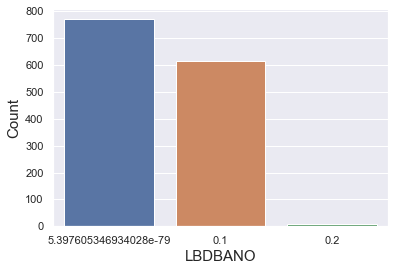

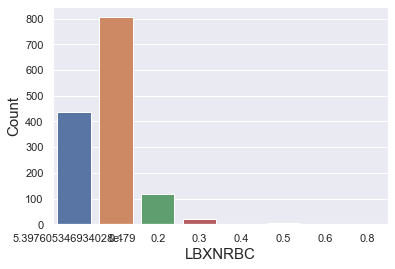

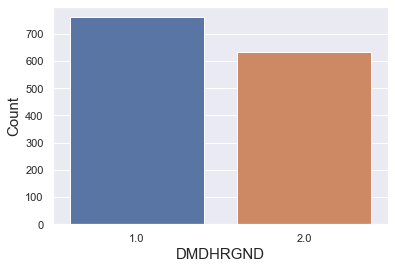

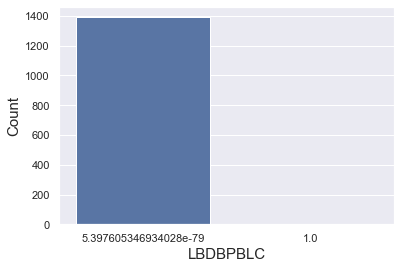

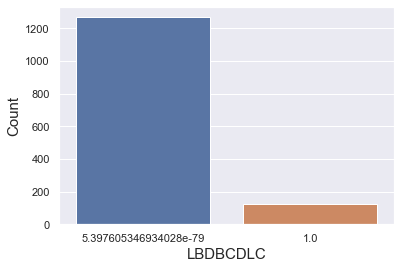

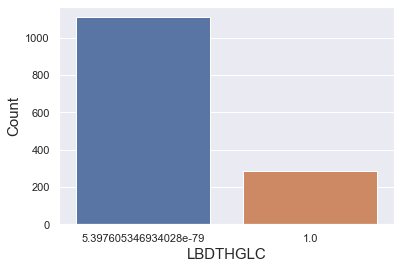

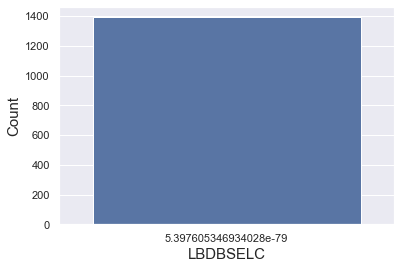

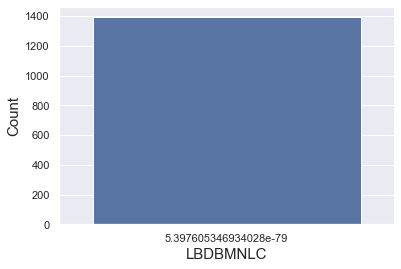

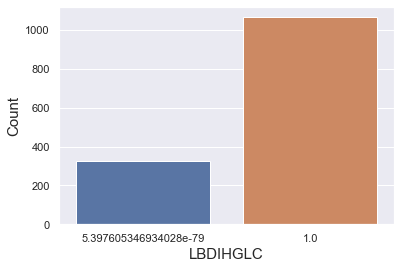

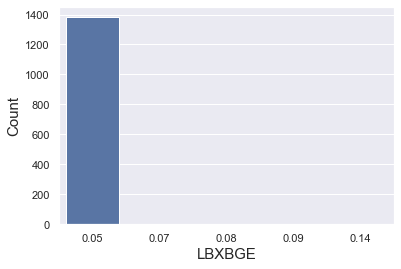

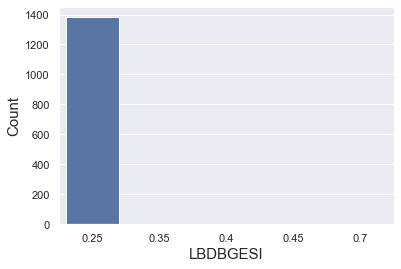

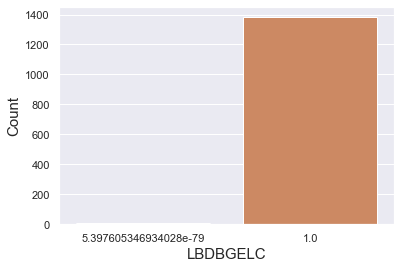

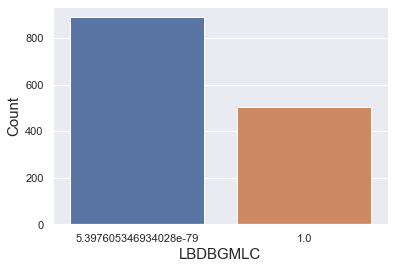

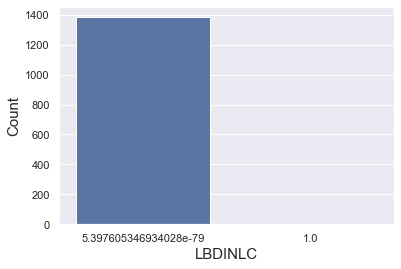

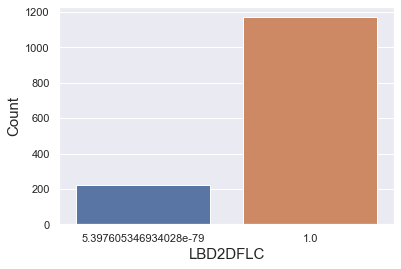

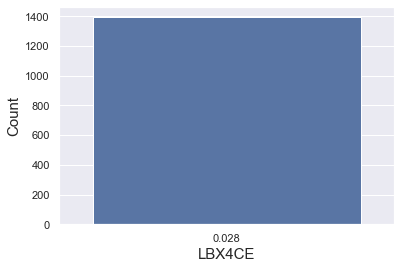

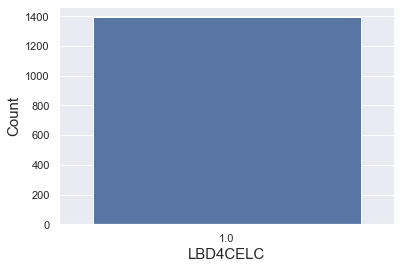

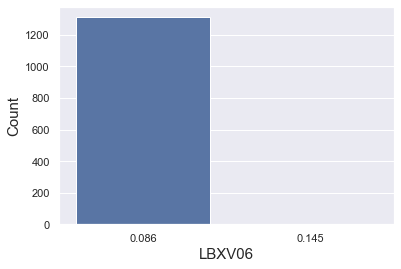

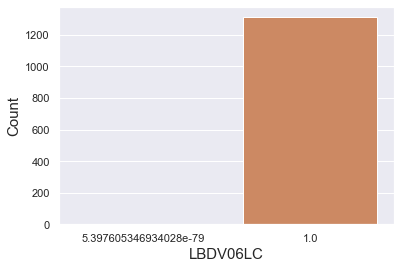

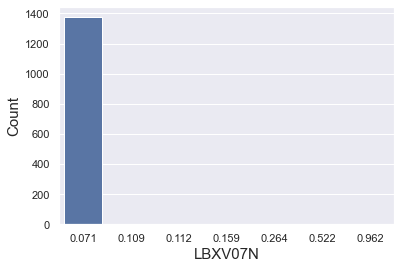

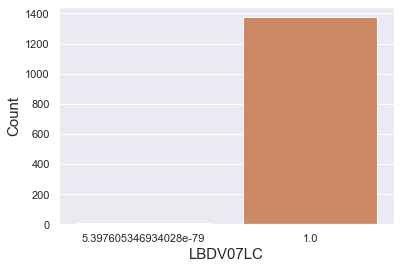

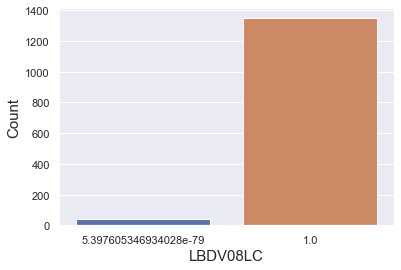

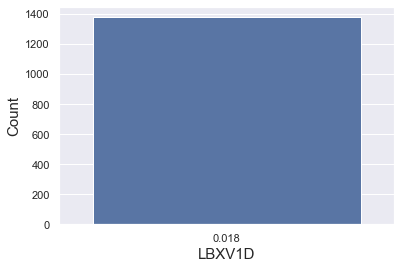

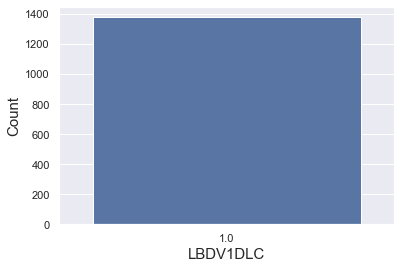

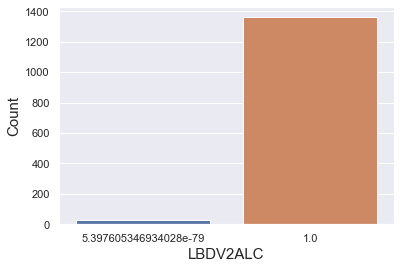

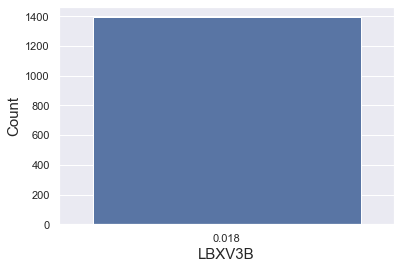

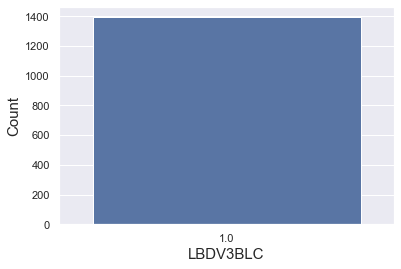

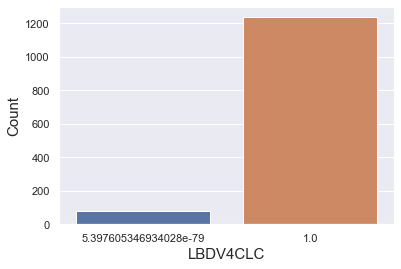

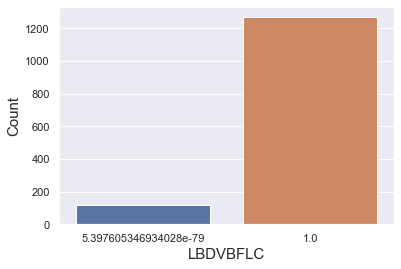

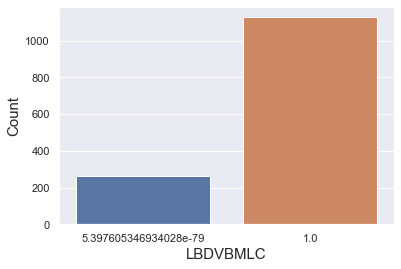

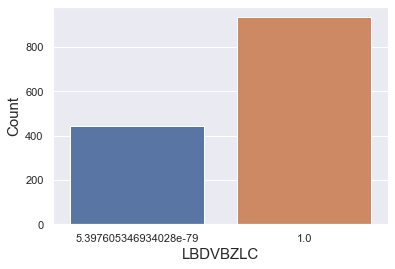

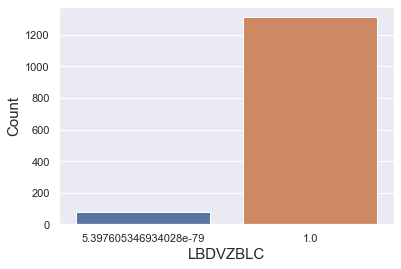

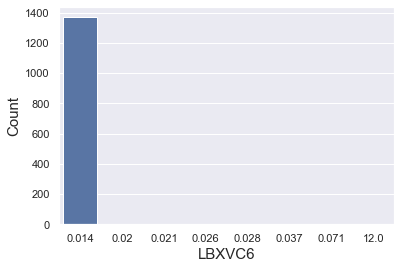

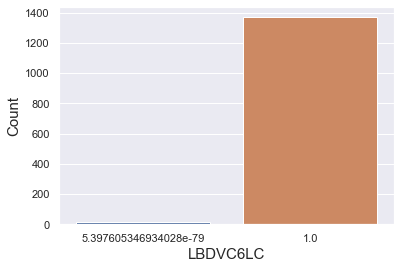

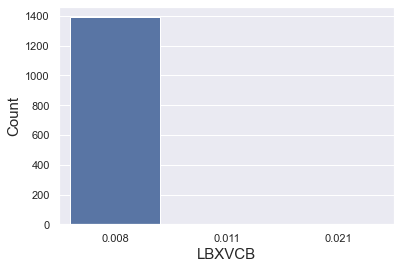

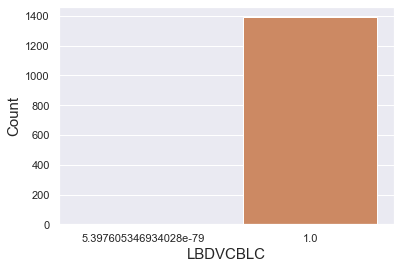

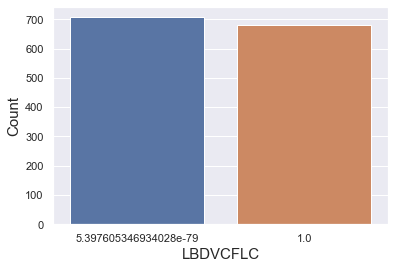

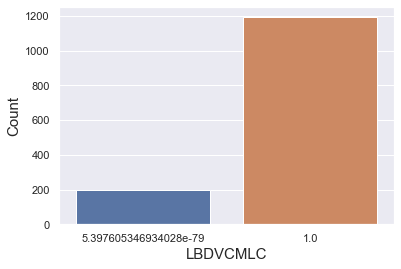

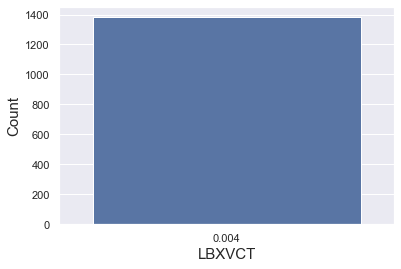

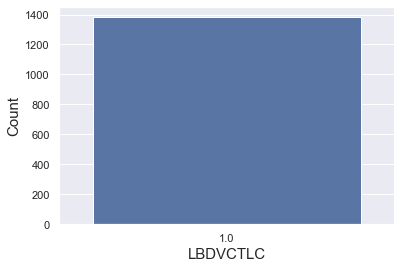

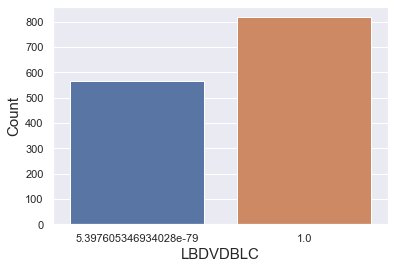

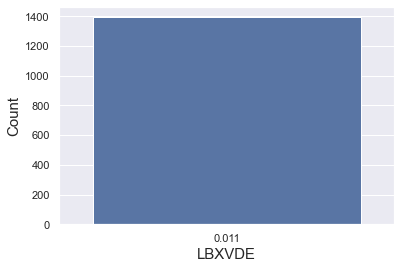

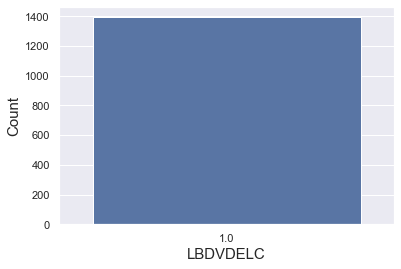

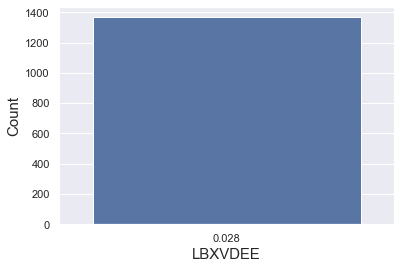

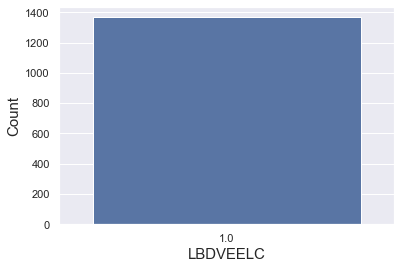

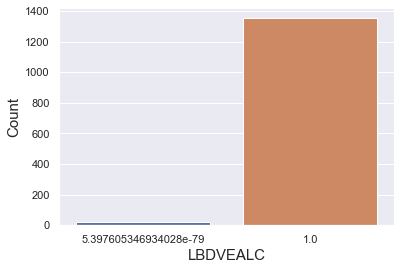

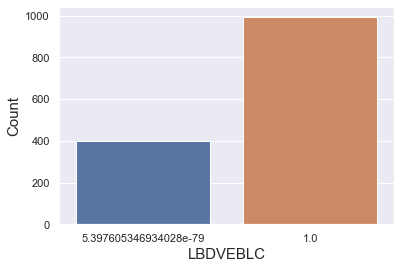

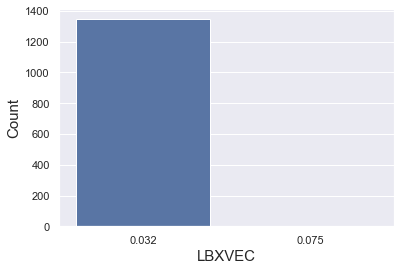

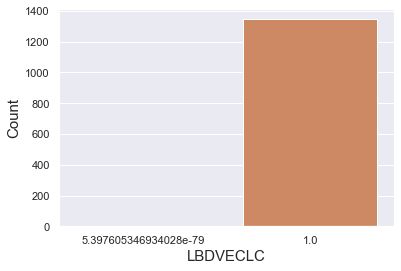

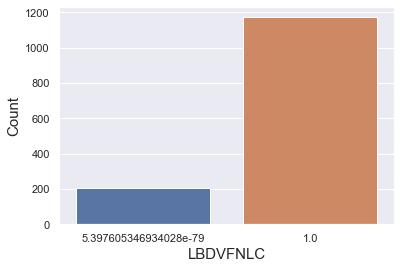

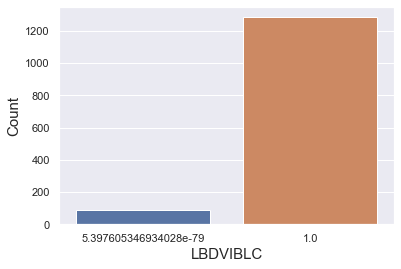

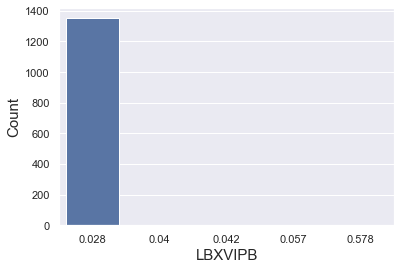

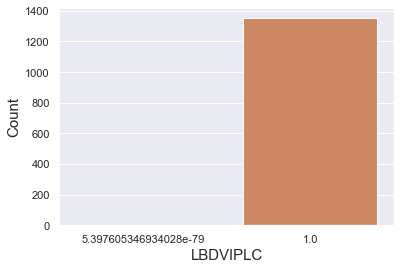

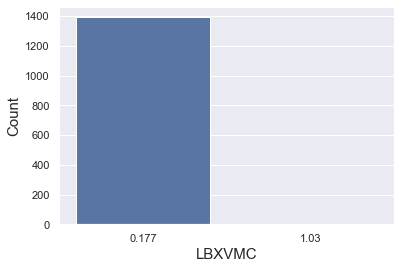

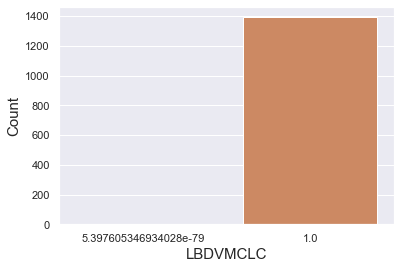

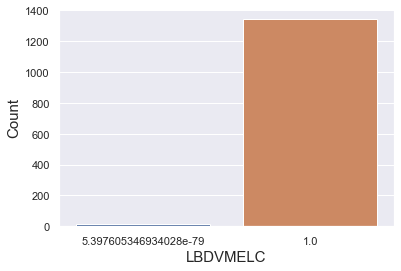

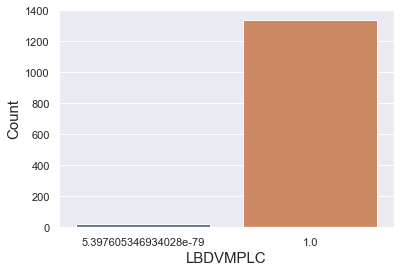

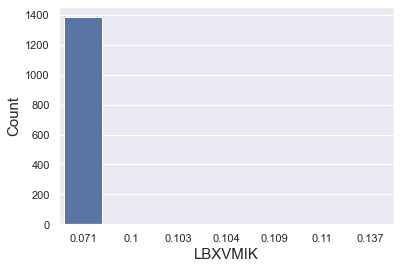

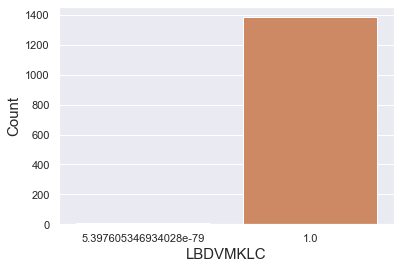

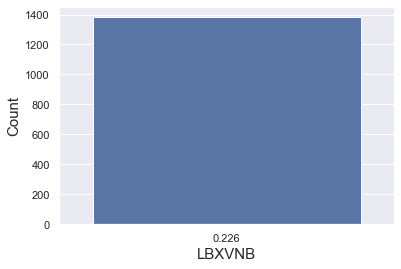

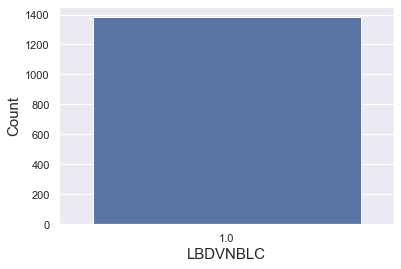

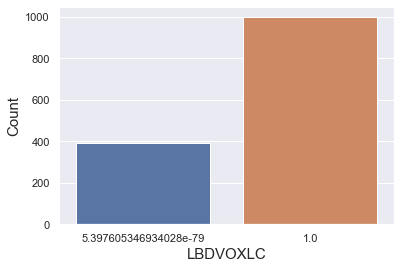

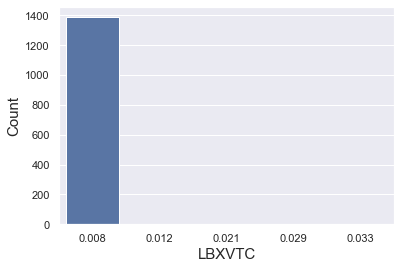

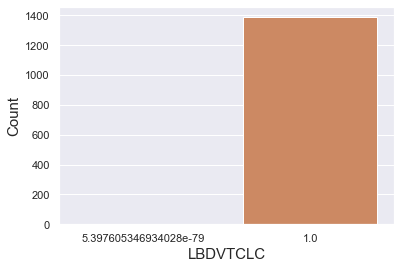

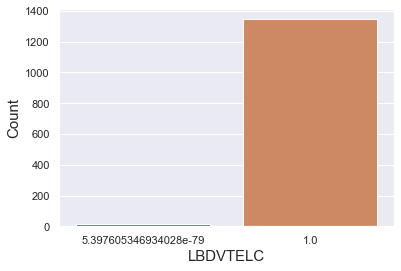

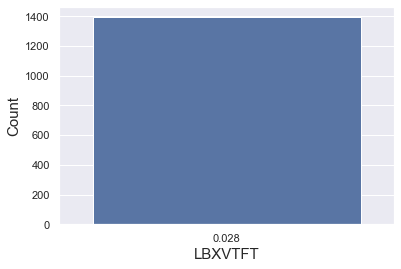

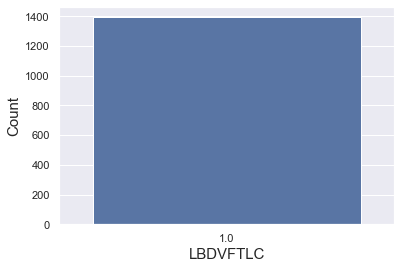

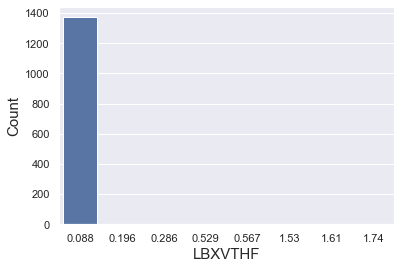

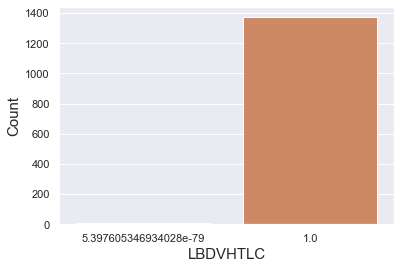

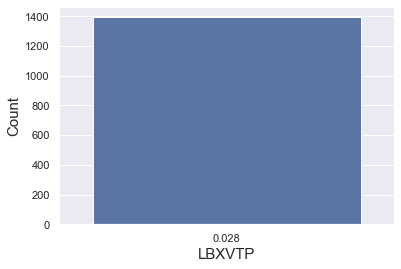

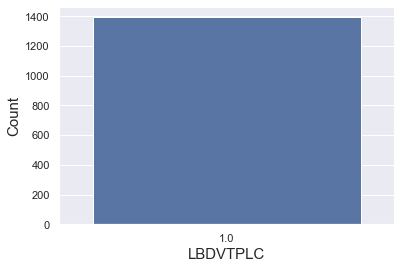

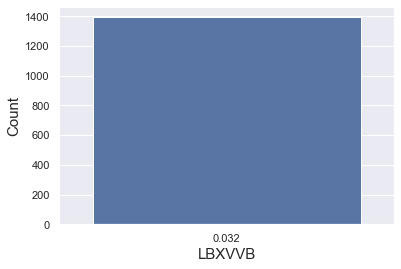

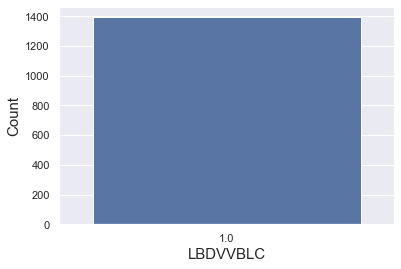

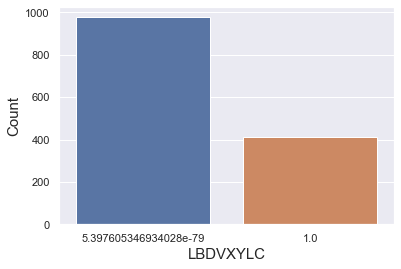

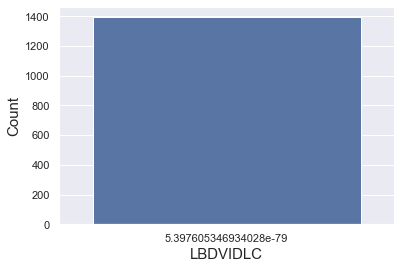

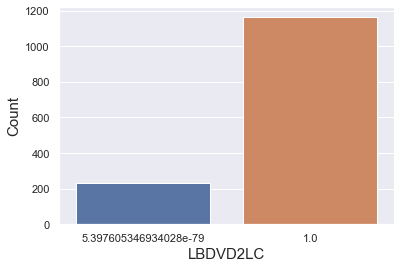

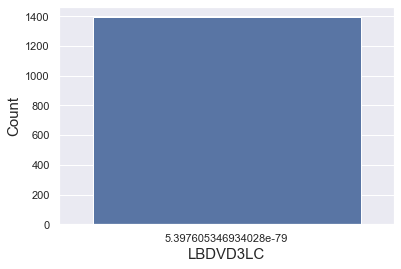

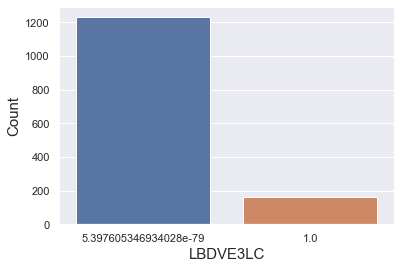

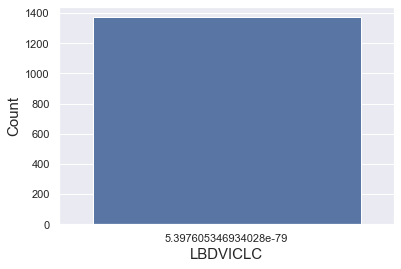

In [25]:
for i in catVars:
    plt.figure()
    sns.set(font_scale=1)
    sns.countplot(data=catlabdata, x = i)
    plt.xlabel(i, fontsize=15)
    plt.ylabel("Count", fontsize=15)
    plt.show()

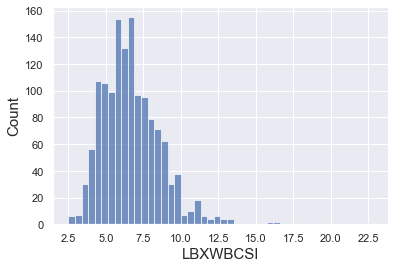

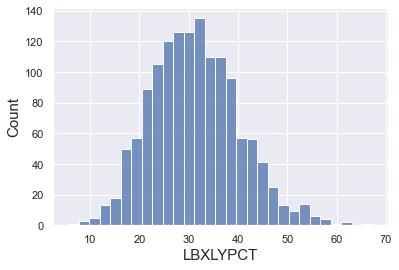

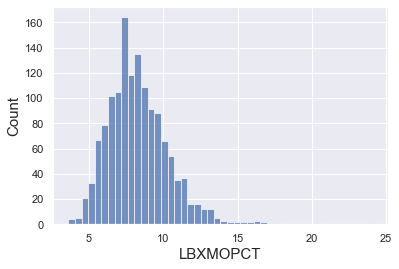

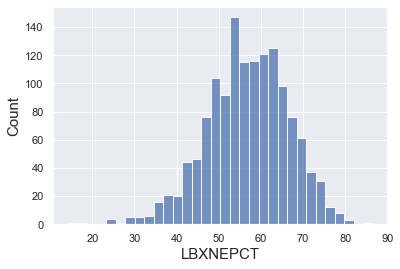

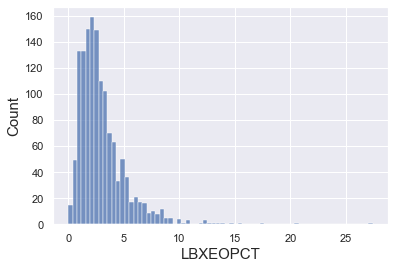

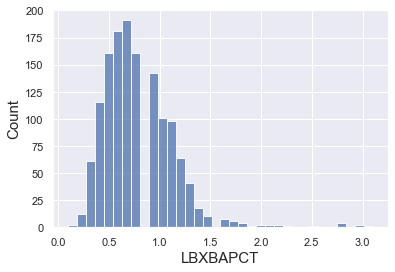

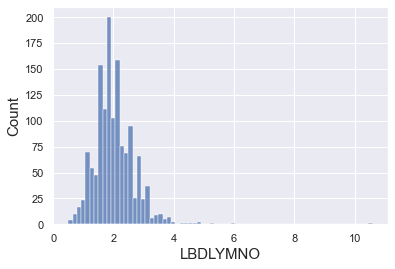

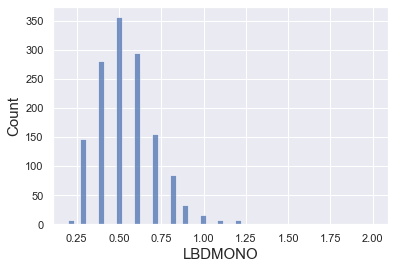

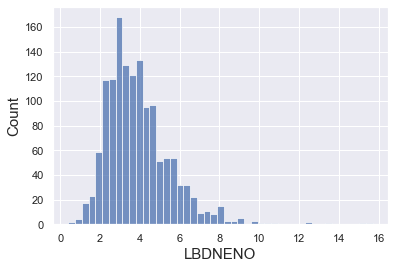

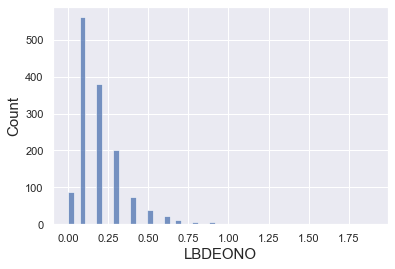

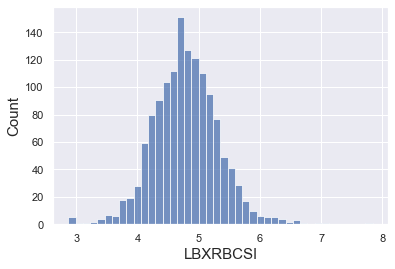

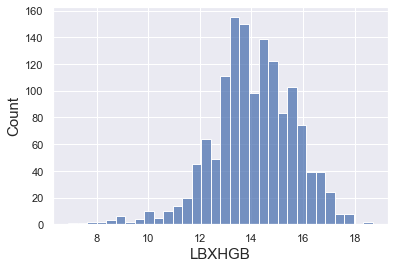

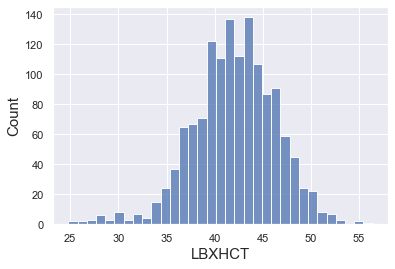

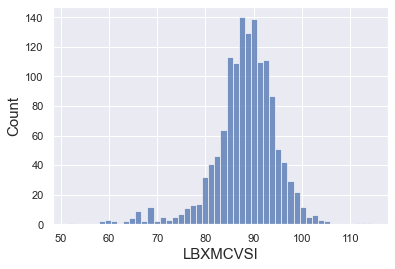

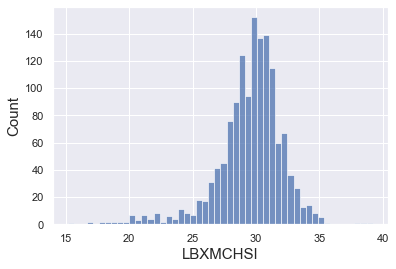

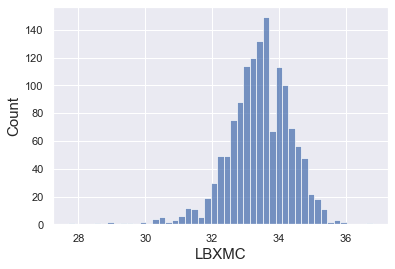

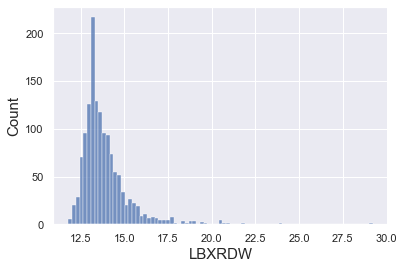

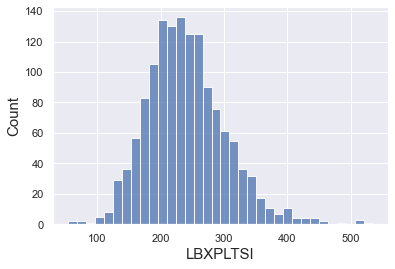

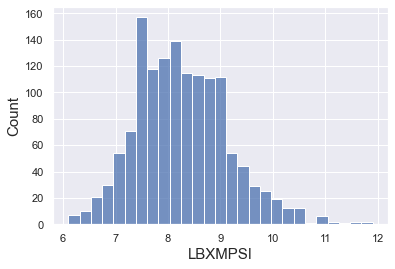

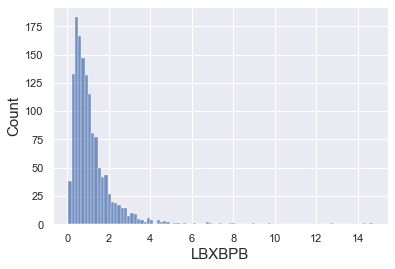

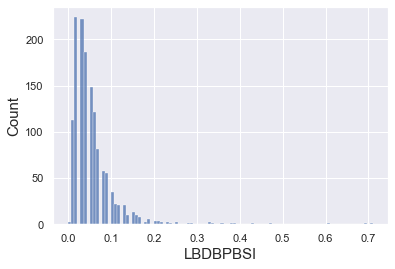

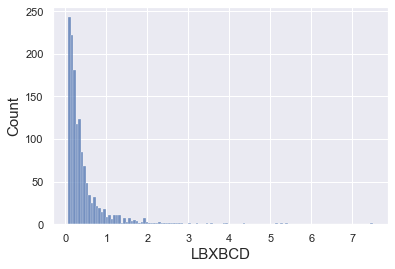

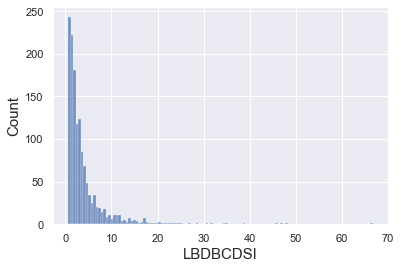

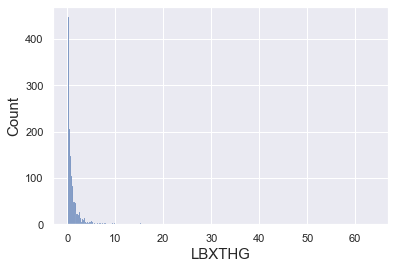

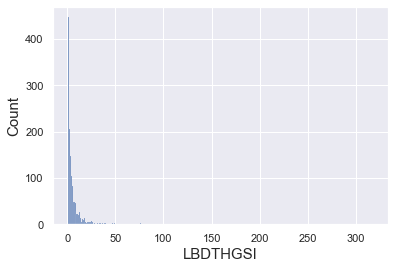

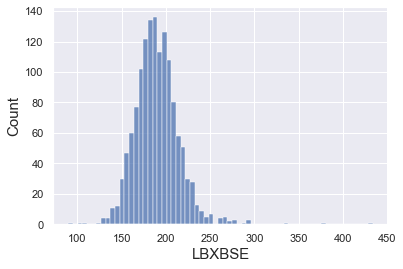

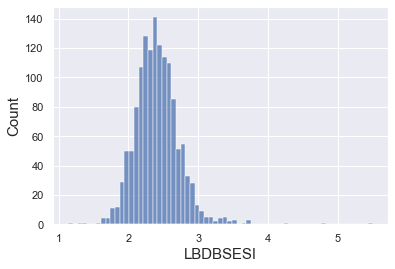

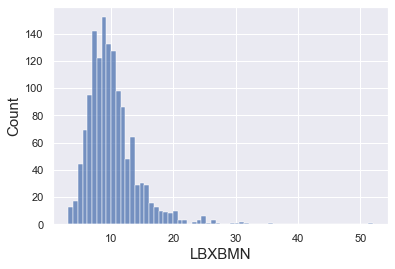

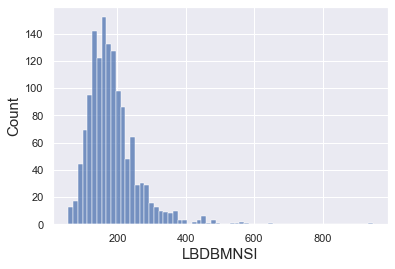

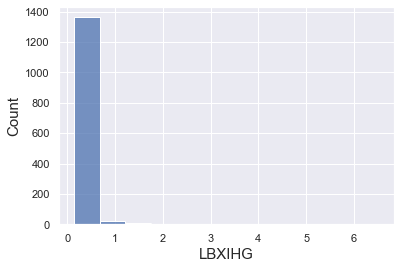

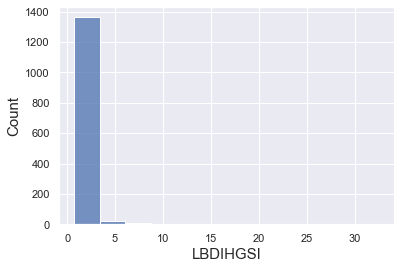

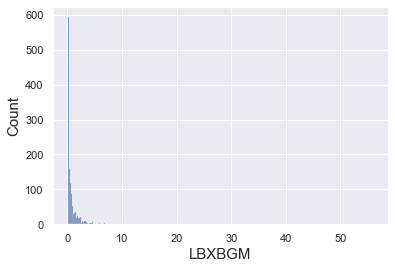

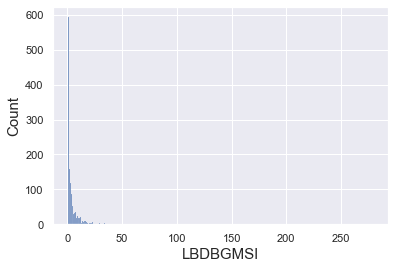

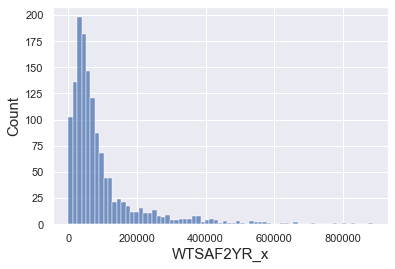

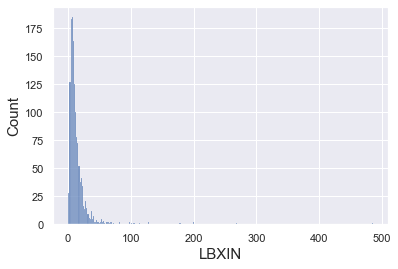

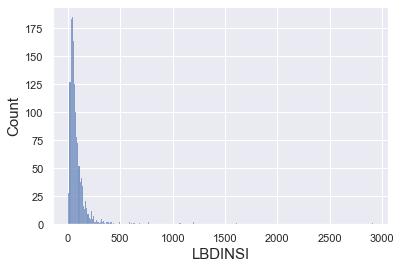

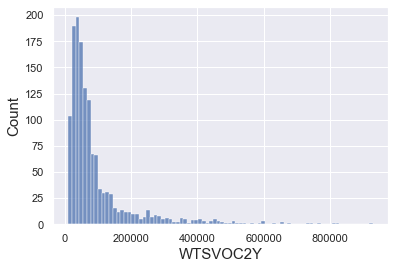

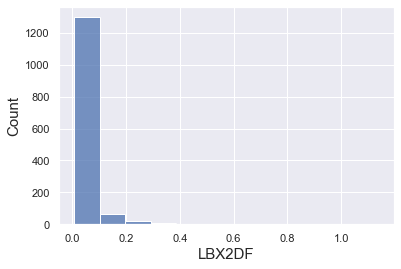

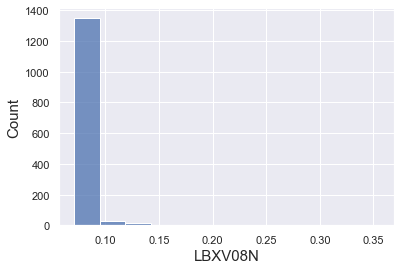

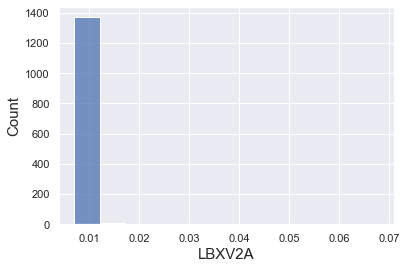

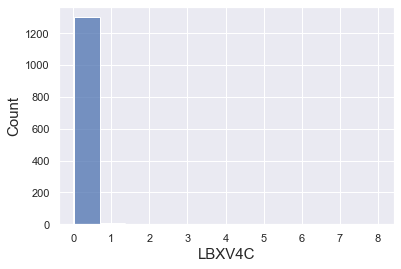

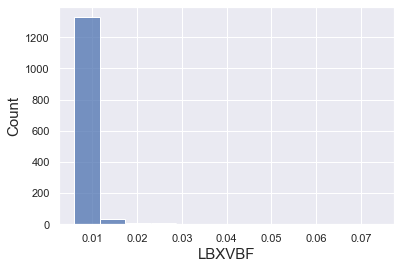

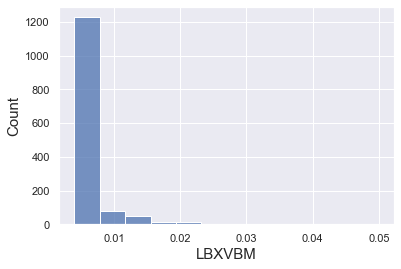

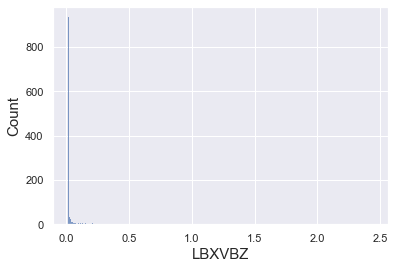

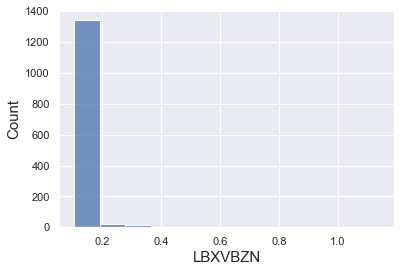

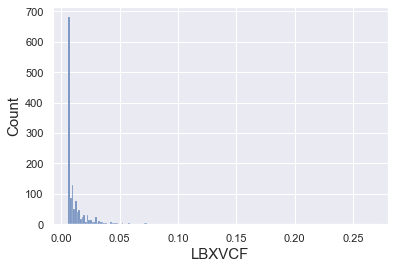

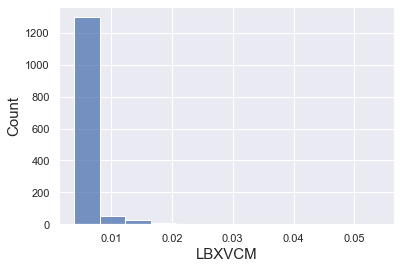

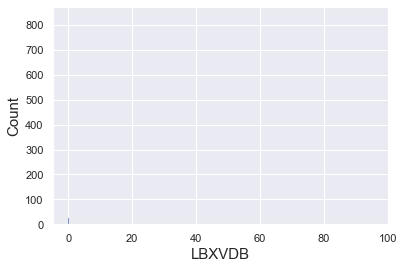

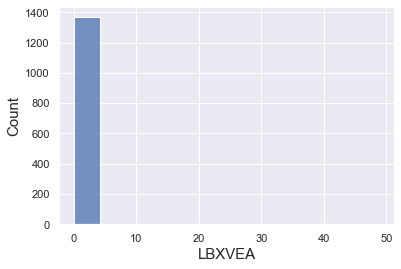

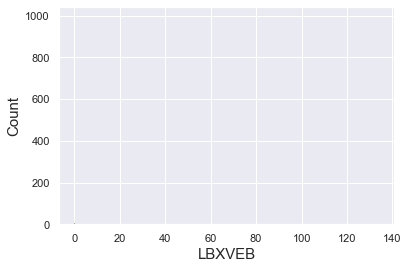

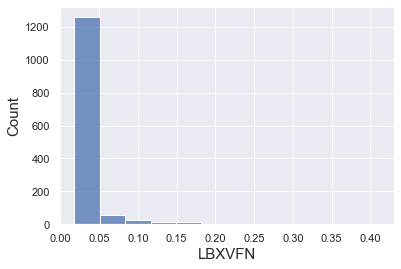

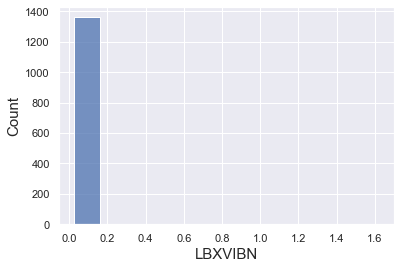

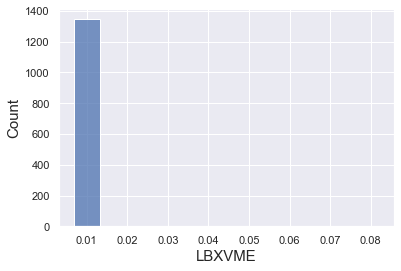

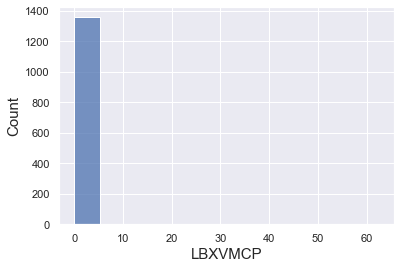

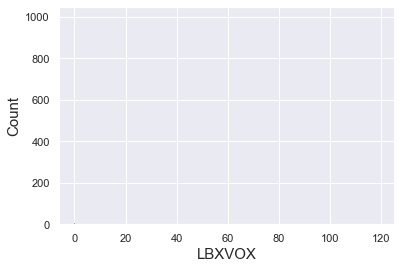

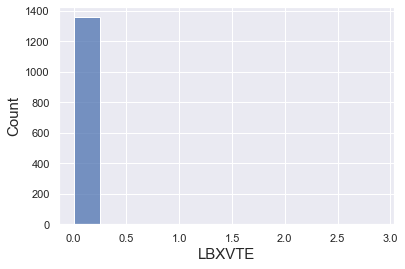

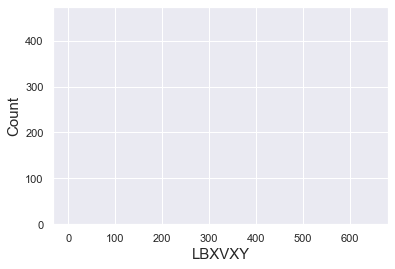

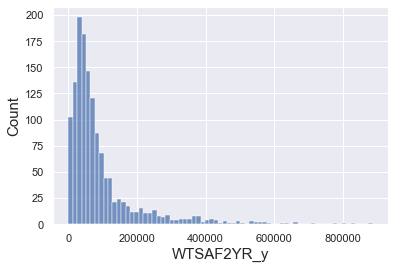

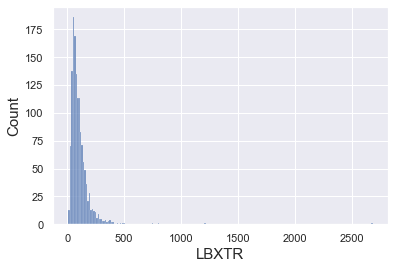

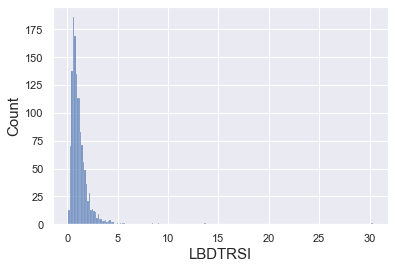

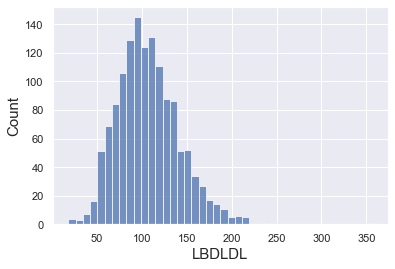

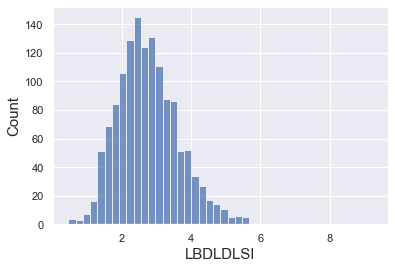

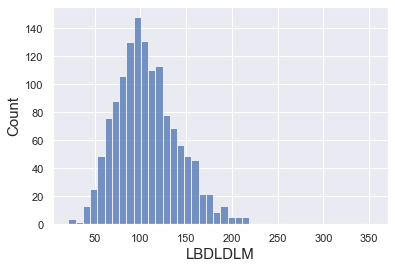

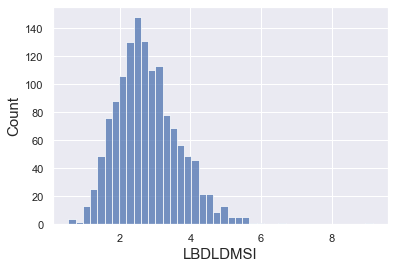

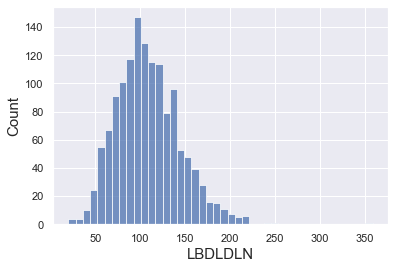

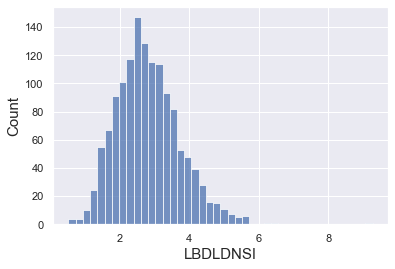

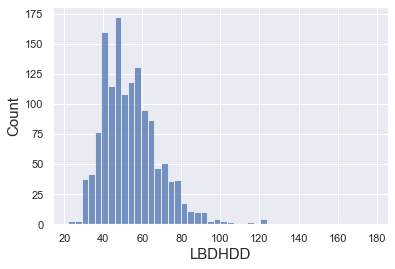

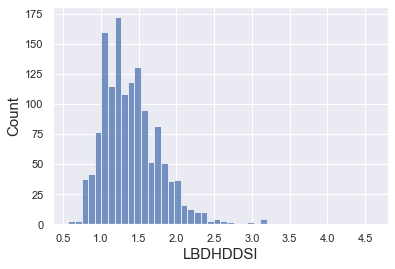

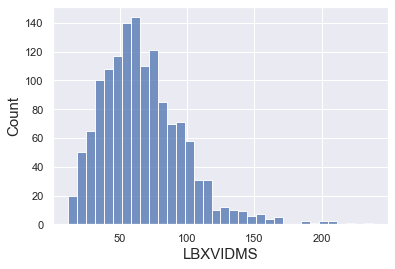

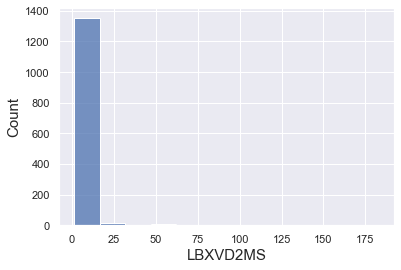

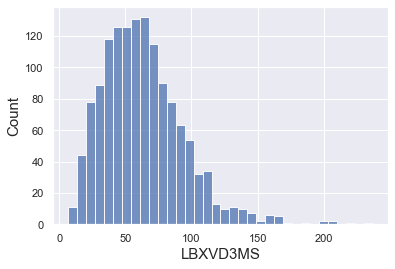

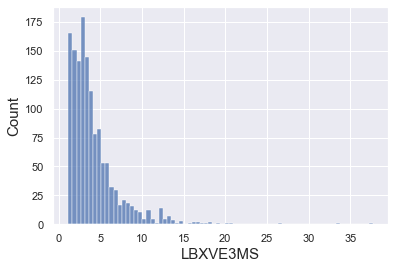

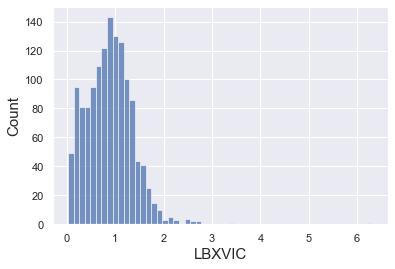

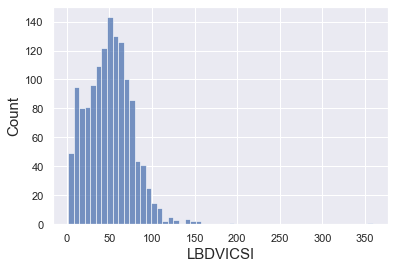

In [26]:
for i in numVars:
    plt.figure()
    sns.set(font_scale=1)
    sns.histplot(data=numlabdata, x = i)
    plt.xlabel(i, fontsize=15)
    plt.ylabel("Count", fontsize=15)
    plt.show()

In [27]:

# Create an imputer object with a median filling strategy
imputer_num = SimpleImputer(strategy='median')

# Apply the imputer to the numerical data
numlabdataimputed = pd.DataFrame(imputer_num.fit_transform(numlabdata), columns=numlabdata.columns)

# Impute missing values with the mode for each column
catlabdataimputed = catlabdata.apply(lambda x: x.fillna(x.mode()[0]), axis=0)

print(numlabdataimputed)
print(catlabdataimputed)

      LBXWBCSI  LBXLYPCT  LBXMOPCT  LBXNEPCT  LBXEOPCT  LBXBAPCT  LBDLYMNO  \
0          6.0      31.3       6.8      59.4       2.0       0.7       1.9   
1          5.0      35.5      10.0      53.0       1.3       0.4       1.8   
2          6.2      44.0       6.0      46.9       2.7       0.5       2.7   
3          4.8      37.9       7.2      53.1       1.2       0.7       1.8   
4          8.8      24.9       9.4      61.4       3.3       1.0       2.2   
...        ...       ...       ...       ...       ...       ...       ...   
1388       7.1      36.2       5.9      55.2       2.0       0.9       2.6   
1389      16.3      18.2       5.6      75.5       0.5       0.3       3.0   
1390       7.0      35.5       5.4      53.2       5.3       0.8       2.5   
1391       5.2      32.1       6.1      57.8       3.0       1.1       1.7   
1392       9.0      29.4       6.9      58.8       4.0       1.0       2.6   

      LBDMONO  LBDNENO  LBDEONO  ...  LBDLDLN  LBDLDNSI  LBDHDD

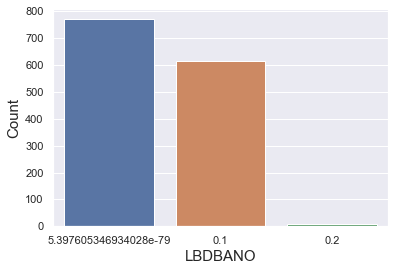

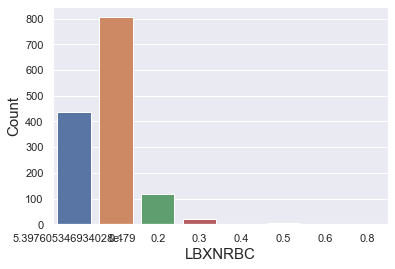

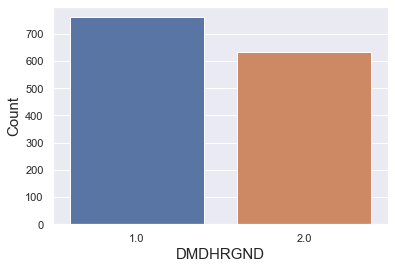

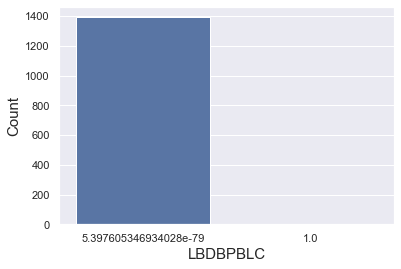

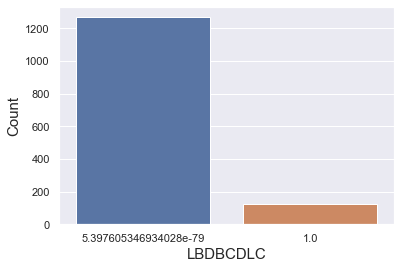

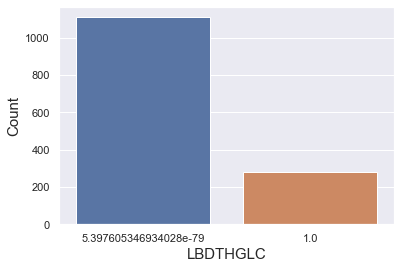

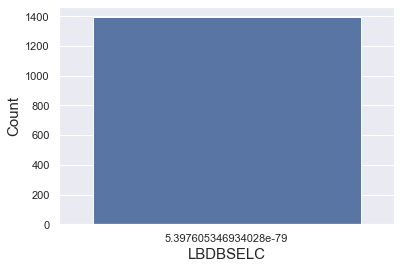

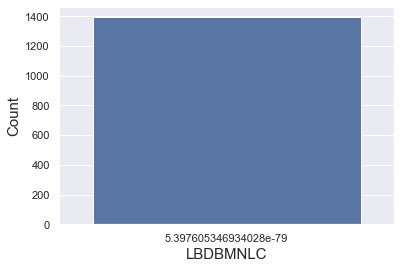

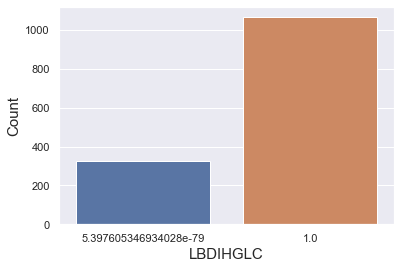

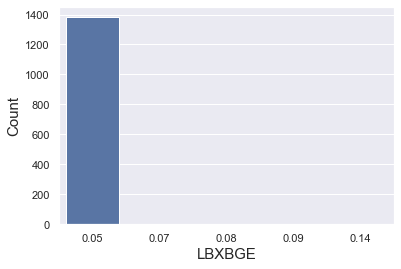

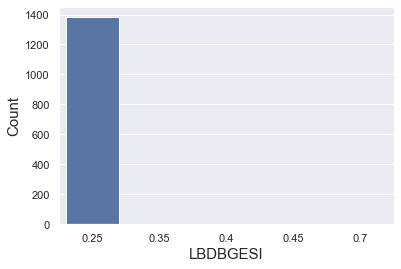

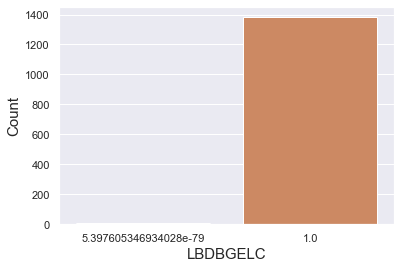

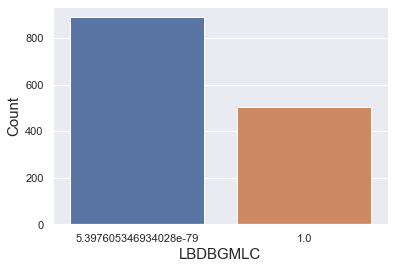

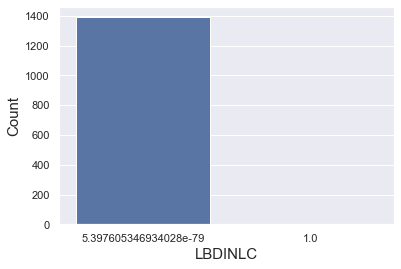

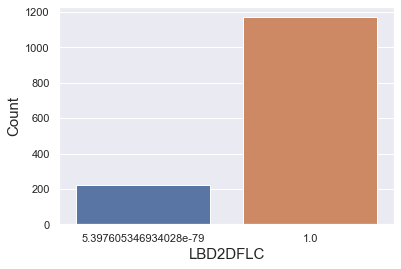

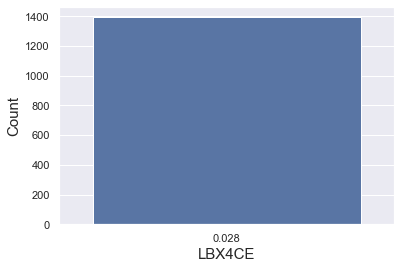

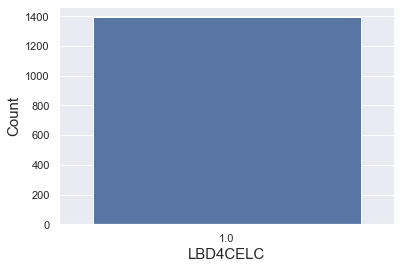

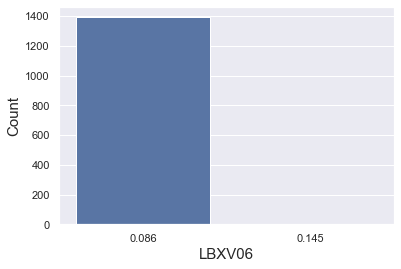

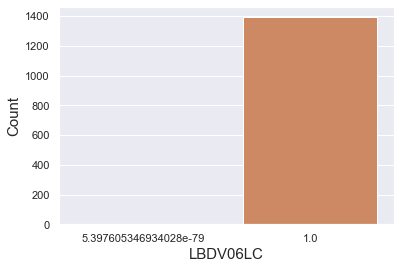

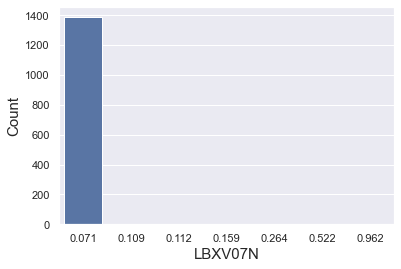

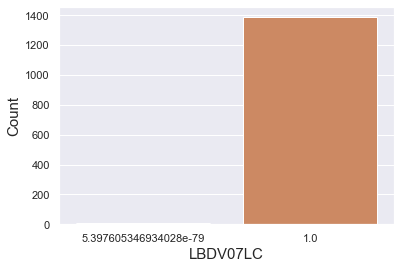

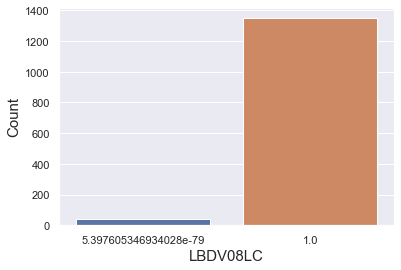

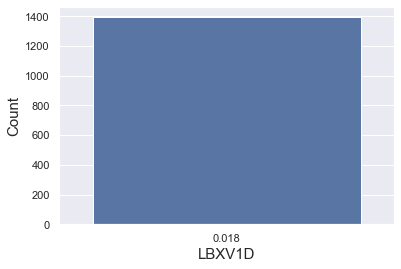

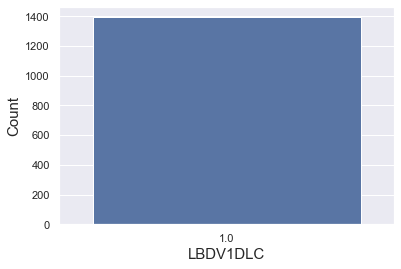

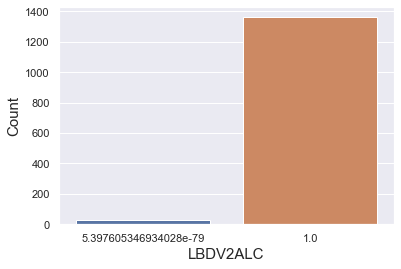

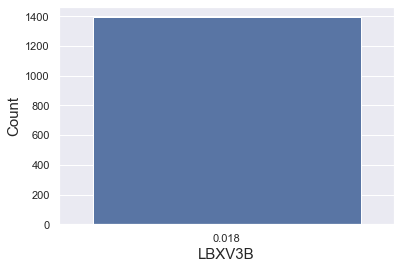

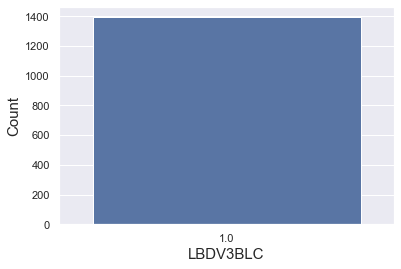

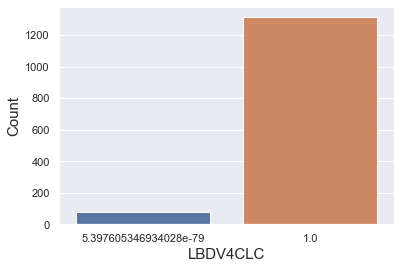

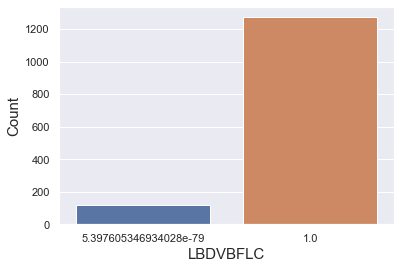

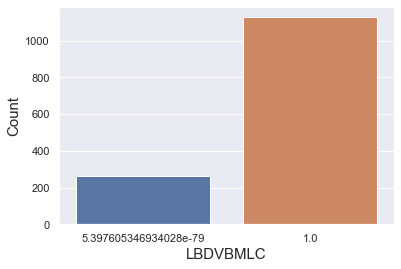

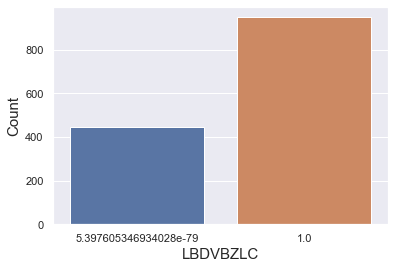

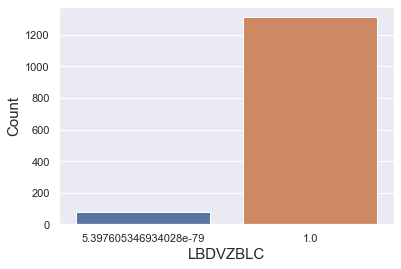

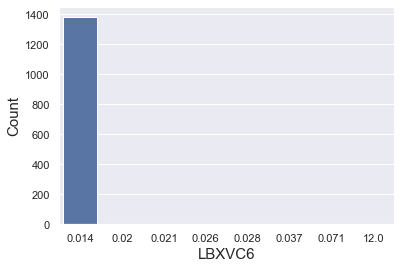

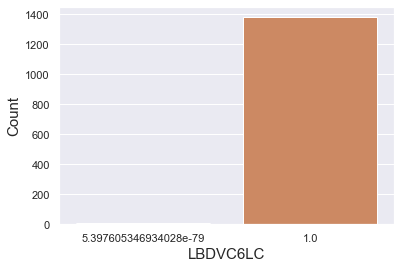

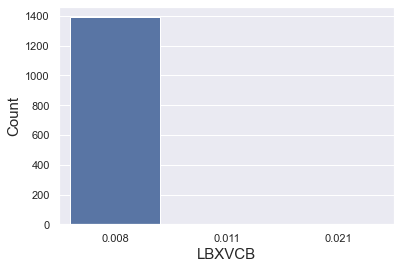

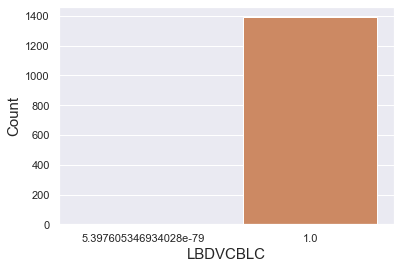

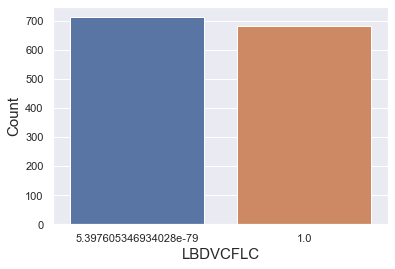

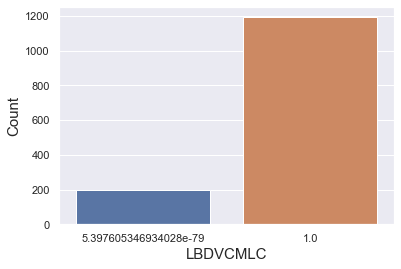

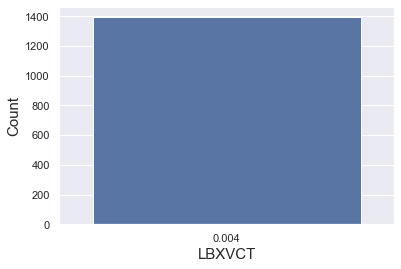

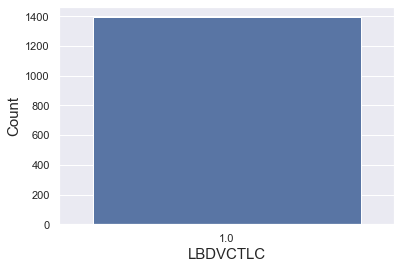

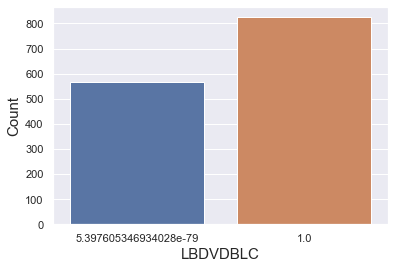

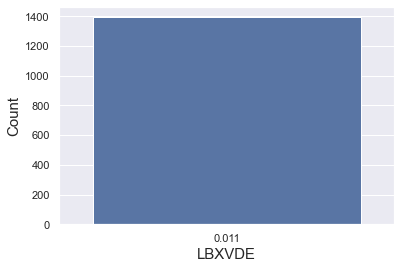

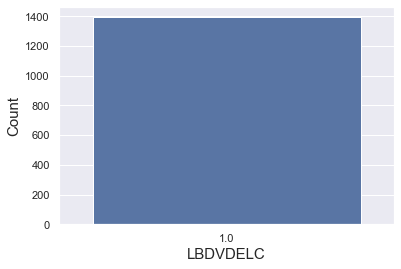

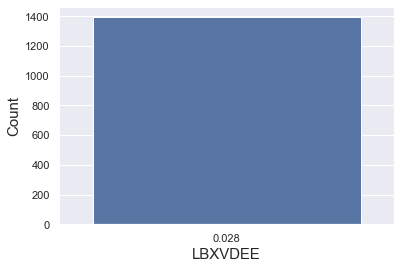

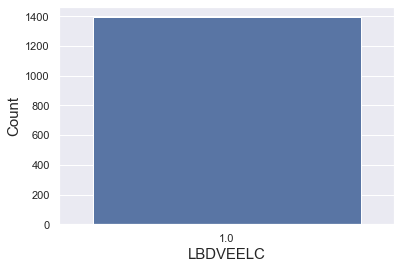

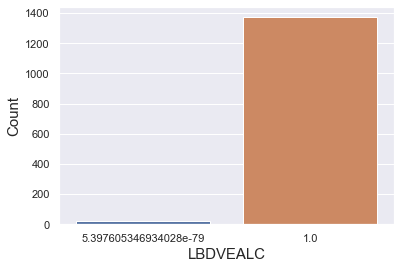

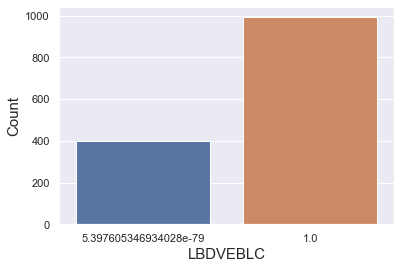

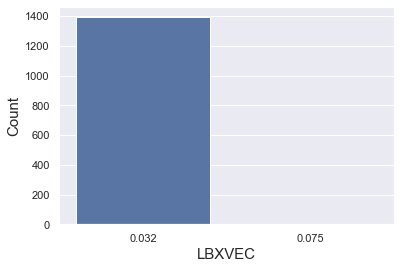

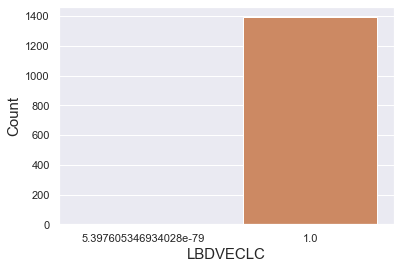

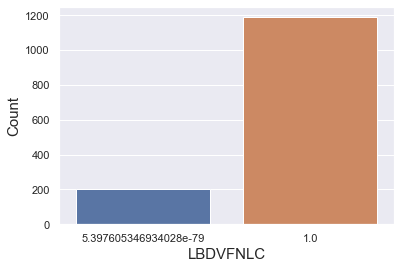

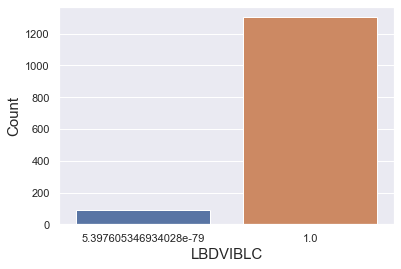

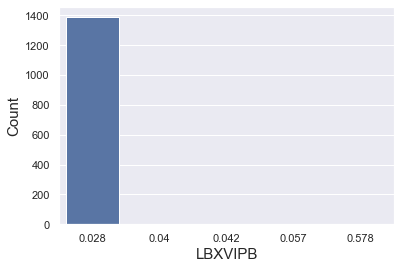

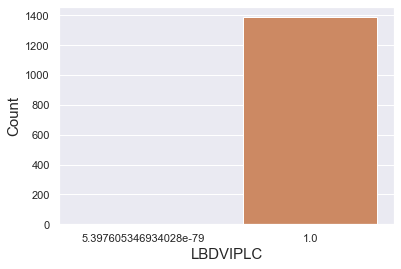

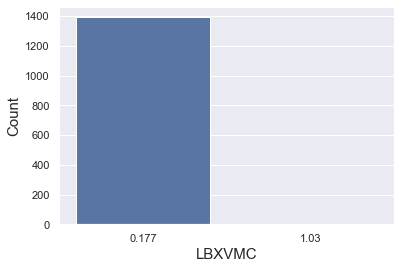

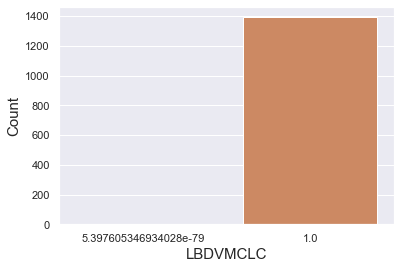

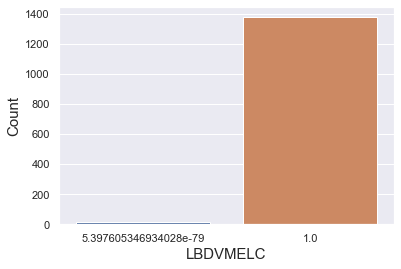

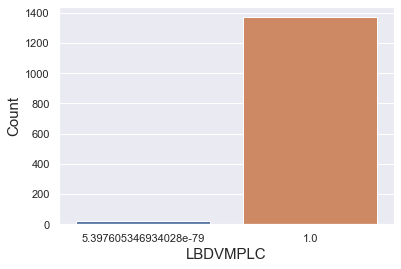

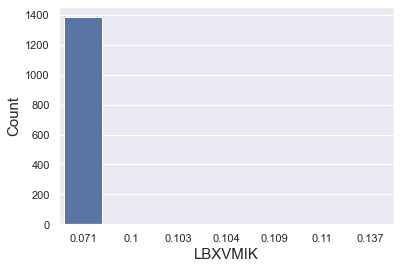

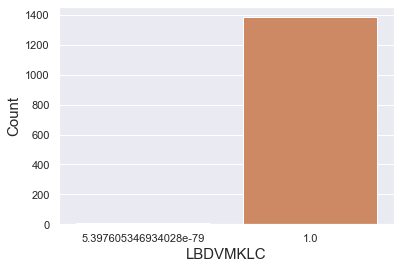

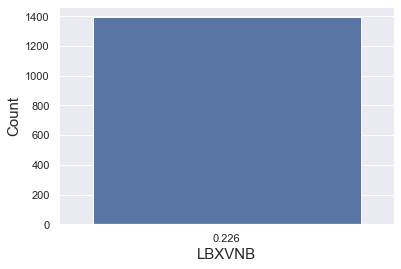

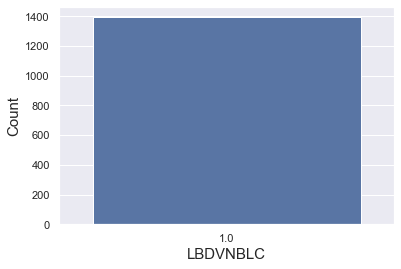

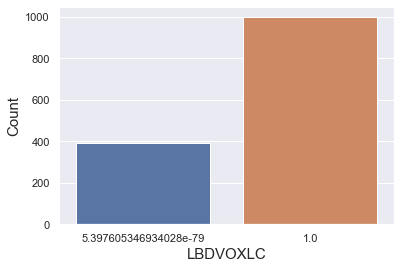

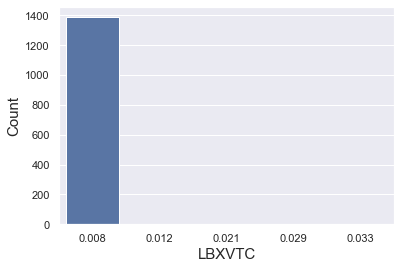

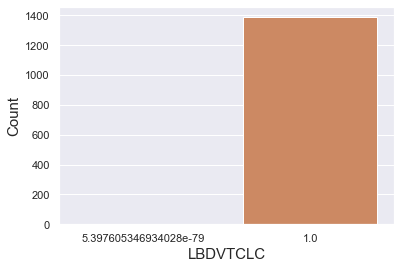

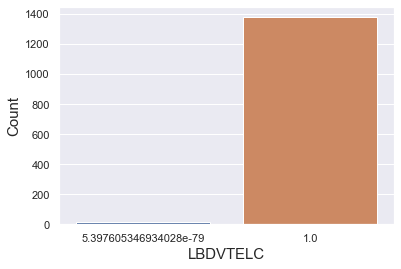

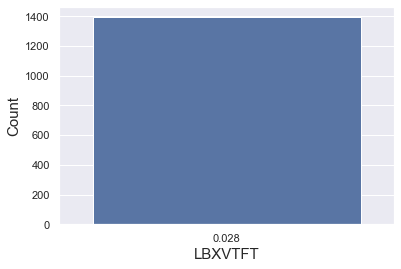

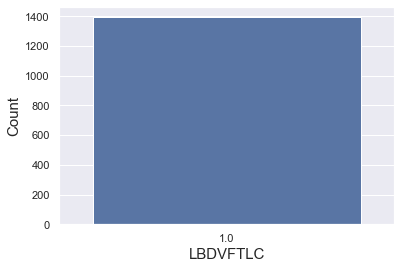

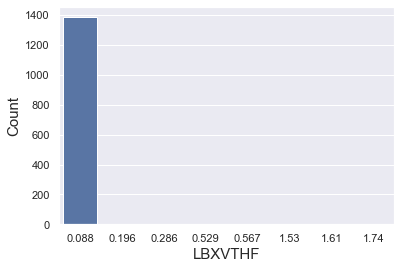

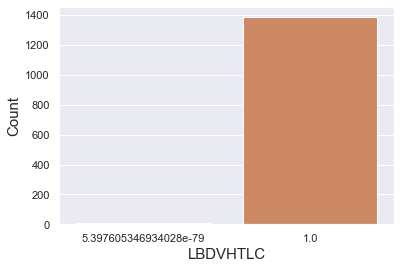

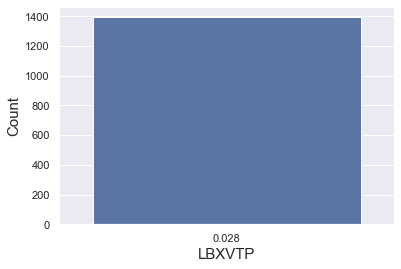

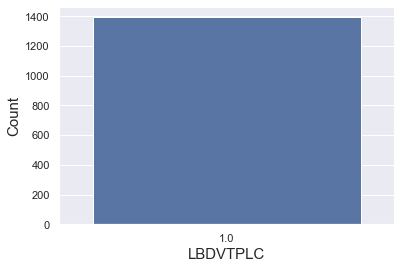

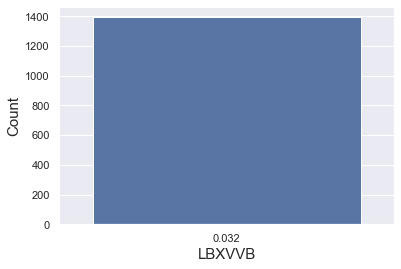

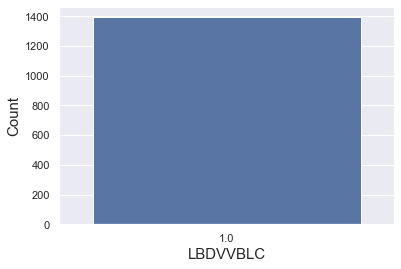

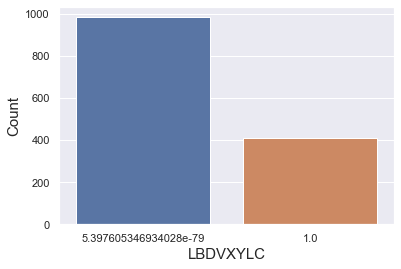

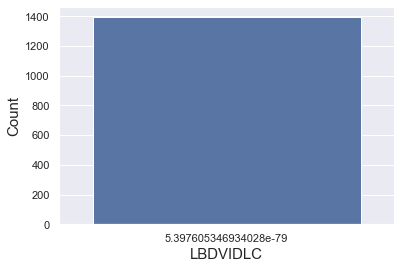

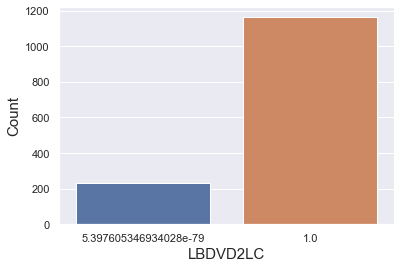

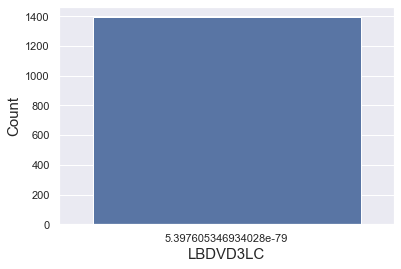

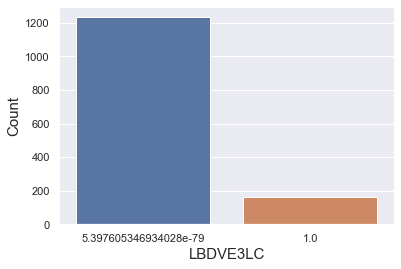

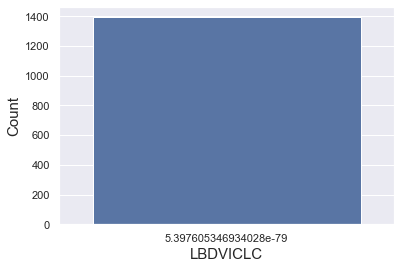

In [28]:
for i in catVars:
    plt.figure()
    sns.set(font_scale=1)
    sns.countplot(data=catlabdataimputed, x = i)
    plt.xlabel(i, fontsize=15)
    plt.ylabel("Count", fontsize=15)
    plt.show()

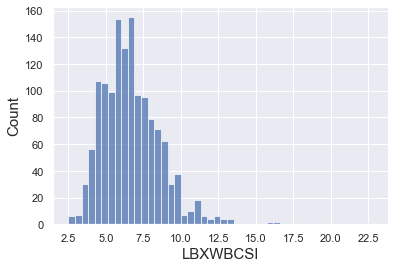

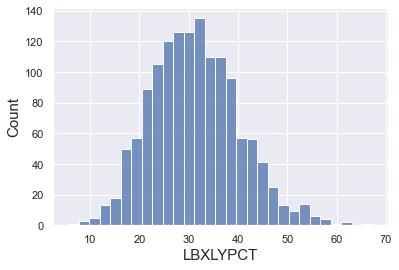

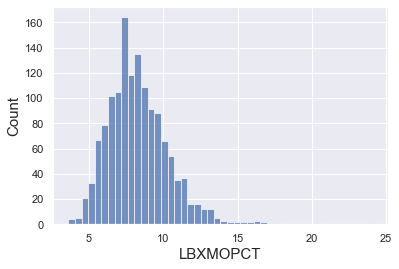

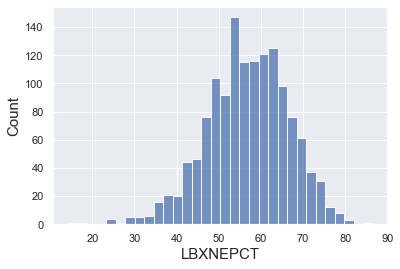

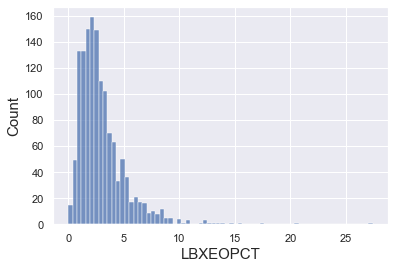

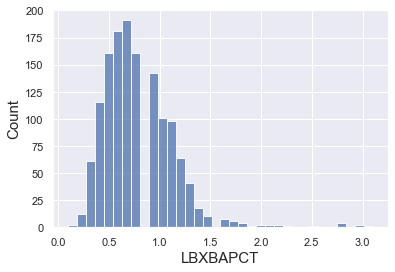

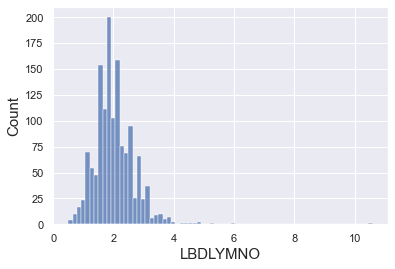

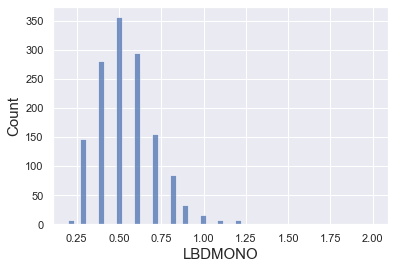

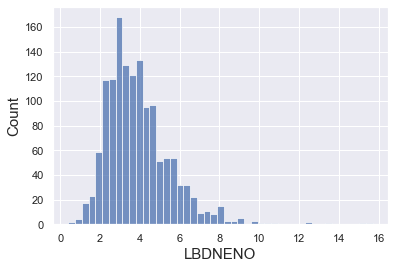

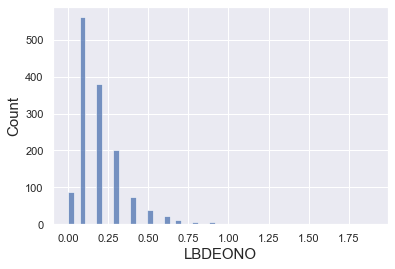

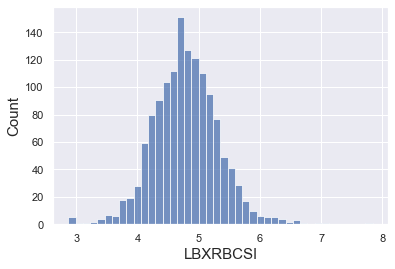

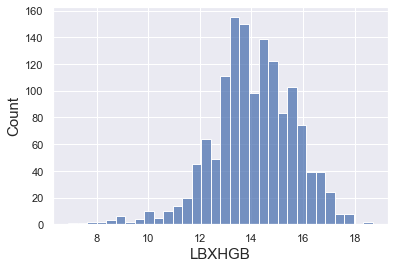

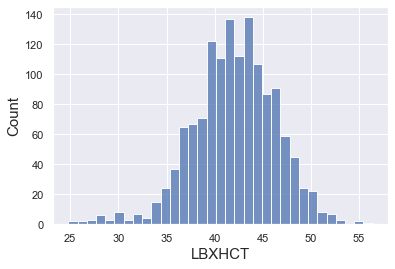

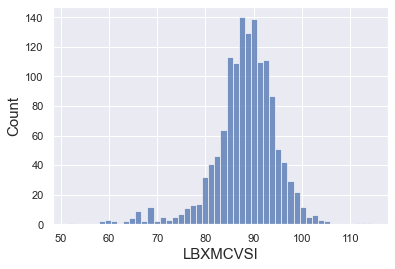

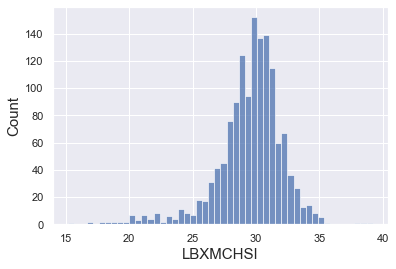

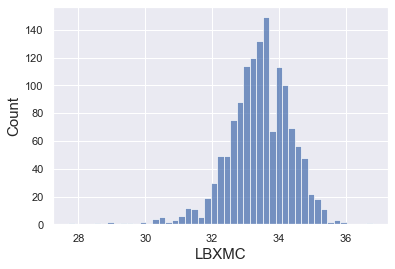

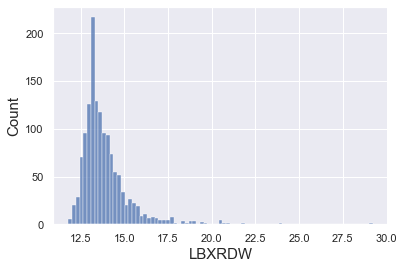

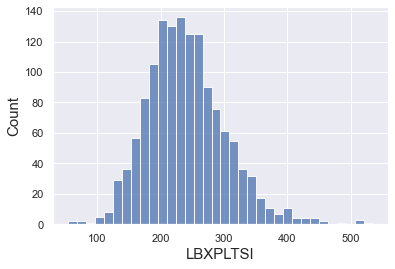

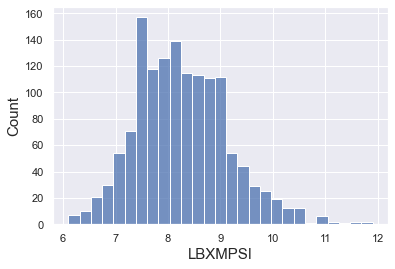

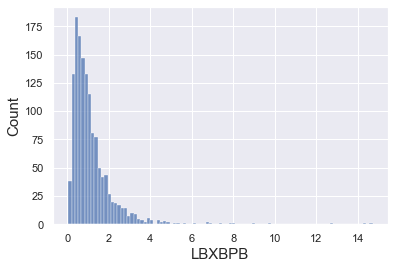

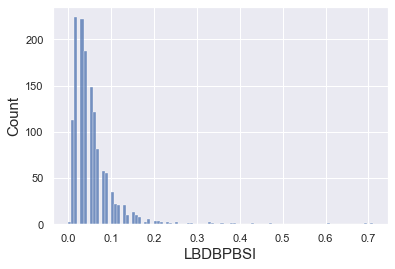

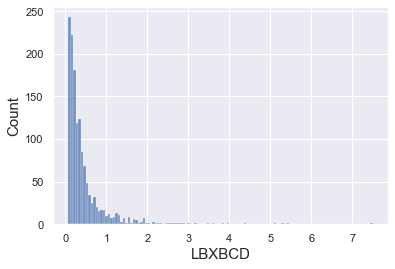

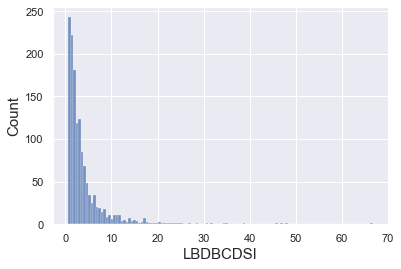

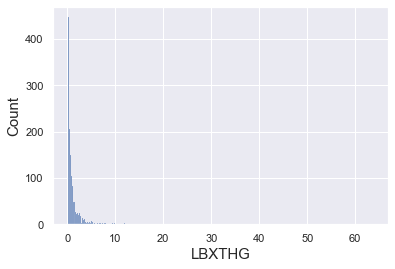

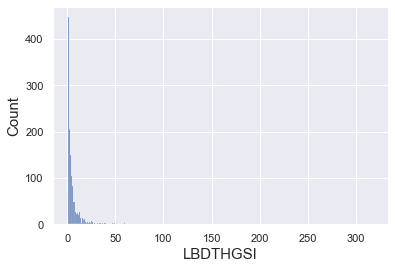

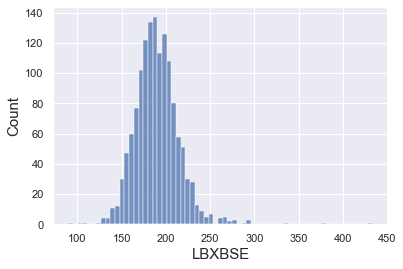

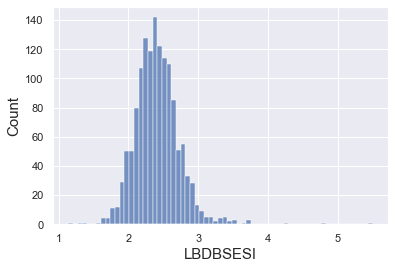

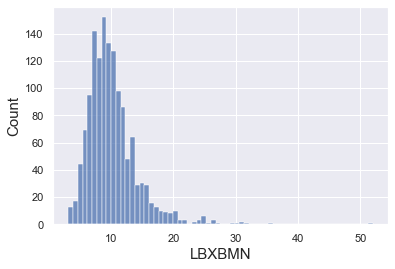

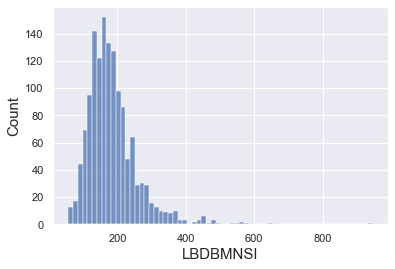

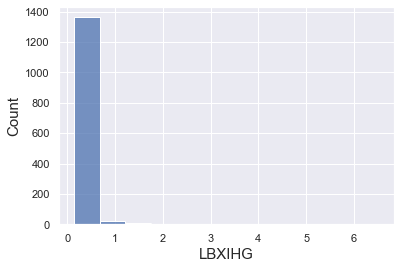

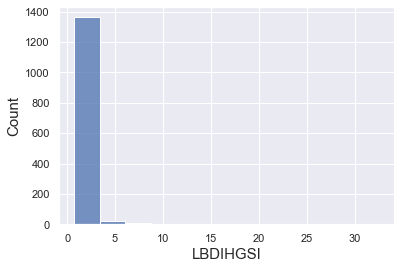

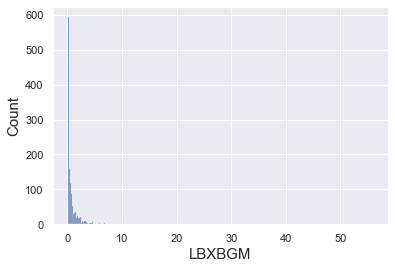

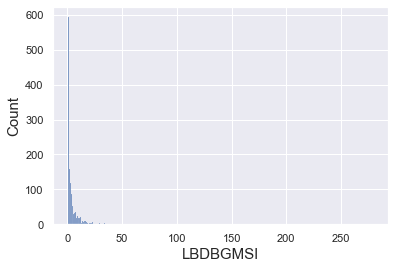

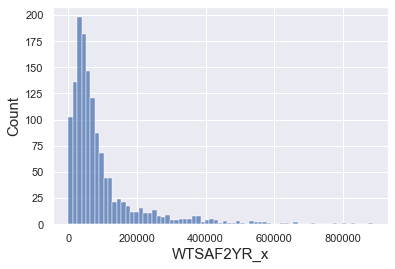

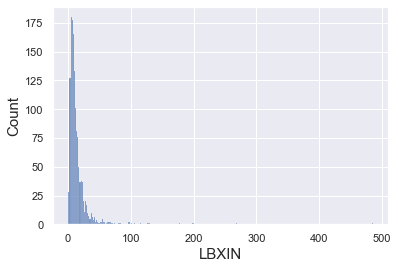

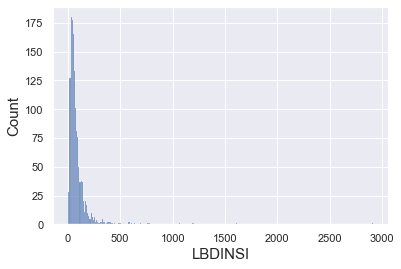

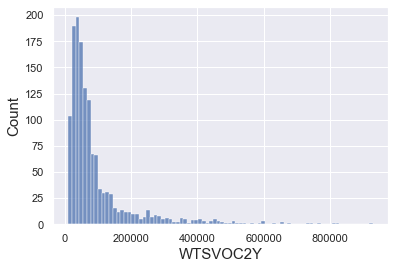

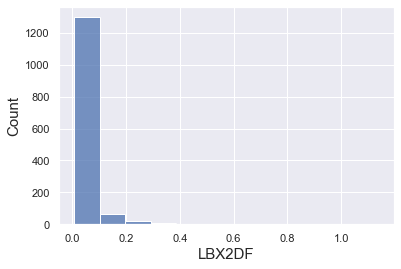

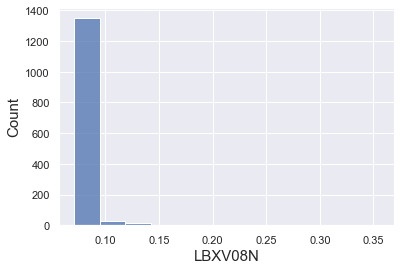

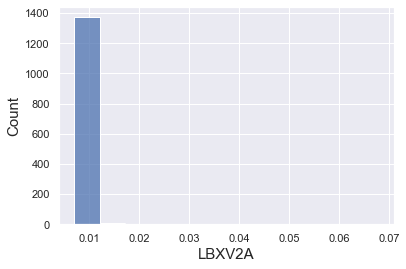

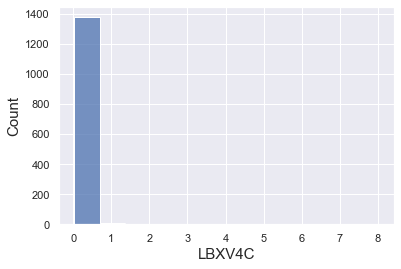

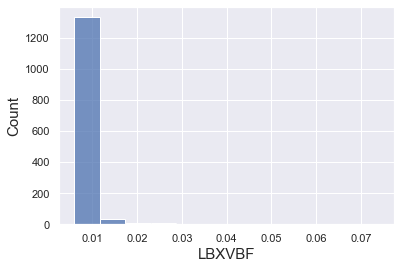

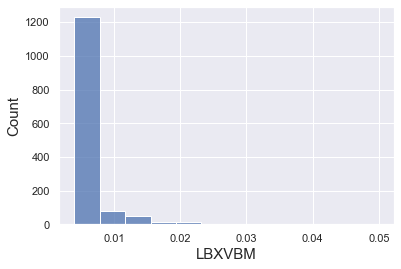

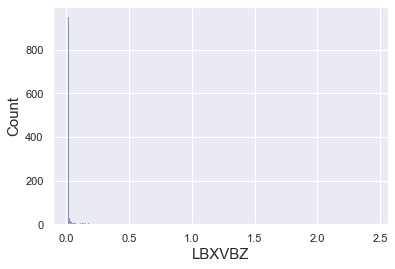

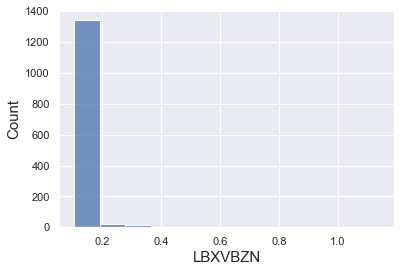

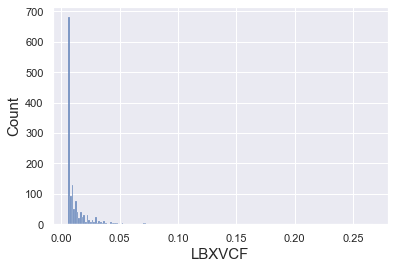

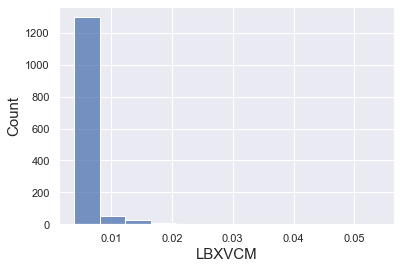

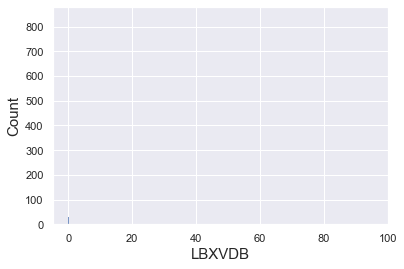

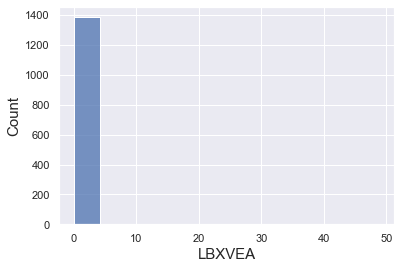

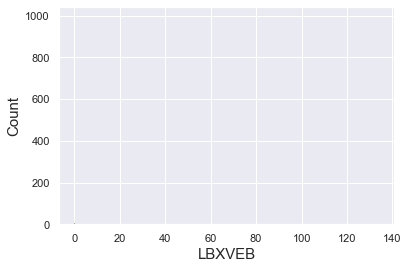

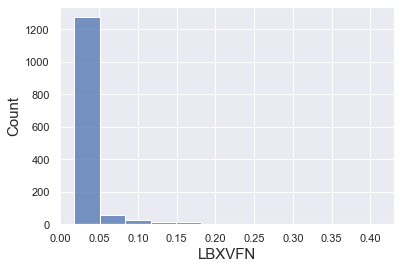

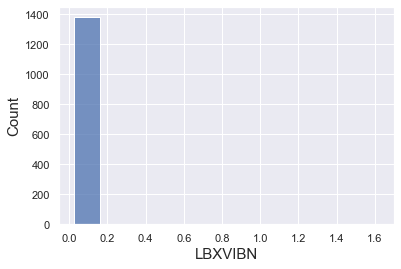

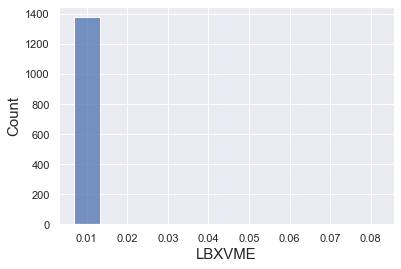

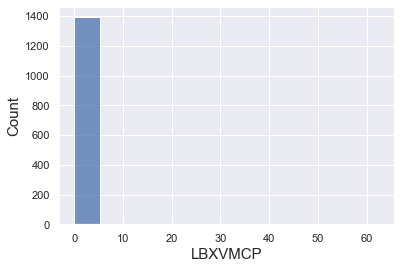

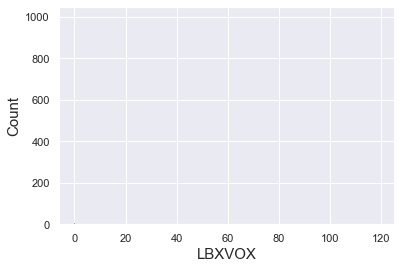

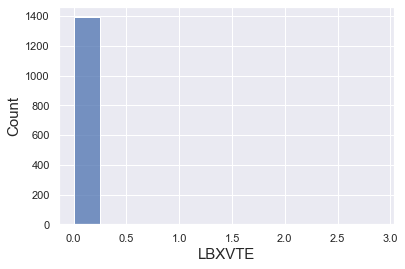

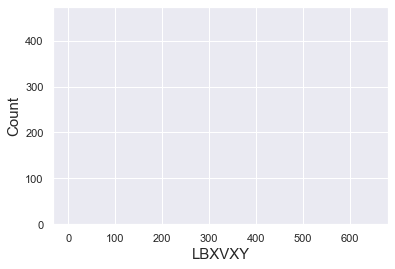

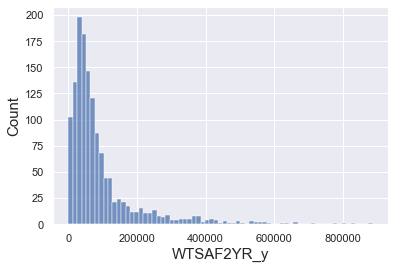

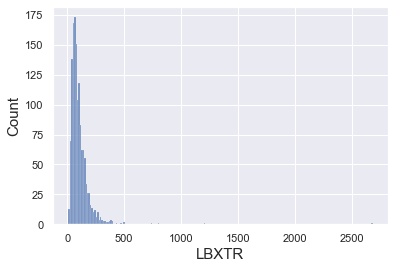

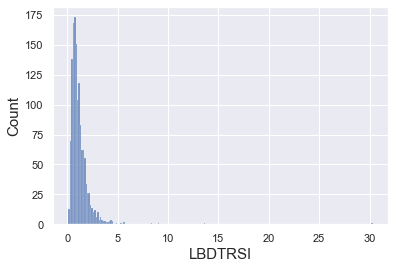

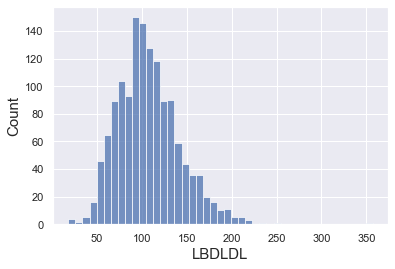

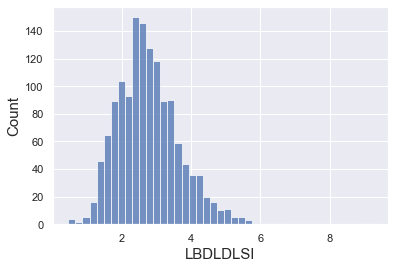

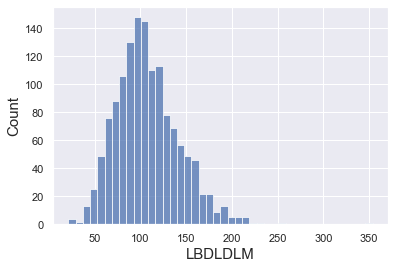

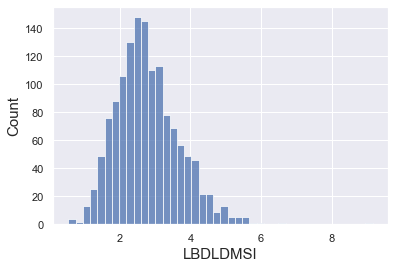

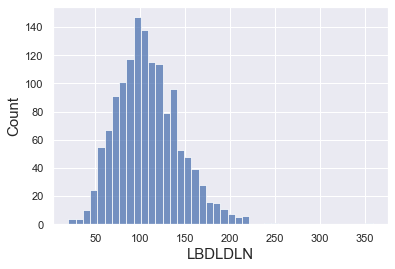

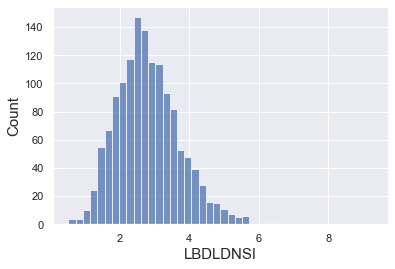

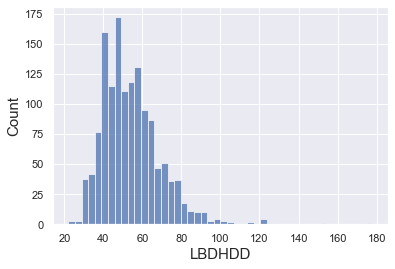

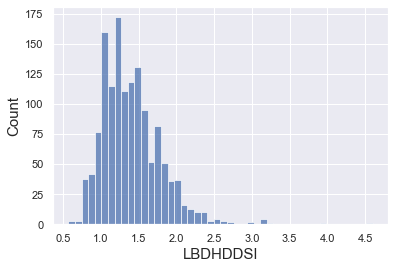

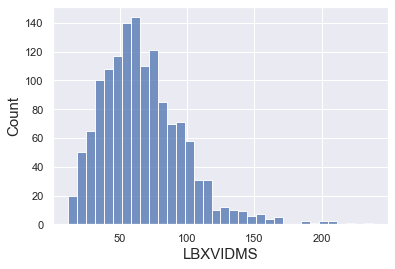

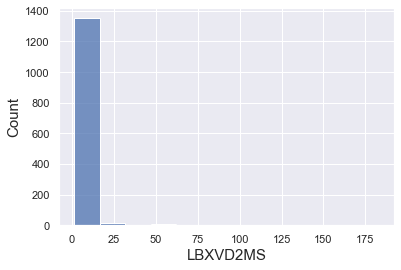

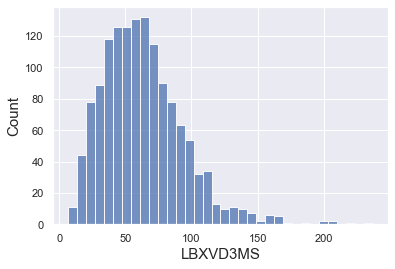

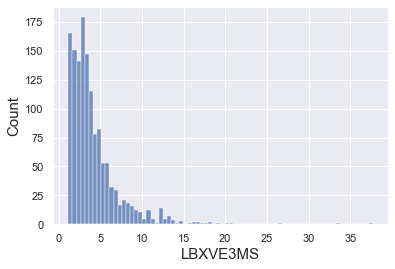

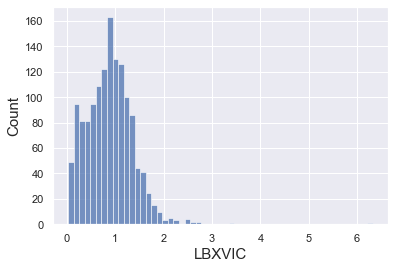

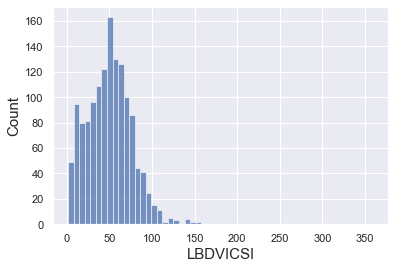

In [29]:
for i in numVars:
    plt.figure()
    sns.set(font_scale=1)
    sns.histplot(data=numlabdataimputed, x = i)
    plt.xlabel(i, fontsize=15)
    plt.ylabel("Count", fontsize=15)
    plt.show()

In [30]:
combinedLabDataImputed = pd.concat([numlabdataimputed, catlabdataimputed], axis=1)
combinedLabDataImputed = pd.concat([combinedLabDataImputed, ], axis=1)
combinedLabDataImputed = naFilter(combinedLabDataImputed.reset_index())
combinedLabDataImputed = combinedLabDataImputed.reset_index()
combinedLabDataImputed = naFilter(combinedLabDataImputed)
combinedLabDataImputed = combinedLabDataImputed.drop(['level_0', 'index'], axis = 1)

In [31]:
combinedLabDataImputed.info

<bound method DataFrame.info of       LBXWBCSI  LBXLYPCT  LBXMOPCT  LBXNEPCT  LBXEOPCT  LBXBAPCT  LBDLYMNO  \
0          6.0      31.3       6.8      59.4       2.0       0.7       1.9   
1          5.0      35.5      10.0      53.0       1.3       0.4       1.8   
2          6.2      44.0       6.0      46.9       2.7       0.5       2.7   
3          4.8      37.9       7.2      53.1       1.2       0.7       1.8   
4          8.8      24.9       9.4      61.4       3.3       1.0       2.2   
...        ...       ...       ...       ...       ...       ...       ...   
1270       7.1      36.2       5.9      55.2       2.0       0.9       2.6   
1271      16.3      18.2       5.6      75.5       0.5       0.3       3.0   
1272       7.0      35.5       5.4      53.2       5.3       0.8       2.5   
1273       5.2      32.1       6.1      57.8       3.0       1.1       1.7   
1274       9.0      29.4       6.9      58.8       4.0       1.0       2.6   

      LBDMONO  LBDNENO  LBDEONO

In [32]:
corrMatrix = combinedLabDataImputed.corr().abs()
upper = corrMatrix.where(np.triu(np.ones(corrMatrix.shape), k=1).astype(np.bool))
toDrop = [column for column in upper.columns if any(upper[column] > 0.9)]
combinedLabDataImputed.drop(toDrop, axis=1, inplace=True)

<ipython-input-32-16e6ec1781e6>:2: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  upper = corrMatrix.where(np.triu(np.ones(corrMatrix.shape), k=1).astype(np.bool))


In [33]:
# presplitting the data for final testing stage
combinedLabDataImputed, combinedLabDataImputed_final_test= train_test_split(combinedLabDataImputed, test_size=0.2, random_state=69)
combinedLabDataImputed = combinedLabDataImputed.reset_index().drop('index', axis=1)

In [34]:
print(combinedLabDataImputed.info)

<bound method DataFrame.info of       LBXWBCSI  LBXLYPCT  LBXMOPCT  LBXEOPCT  LBXBAPCT  LBDLYMNO  LBDMONO  \
0          6.9      28.6       5.7       1.9       0.9       2.0      0.4   
1          5.9      37.4       8.9       5.6       0.3       2.2      0.5   
2          4.5      37.7       7.9       2.5       1.1       1.7      0.4   
3          4.3      53.1      11.1       2.8       0.8       2.3      0.5   
4          5.3      21.1       6.3       1.6       0.8       1.1      0.3   
...        ...       ...       ...       ...       ...       ...      ...   
1015       5.5      36.8      10.5       0.9       0.4       2.0      0.6   
1016       4.6      19.0       6.6       2.7       0.9       0.9      0.3   
1017       4.5      16.5       8.4       3.8       1.5       0.7      0.4   
1018       5.8      27.1      10.1       4.4       0.8       1.6      0.6   
1019       4.0      39.0       9.2       2.2       1.0       1.6      0.4   

           LBDEONO  LBXRBCSI  LBXHGB  ...  

In [35]:
anemia = []
for i in range(len(combinedLabDataImputed)):
    if combinedLabDataImputed ['DMDHRGND'][i] == 1 and combinedLabDataImputed ['LBXHGB'][i] < 13:
        anemia.append('True')
    elif combinedLabDataImputed ['DMDHRGND'][i] == 2 and combinedLabDataImputed ['LBXHGB'][i] < 12:
        anemia.append('True')
    else:
        anemia.append('False')

In [36]:
combinedLabDataImputed_final_test = combinedLabDataImputed_final_test.reset_index().drop('index', axis=1)
combinedLabDataImputed_final_test.to_csv('combinedLabData.csv', sep=',', index=False, encoding='utf-8')

In [37]:
xtrain, xtest, ytrain, ytest = train_test_split(combinedLabDataImputed.drop(['LBXHGB'], axis=1), anemia, test_size=0.2, random_state=42)
categorical_transformer = Pipeline(
    steps=[("imputer", SimpleImputer(strategy="most_frequent"))]
)
numeric_transformer = Pipeline(
    steps=[("imputer", SimpleImputer(strategy="mean")), ("scaler", StandardScaler(with_mean=False))]
)
# alternative way of implementing imputers
# preprocessor = ColumnTransformer( 
#     transformers=[
#         ("num", numeric_transformer, numVars),
#         ("cat", categorical_transformer, catVars)]
# )

# 10% of the total variables will be selected
selection = SelectPercentile(chi2, percentile = 10)
pipe = Pipeline(
    steps = [("selection", selection), ("classifier", RandomForestClassifier())]
)

bestModel = pipe.fit(xtrain, ytrain)

In [38]:
preds = bestModel.predict(xtest)
accuracy_score(ytest, preds)

0.8529411764705882

In [39]:
importantFeats = pipe[:-1].get_feature_names_out()
importantFeats

array(['LBXMCVSI', 'LBXRDW', 'LBXPLTSI', 'LBXBSE', 'LBXBMN', 'WTSAF2YR_x',
       'LBXVEA', 'LBXVEB', 'LBXTR', 'LBDLDL', 'LBXVIDMS', 'LBXVD2MS'],
      dtype=object)

In [40]:
importantFeatsSig = bestModel.steps[1][1].feature_importances_

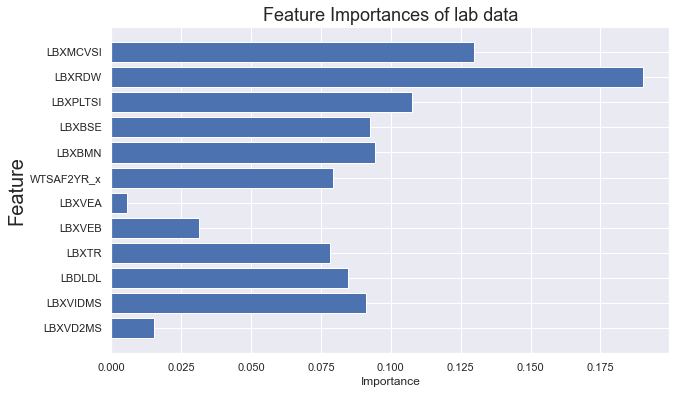

In [41]:
plt.figure(figsize=(10, 6))
plt.barh(importantFeats, importantFeatsSig)
sns.set(font_scale=1.5)
plt.xlabel('Importance', fontsize= 12)
plt.ylabel('Feature', fontsize= 20)
plt.title('Feature Importances of lab data')
plt.gca().invert_yaxis()
plt.show()

Printing out important feats

In [42]:
print(importantFeats)

['LBXMCVSI' 'LBXRDW' 'LBXPLTSI' 'LBXBSE' 'LBXBMN' 'WTSAF2YR_x' 'LBXVEA'
 'LBXVEB' 'LBXTR' 'LBDLDL' 'LBXVIDMS' 'LBXVD2MS']


In [43]:
for i in combinedLabDataImputed.drop(importantFeats, axis = 1).columns:
    print(i)

LBXWBCSI
LBXLYPCT
LBXMOPCT
LBXEOPCT
LBXBAPCT
LBDLYMNO
LBDMONO
LBDEONO
LBXRBCSI
LBXHGB
LBXMC
LBXMPSI
LBXBPB
LBXBCD
LBXTHG
LBXIHG
LBXIN
LBX2DF
LBXV08N
LBXV2A
LBXV4C
LBXVBF
LBXVBM
LBXVBZ
LBXVBZN
LBXVCF
LBXVCM
LBXVDB
LBXVFN
LBXVIBN
LBXVME
LBXVTE
LBDHDD
LBXVE3MS
LBXVIC
LBDBANO
LBXNRBC
DMDHRGND
LBDBPBLC
LBDBCDLC
LBDTHGLC
LBDBSELC
LBDBMNLC
LBDIHGLC
LBXBGE
LBDBGELC
LBDBGMLC
LBDINLC
LBD2DFLC
LBX4CE
LBD4CELC
LBXV06
LBXV07N
LBDV07LC
LBDV08LC
LBXV1D
LBDV1DLC
LBDV2ALC
LBXV3B
LBDV3BLC
LBDV4CLC
LBDVBFLC
LBDVBMLC
LBDVBZLC
LBDVZBLC
LBXVC6
LBDVC6LC
LBXVCB
LBDVCFLC
LBDVCMLC
LBXVCT
LBDVCTLC
LBDVDBLC
LBXVDE
LBDVDELC
LBXVDEE
LBDVEELC
LBDVEALC
LBDVEBLC
LBXVEC
LBDVFNLC
LBDVIBLC
LBDVIPLC
LBXVMC
LBDVMELC
LBDVMPLC
LBXVMIK
LBXVNB
LBDVNBLC
LBDVOXLC
LBXVTC
LBDVTCLC
LBDVTELC
LBXVTFT
LBDVFTLC
LBXVTHF
LBDVHTLC
LBXVTP
LBDVTPLC
LBXVVB
LBDVVBLC
LBDVXYLC
LBDVIDLC
LBDVD2LC
LBDVD3LC
LBDVE3LC
LBDVICLC


Visualising the correlation between important features

In [44]:
combinedLabDataImputed[importantFeats].describe()

LBXMCVSI       LBXRDW     LBXPLTSI       LBXBSE       LBXBMN  \
count  1020.000000  1020.000000  1020.000000  1020.000000  1020.000000   
mean     88.056765    13.880000   240.727451   190.443569    10.229083   
std       6.796256     1.388913    62.752503    24.980565     4.239070   
min      51.600000    11.800000    54.000000   104.730000     3.100000   
25%      85.075000    13.100000   197.750000   174.472500     7.487500   
50%      88.600000    13.600000   235.500000   188.385000     9.480000   
75%      92.400000    14.200000   277.000000   204.525000    11.842500   
max     113.100000    29.200000   517.000000   376.800000    52.000000   

         WTSAF2YR_x       LBXVEA       LBXVEB        LBXTR       LBDLDL  \
count  1.020000e+03  1020.000000  1020.000000  1020.000000  1020.000000   
mean   9.228762e+04     0.228375     0.164693   108.865686   107.344118   
std    1.060887e+05     1.967556     4.194907   111.403679    33.614571   
min    5.397605e-79     0.112000     0.017000    10.000000    18.000000   
25%    3.261719e+04     0.112000     0.017000    59.000000    84.000000   
50%    5.738817e+04     0.112000     0.017000    86.000000   104.000000   
75%    1.030476e+05     0.112000     0.028000   133.000000   128.000000   
max    8.865433e+05    48.800000   134.000000  2684.000000   217.000000   

          LBXVIDMS     LBXVD2MS  
count  1020.000000  1020.000000  
mean     67.115196     3.593578  
std      31.615138    11.698233  
min      11.400000     1.450000  
25%      45.050000     1.450000  
50%      61.850000     1.450000  
75%      83.650000     1.450000  
max     238.000000   183.000000

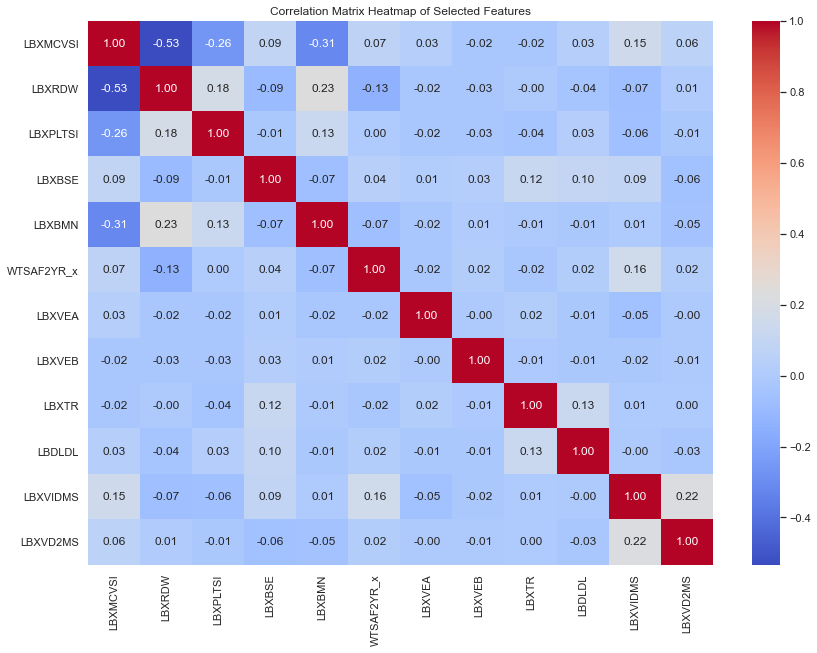

In [45]:
# Drawing the correlation heatmap
corrMatrix = combinedLabDataImputed[importantFeats].corr()
plt.figure(figsize=(14, 10))
sns.set(font_scale=1)
sns.heatmap(corrMatrix, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Correlation Matrix Heatmap of Selected Features')
plt.show()

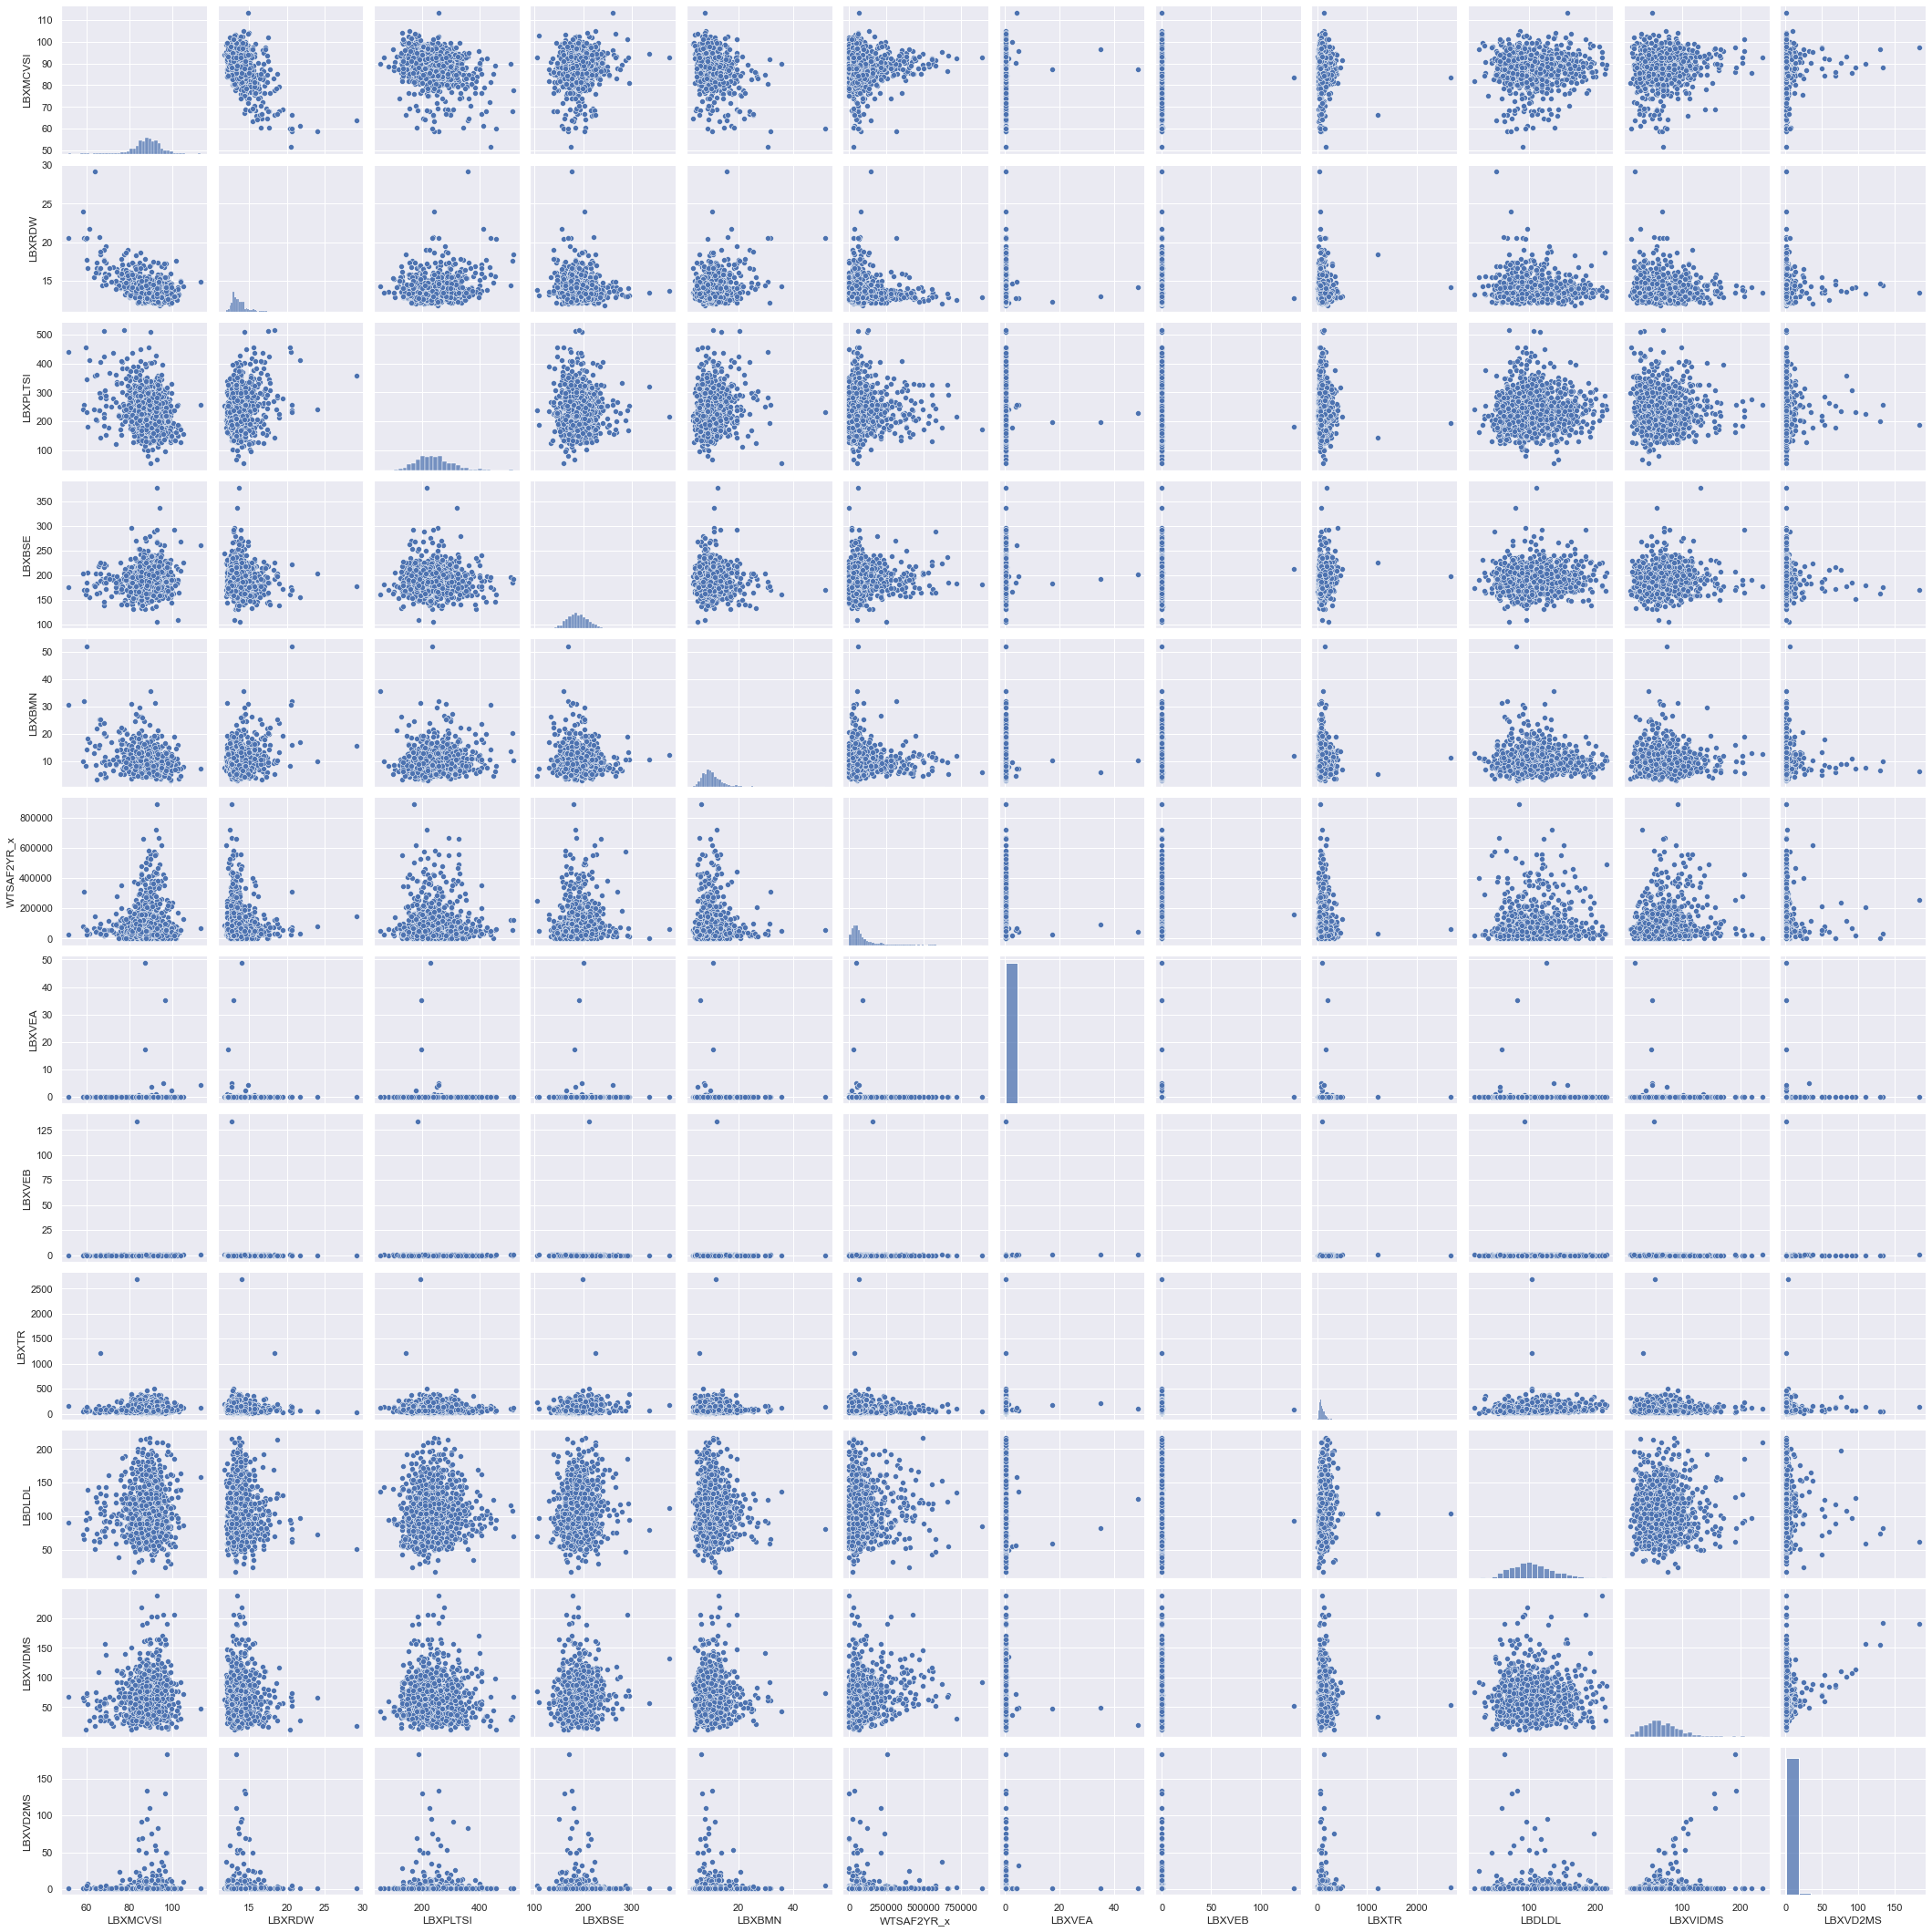

In [46]:
sns.pairplot(combinedLabDataImputed[importantFeats])

# Demographic and Environmental data

In [47]:
# Read Complete Blood Count (CBC) 2017-2018
with open('2017-2018/CBC_J.XPT', 'rb') as f:
    df_cbc = pd.read_sas(f, format='xport')
df_cbc.to_csv('df_cbc.csv', index=False)

# Read Demographics (DEMO) 2017-2018
with open('2017-2018/DEMO_J.XPT', 'rb') as f:
    df_demo = pd.read_sas(f, format='xport')
df_demo.to_csv('df_demo.csv', index=False) 

# Read Dietary Interview, Total Nutrient Intakes (DR1TOT) 2017-2018
with open('2017-2018/DR1TOT_J.XPT', 'rb') as f:
    df_dr1tot = pd.read_sas(f, format='xport')
df_dr1tot.to_csv('df_dr1tot.csv', index=False)

# Read Biochemistry profile 2017-2018
with open('2017-2018/BIOPRO_J.XPT', 'rb') as f:
    df_biopro = pd.read_sas(f, format='xport')
df_biopro.to_csv('df_biopro.csv', index=False)

# Read Medical Conditions (MCQ) 2017-2018
with open('2017-2018/MCQ_J.XPT', 'rb') as f:
    df_mcq = pd.read_sas(f, format='xport')
df_mcq.to_csv('df_mcq.csv', index=False)

# Read Physical Activity (PAQ) 2017-2018
with open('2017-2018/PAQ_J.XPT', 'rb') as f:
    df_paq = pd.read_sas(f, format='xport')
df_paq.to_csv('df_paq.csv', index=False)

# Read Body Measurements (BMX) 2017-2018
with open('2017-2018/BMX_J.XPT', 'rb') as f:
    df_bmx = pd.read_sas(f, format='xport')
df_bmx.to_csv('df_bmx.csv', index=False)

C:\Users\dl668\anaconda3\lib\site-packages\pandas\io\sas\sas_xport.py:475: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  df[x] = v


In [48]:
cbc_data = pd.read_csv('df_cbc.csv')
print("CBC Data:")
print(cbc_data.head(3))

# Reading Demographics (DEMO) 2017-2018
demo_data = pd.read_csv('df_demo.csv')
print("\nDemographics Data:")
print(demo_data.head(3))

# Reading Dietary Interview, Total Nutrient Intakes (DR1TOT) 2017-2018
dietary_data = pd.read_csv('df_dr1tot.csv')
print("\nDietary Data:")
print(dietary_data.head(3))

# Reading Blood Pressure (BIOPRO) 2017-2018
biopro_data = pd.read_csv('df_biopro.csv')
print("\nBlood Pressure Data:")
print(biopro_data.head(3))

# Reading Medical Conditions (MCQ) 2017-2018
medical_conditions_data = pd.read_csv('df_mcq.csv')
print("\nMedical Conditions Data:")
print(medical_conditions_data.head(3))

# Reading Physical Activity (PAQ) 2017-2018
physical_activity_data = pd.read_csv('df_paq.csv')
print("\nPhysical Activity Data:")
print(physical_activity_data.head(3))

# Reading Body Measurements (BMX) 2017-2018
body_measurements_data = pd.read_csv('df_bmx.csv')
print("\nBody Measurements Data:")
print(body_measurements_data.head(3))

CBC Data:
      SEQN  LBXWBCSI  LBXLYPCT  LBXMOPCT  LBXNEPCT  LBXEOPCT  LBXBAPCT  \
0  93703.0       NaN       NaN       NaN       NaN       NaN       NaN   
1  93704.0       7.4      47.8       8.0      42.6       1.0       0.7   
2  93705.0       8.6      40.0       7.4      48.8       2.9       1.0   

   LBDLYMNO  LBDMONO  LBDNENO  ...  LBXRBCSI  LBXHGB  LBXHCT  LBXMCVSI  \
0       NaN      NaN      NaN  ...       NaN     NaN     NaN       NaN   
1       3.5      0.6      3.2  ...      4.25    13.1    37.0      87.0   
2       3.4      0.6      4.2  ...      5.48    11.9    36.7      67.0   

   LBXMCHSI  LBXMC  LBXRDW  LBXPLTSI  LBXMPSI       LBXNRBC  
0       NaN    NaN     NaN       NaN      NaN           NaN  
1      30.8   35.4    12.8     239.0      8.6  1.000000e-01  
2      21.7   32.4    15.6     309.0      7.9  5.397605e-79  

[3 rows x 22 columns]

Demographics Data:
      SEQN  SDDSRVYR  RIDSTATR  RIAGENDR  RIDAGEYR  RIDAGEMN  RIDRETH1  \
0  93703.0      10.0       2.0 

In [49]:
# Assuming the common identifier is 'SEQN'
combined_data = pd.merge(cbc_data, demo_data, on='SEQN', how='inner')
combined_data = pd.merge(combined_data, dietary_data, on='SEQN', how='inner')
combined_data = pd.merge(combined_data, biopro_data, on='SEQN', how='inner')
combined_data = pd.merge(combined_data, medical_conditions_data, on='SEQN', how='inner')
combined_data = pd.merge(combined_data, physical_activity_data, on='SEQN', how='inner')
combined_data = pd.merge(combined_data, body_measurements_data, on='SEQN', how='inner')
#Summary statistics 
display(combined_data.describe().round(2)) 

SEQN  LBXWBCSI  LBXLYPCT  LBXMOPCT  LBXNEPCT  LBXEOPCT  LBXBAPCT  \
count    5533.00   5271.00   5267.00   5267.00   5267.00   5267.00   5267.00   
mean    98275.67      7.36     31.24      8.19     57.09      2.81      0.79   
std      2685.59      5.93      8.88      2.25      9.56      2.10      0.34   
min     93705.00      1.90      5.00      0.70      8.40      0.00      0.10   
25%     95945.00      5.70     25.10      6.70     51.00      1.50      0.60   
50%     98257.00      7.00     30.80      8.00     57.50      2.30      0.70   
75%    100590.00      8.50     36.75      9.30     63.50      3.50      1.00   
max    102956.00    400.00     89.70     57.20     92.80     27.40      4.80   

       LBDLYMNO  LBDMONO  LBDNENO  ...   BMXLEG  BMILEG  BMXARML  BMIARML  \
count   5267.00  5267.00  5267.00  ...  5167.00   284.0  5251.00    199.0   
mean       2.30     0.58     4.24  ...    39.07     1.0    37.33      1.0   
std        5.09     0.22     1.73  ...     3.87     0.0     2.84      0.0   
min        0.40     0.10     0.40  ...    25.00     1.0    28.50      1.0   
25%        1.70     0.50     3.10  ...    36.40     1.0    35.30      1.0   
50%        2.10     0.60     4.00  ...    39.00     1.0    37.20      1.0   
75%        2.60     0.70     5.10  ...    41.70     1.0    39.30      1.0   
max      358.80     6.70    35.20  ...    52.50     1.0    49.90      1.0   

       BMXARMC  BMIARMC  BMXWAIST  BMIWAIST   BMXHIP  BMIHIP  
count  5249.00    200.0   5184.00     265.0  5198.00   251.0  
mean     33.31      1.0    100.16       1.0   106.80     1.0  
std       5.33      0.0     17.22       0.0    14.59     0.0  
min      17.90      1.0     56.40       1.0    74.70     1.0  
25%      29.50      1.0     87.90       1.0    96.60     1.0  
50%      32.90      1.0     98.90       1.0   104.20     1.0  
75%      36.60      1.0    110.70       1.0   114.10     1.0  
max      56.30      1.0    169.50       1.0   179.00     1.0  

[8 rows x 385 columns]

In [50]:
# Calculate the threshold for half of the instances
threshold = len(combined_data) / 2

# Drop columns where number of non-NA values is less than the threshold
combined_data.dropna(thresh=threshold, axis=1, inplace=True)

combined_data

SEQN  LBXWBCSI  LBXLYPCT  LBXMOPCT  LBXNEPCT  LBXEOPCT  LBXBAPCT  \
0      93705.0       8.6      40.0       7.4      48.8       2.9       1.0   
1      93706.0       6.1      24.6       9.1      61.4       4.3       0.8   
2      93708.0       6.0      31.3       6.8      59.4       2.0       0.7   
3      93709.0       7.2      25.8       6.8      66.1       0.8       0.6   
4      93711.0       5.0      35.5      10.0      53.0       1.3       0.4   
...        ...       ...       ...       ...       ...       ...       ...   
5528  102949.0       9.0      29.8       8.8      59.0       2.2       0.4   
5529  102952.0       5.1      34.9       7.1      56.2       1.3       0.6   
5530  102953.0       8.3      28.3       6.8      60.8       3.6       0.6   
5531  102954.0       5.1      43.5      11.8      39.9       3.5       1.4   
5532  102956.0       9.0      29.4       6.9      58.8       4.0       1.0   

      LBDLYMNO  LBDMONO  LBDNENO  ...  PAD680  BMDSTATS  BMXWT  BMXHT  BMXBMI  \
0          3.4      0.6      4.2  ...   300.0       1.0   79.5  158.3    31.7   
1          1.5      0.6      3.7  ...   240.0       1.0   66.3  175.7    21.5   
2          1.9      0.4      3.6  ...   120.0       1.0   53.5  150.2    23.7   
3          1.9      0.5      4.8  ...   600.0       1.0   88.8  151.1    38.9   
4          1.8      0.5      2.7  ...   420.0       1.0   62.1  170.6    21.3   
...        ...      ...      ...  ...     ...       ...    ...    ...     ...   
5528       2.7      0.8      5.3  ...    60.0       1.0   76.9  180.1    23.7   
5529       1.8      0.4      2.9  ...   120.0       1.0   49.0  156.5    20.0   
5530       2.3      0.6      5.0  ...   360.0       1.0   97.4  164.9    35.8   
5531       2.2      0.6      2.0  ...   600.0       1.0   69.1  162.6    26.1   
5532       2.6      0.6      5.3  ...   720.0       1.0  111.5  175.8    36.1   

      BMXLEG  BMXARML  BMXARMC  BMXWAIST  BMXHIP  
0       37.0     36.0     32.0     101.8   110.0  
1       46.6     38.8     27.0      79.3    94.4  
2       31.8     30.6     27.4      88.2    90.1  
3       31.9     36.0     38.1     113.0   131.3  
4       40.1     37.2     30.8      86.6    90.7  
...      ...      ...      ...       ...     ...  
5528    45.2     41.0     32.9      85.5    98.0  
5529    34.4     32.6     25.1      82.2    87.3  
5530    38.2     36.6     40.6     114.8   112.8  
5531    39.2     35.2     26.8      86.4   102.7  
5532    42.5     38.0     40.0     122.0   110.0  

[5533 rows x 259 columns]

In [51]:
# Remove rows where 'MCQ053' is either 7 or 9
combined_data = combined_data[combined_data['MCQ053'].isin([1, 2]) == True]

combined_data

SEQN  LBXWBCSI  LBXLYPCT  LBXMOPCT  LBXNEPCT  LBXEOPCT  LBXBAPCT  \
0      93705.0       8.6      40.0       7.4      48.8       2.9       1.0   
1      93706.0       6.1      24.6       9.1      61.4       4.3       0.8   
2      93708.0       6.0      31.3       6.8      59.4       2.0       0.7   
3      93709.0       7.2      25.8       6.8      66.1       0.8       0.6   
4      93711.0       5.0      35.5      10.0      53.0       1.3       0.4   
...        ...       ...       ...       ...       ...       ...       ...   
5528  102949.0       9.0      29.8       8.8      59.0       2.2       0.4   
5529  102952.0       5.1      34.9       7.1      56.2       1.3       0.6   
5530  102953.0       8.3      28.3       6.8      60.8       3.6       0.6   
5531  102954.0       5.1      43.5      11.8      39.9       3.5       1.4   
5532  102956.0       9.0      29.4       6.9      58.8       4.0       1.0   

      LBDLYMNO  LBDMONO  LBDNENO  ...  PAD680  BMDSTATS  BMXWT  BMXHT  BMXBMI  \
0          3.4      0.6      4.2  ...   300.0       1.0   79.5  158.3    31.7   
1          1.5      0.6      3.7  ...   240.0       1.0   66.3  175.7    21.5   
2          1.9      0.4      3.6  ...   120.0       1.0   53.5  150.2    23.7   
3          1.9      0.5      4.8  ...   600.0       1.0   88.8  151.1    38.9   
4          1.8      0.5      2.7  ...   420.0       1.0   62.1  170.6    21.3   
...        ...      ...      ...  ...     ...       ...    ...    ...     ...   
5528       2.7      0.8      5.3  ...    60.0       1.0   76.9  180.1    23.7   
5529       1.8      0.4      2.9  ...   120.0       1.0   49.0  156.5    20.0   
5530       2.3      0.6      5.0  ...   360.0       1.0   97.4  164.9    35.8   
5531       2.2      0.6      2.0  ...   600.0       1.0   69.1  162.6    26.1   
5532       2.6      0.6      5.3  ...   720.0       1.0  111.5  175.8    36.1   

      BMXLEG  BMXARML  BMXARMC  BMXWAIST  BMXHIP  
0       37.0     36.0     32.0     101.8   110.0  
1       46.6     38.8     27.0      79.3    94.4  
2       31.8     30.6     27.4      88.2    90.1  
3       31.9     36.0     38.1     113.0   131.3  
4       40.1     37.2     30.8      86.6    90.7  
...      ...      ...      ...       ...     ...  
5528    45.2     41.0     32.9      85.5    98.0  
5529    34.4     32.6     25.1      82.2    87.3  
5530    38.2     36.6     40.6     114.8   112.8  
5531    39.2     35.2     26.8      86.4   102.7  
5532    42.5     38.0     40.0     122.0   110.0  

[5521 rows x 259 columns]

In [52]:
# Separating numerical and categorical columns
numerical_cols = [col for col in combined_data.columns if ('LBX' in col or 'BMX' in col or 'LBD' in col)]
categorical_cols = [col for col in combined_data.columns if ('MCQ' in col or 'PAQ' in col or 'OSQ' in col or 'BMDSTATS' in col)]

# Adding 'SEQN' to both lists as it is common in both and is more of an identifier
numerical_cols.append('SEQN')
categorical_cols.append('SEQN')

# Create datasets using the separated columns
numerical_data = combined_data[numerical_cols]
categorical_data = combined_data[categorical_cols]

print(numerical_data)
print(categorical_data)

      LBXWBCSI  LBXLYPCT  LBXMOPCT  LBXNEPCT  LBXEOPCT  LBXBAPCT  LBDLYMNO  \
0          8.6      40.0       7.4      48.8       2.9       1.0       3.4   
1          6.1      24.6       9.1      61.4       4.3       0.8       1.5   
2          6.0      31.3       6.8      59.4       2.0       0.7       1.9   
3          7.2      25.8       6.8      66.1       0.8       0.6       1.9   
4          5.0      35.5      10.0      53.0       1.3       0.4       1.8   
...        ...       ...       ...       ...       ...       ...       ...   
5528       9.0      29.8       8.8      59.0       2.2       0.4       2.7   
5529       5.1      34.9       7.1      56.2       1.3       0.6       1.8   
5530       8.3      28.3       6.8      60.8       3.6       0.6       2.3   
5531       5.1      43.5      11.8      39.9       3.5       1.4       2.2   
5532       9.0      29.4       6.9      58.8       4.0       1.0       2.6   

      LBDMONO  LBDNENO  LBDEONO  ...  LBDSUASI  BMXWT  BMXHT  B

In [53]:
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler

# Create an imputer object with a median filling strategy
imputer_num = SimpleImputer(strategy='median')

# Apply the imputer to the numerical data
numerical_data_imputed = pd.DataFrame(imputer_num.fit_transform(numerical_data), columns=numerical_data.columns)

# Impute missing values with the mode for each column
categorical_data_imputed = categorical_data.apply(lambda x: x.fillna(x.mode()[0]), axis=0)

print(numerical_data_imputed) #no scaling 
print(categorical_data_imputed)

      LBXWBCSI  LBXLYPCT  LBXMOPCT  LBXNEPCT  LBXEOPCT  LBXBAPCT  LBDLYMNO  \
0          8.6      40.0       7.4      48.8       2.9       1.0       3.4   
1          6.1      24.6       9.1      61.4       4.3       0.8       1.5   
2          6.0      31.3       6.8      59.4       2.0       0.7       1.9   
3          7.2      25.8       6.8      66.1       0.8       0.6       1.9   
4          5.0      35.5      10.0      53.0       1.3       0.4       1.8   
...        ...       ...       ...       ...       ...       ...       ...   
5516       9.0      29.8       8.8      59.0       2.2       0.4       2.7   
5517       5.1      34.9       7.1      56.2       1.3       0.6       1.8   
5518       8.3      28.3       6.8      60.8       3.6       0.6       2.3   
5519       5.1      43.5      11.8      39.9       3.5       1.4       2.2   
5520       9.0      29.4       6.9      58.8       4.0       1.0       2.6   

      LBDMONO  LBDNENO  LBDEONO  ...  LBDSUASI  BMXWT  BMXHT  B

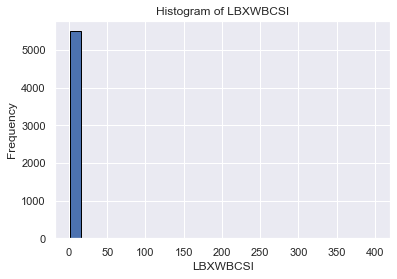

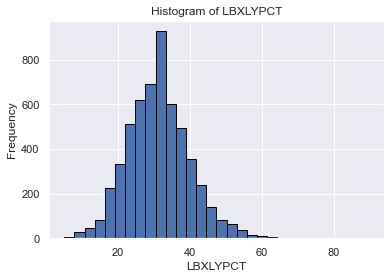

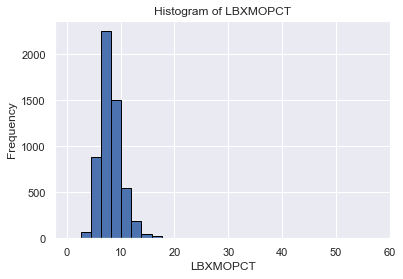

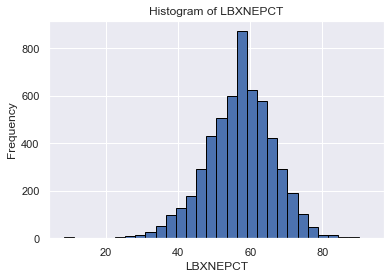

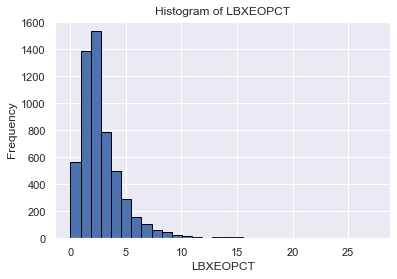

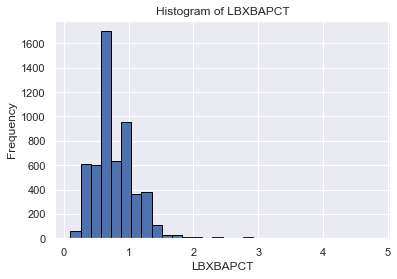

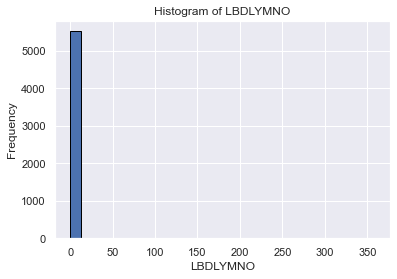

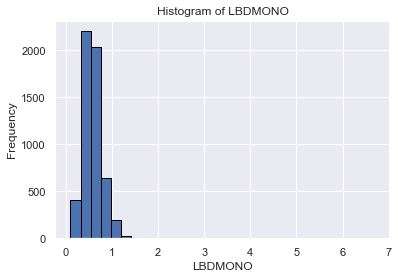

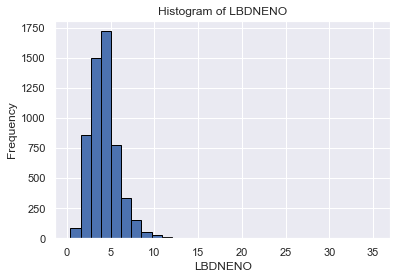

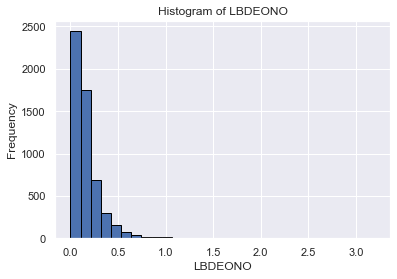

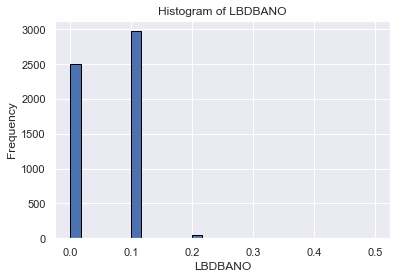

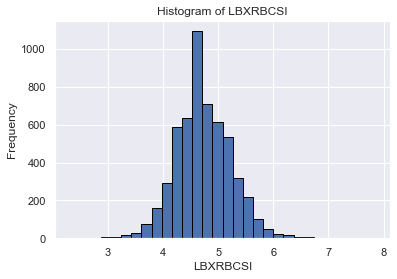

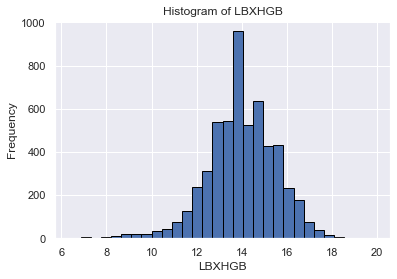

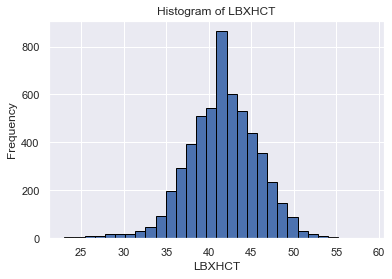

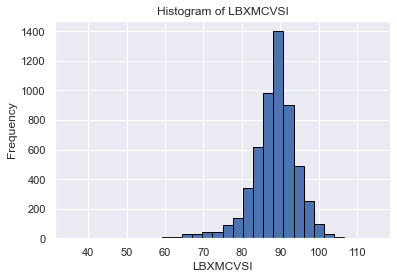

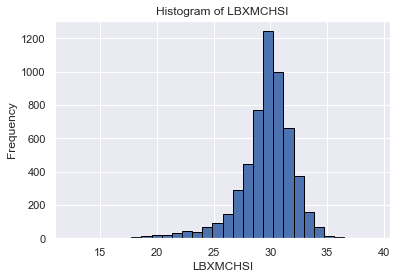

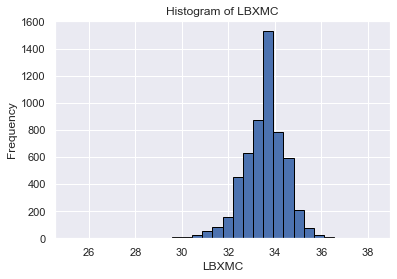

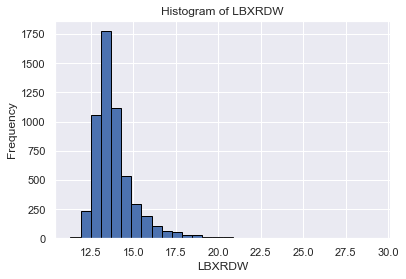

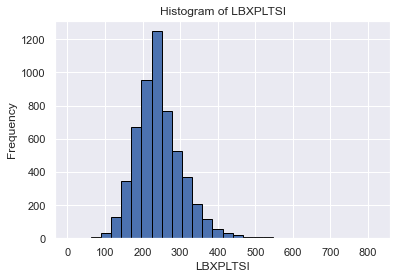

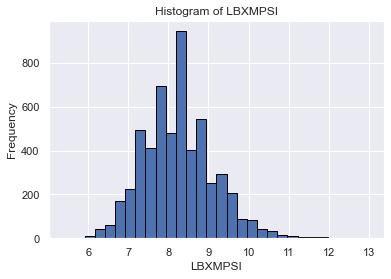

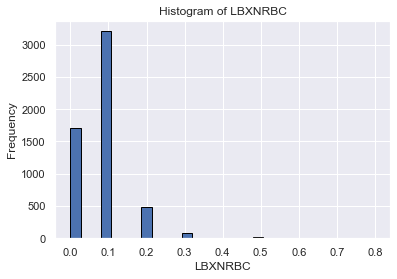

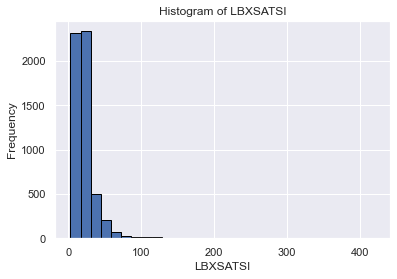

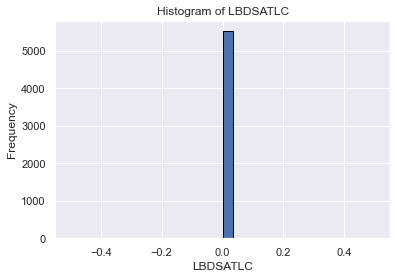

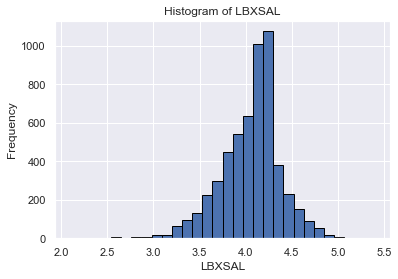

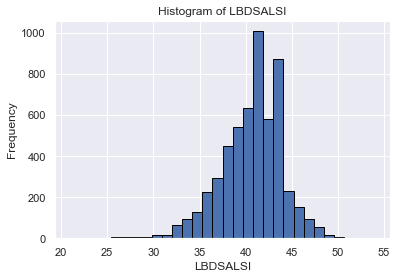

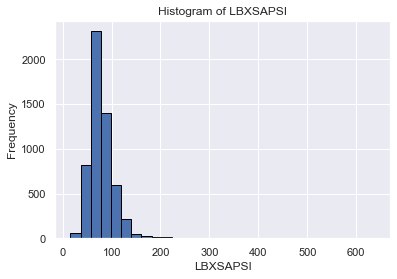

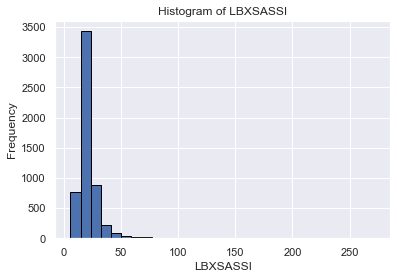

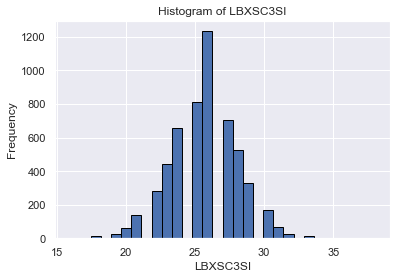

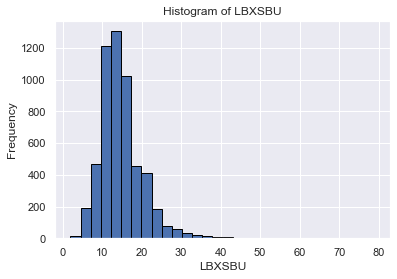

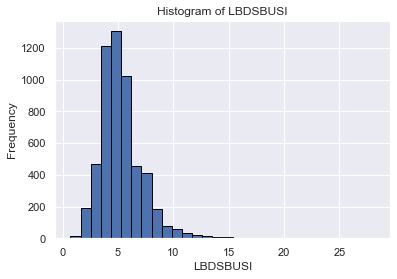

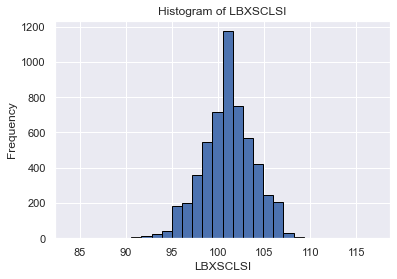

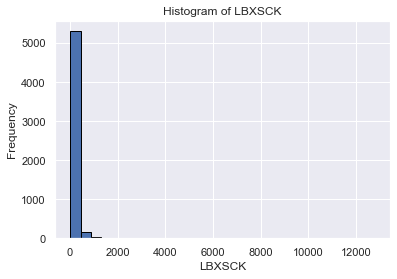

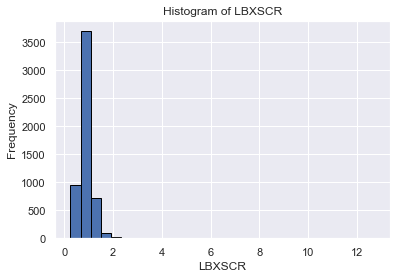

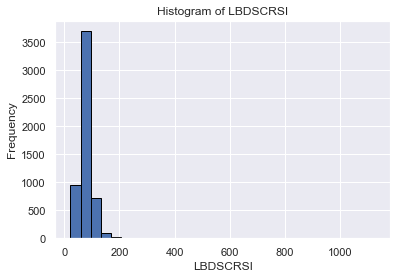

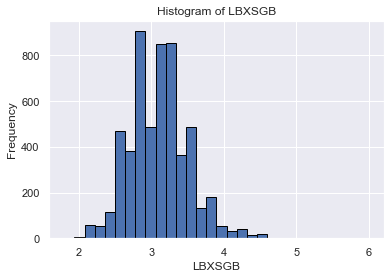

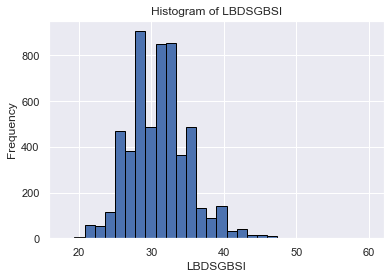

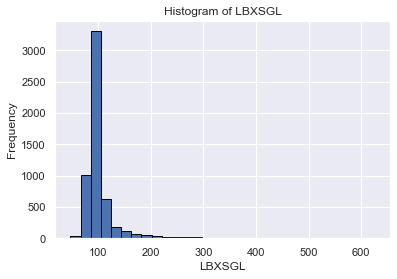

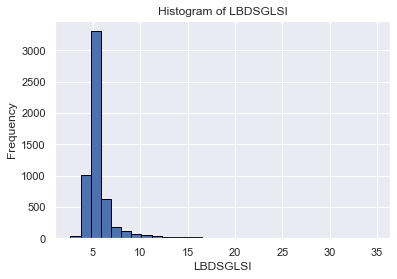

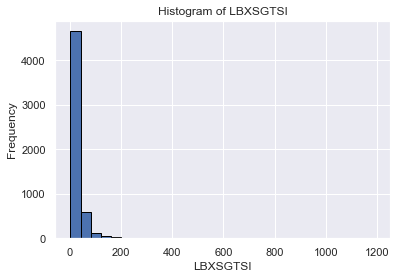

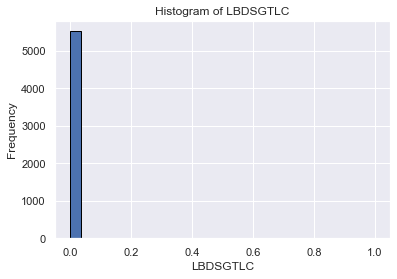

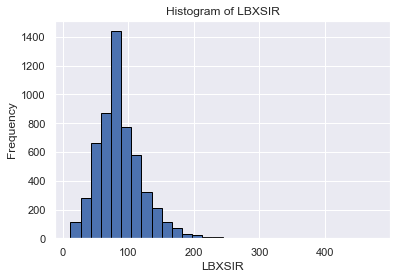

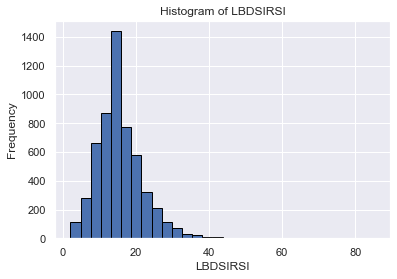

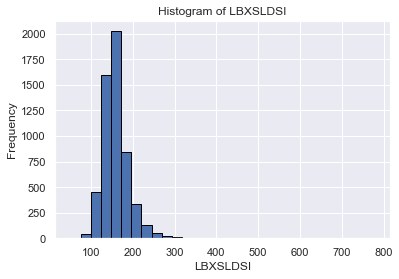

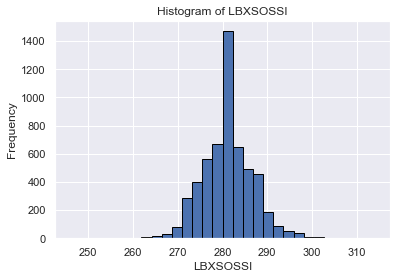

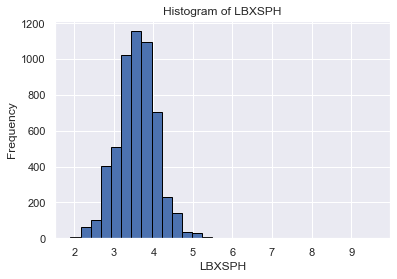

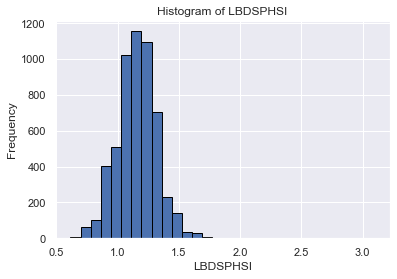

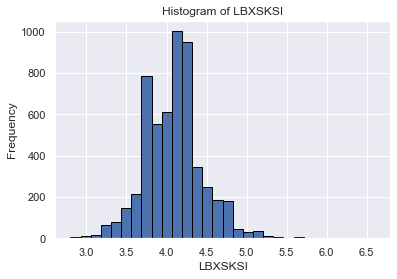

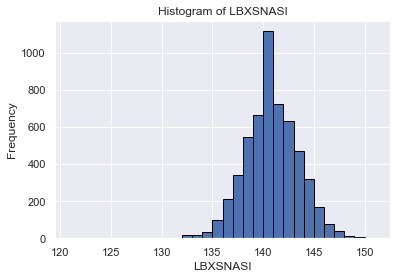

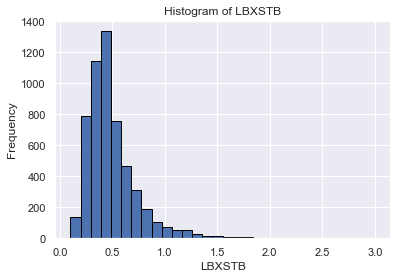

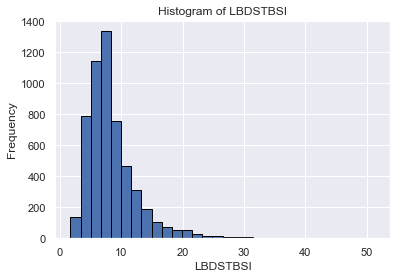

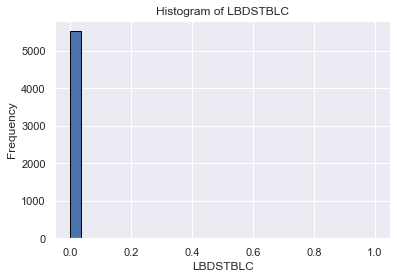

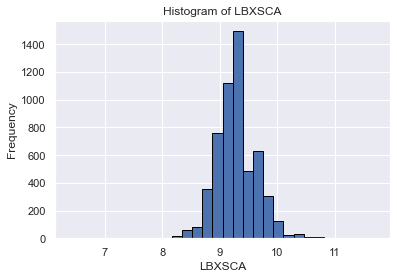

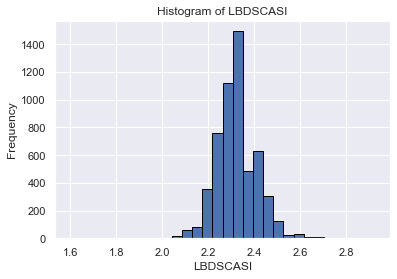

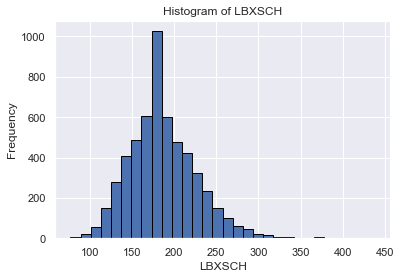

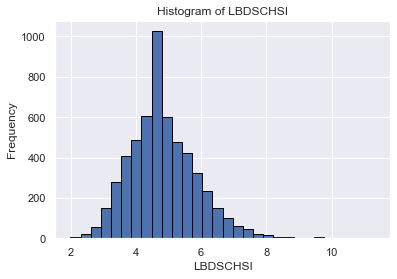

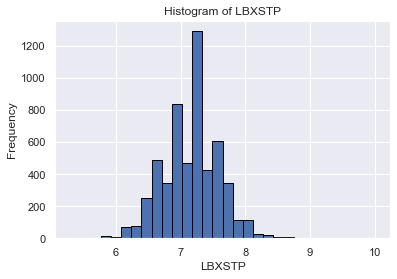

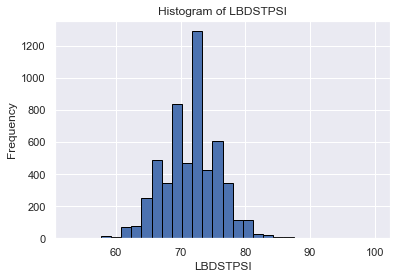

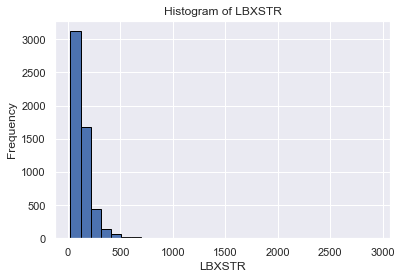

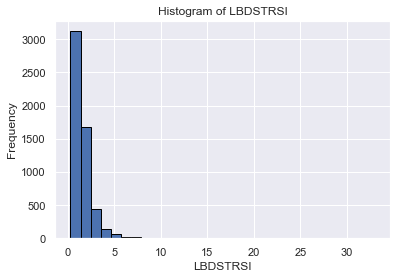

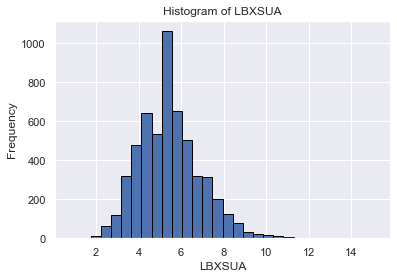

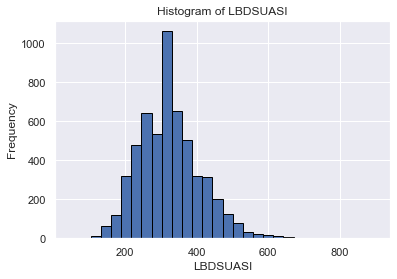

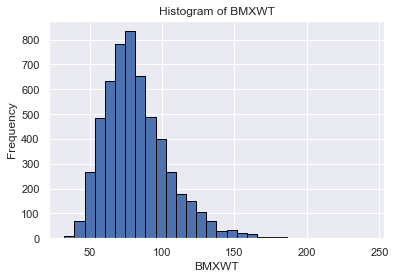

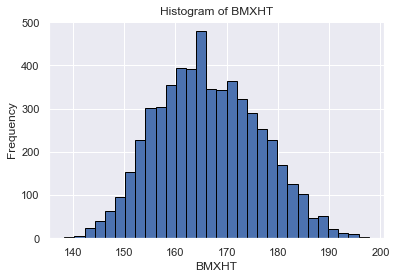

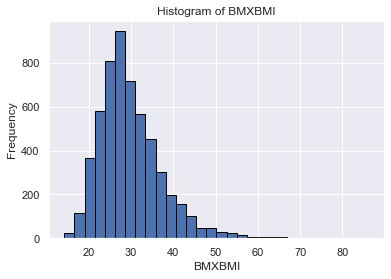

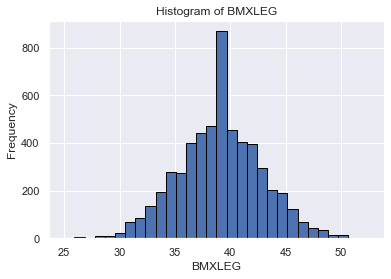

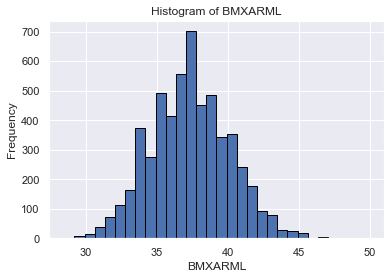

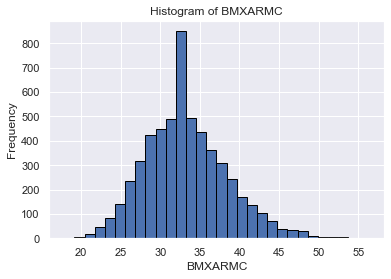

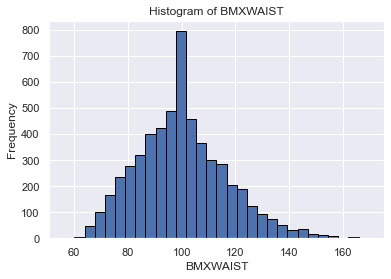

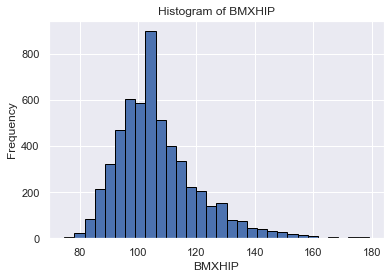

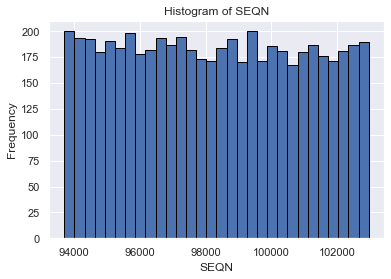

In [54]:
import matplotlib.pyplot as plt

# Loop through each numerical column and plot a histogram
for column in numerical_data_imputed.columns:
    plt.figure()
    plt.hist(numerical_data_imputed[column], bins=30, edgecolor='black')
    plt.title(f"Histogram of {column}")
    plt.xlabel(column)
    plt.ylabel("Frequency")
    plt.show()


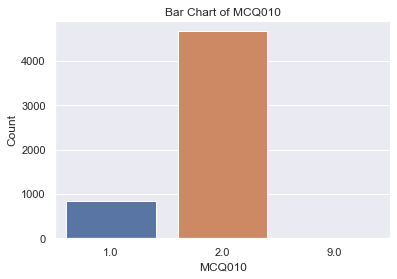

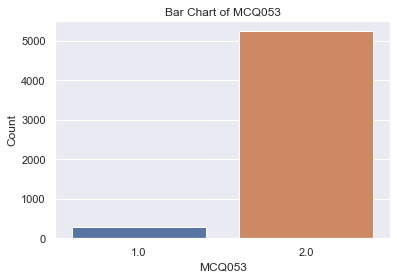

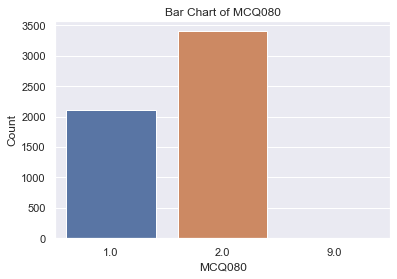

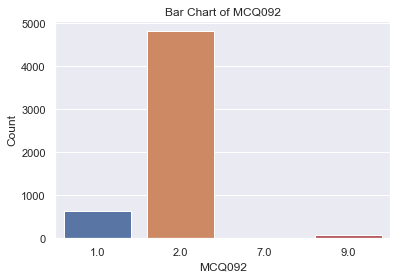

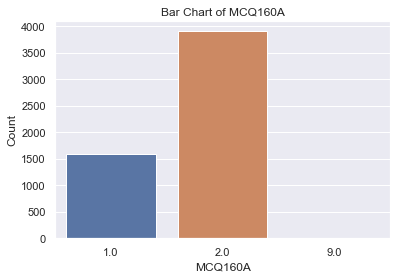

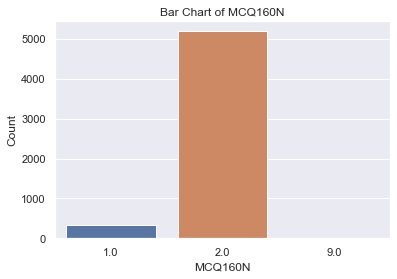

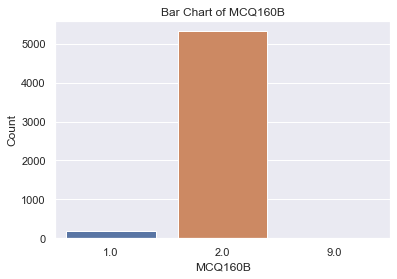

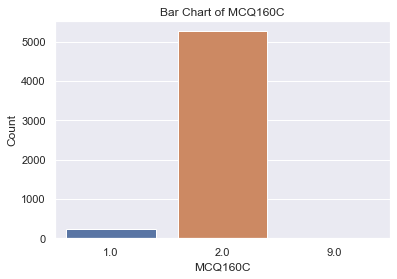

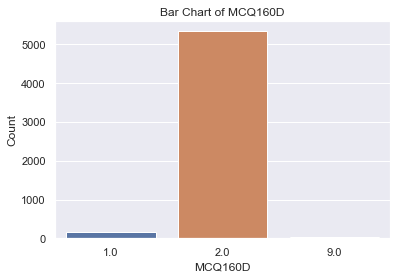

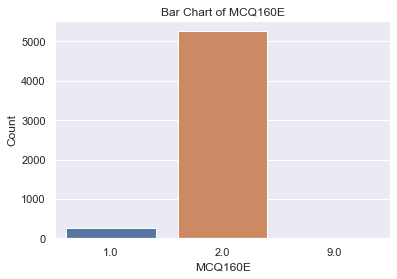

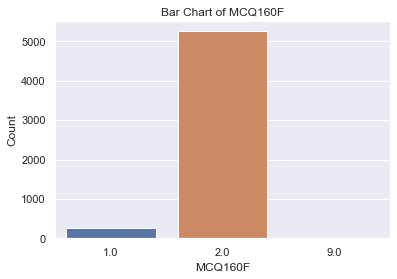

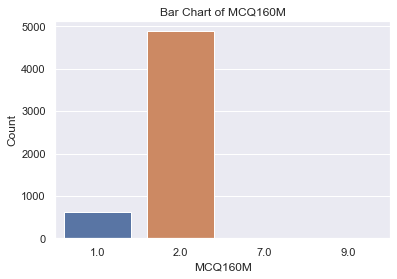

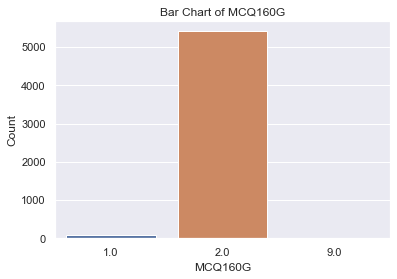

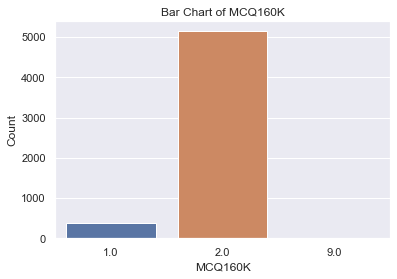

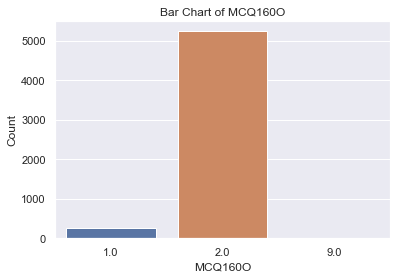

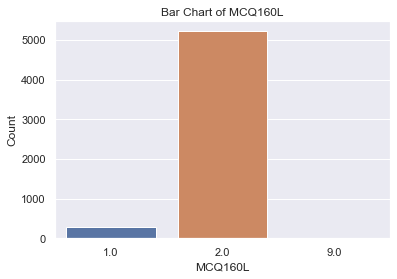

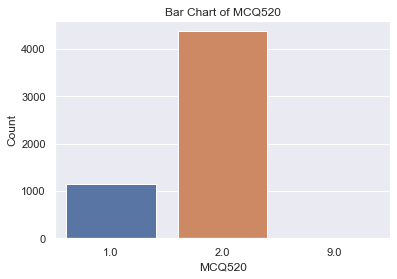

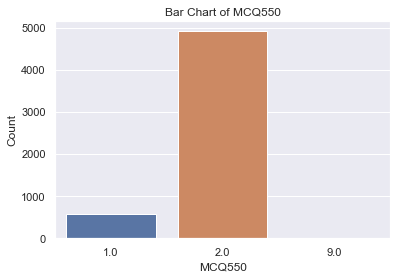

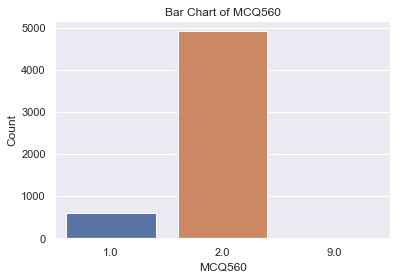

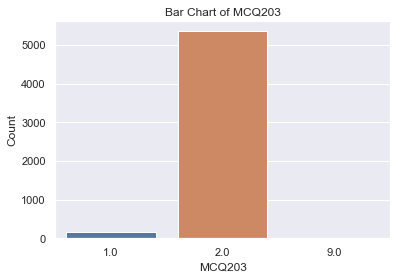

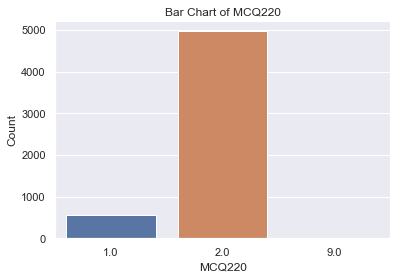

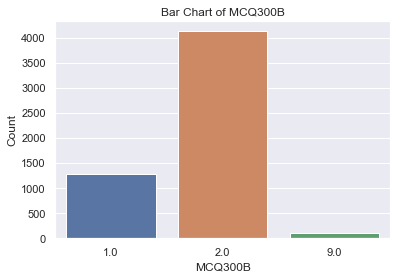

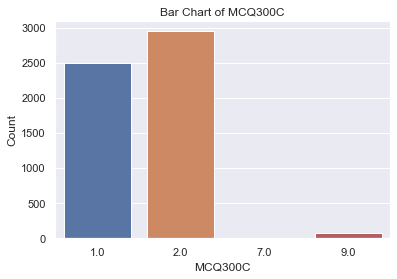

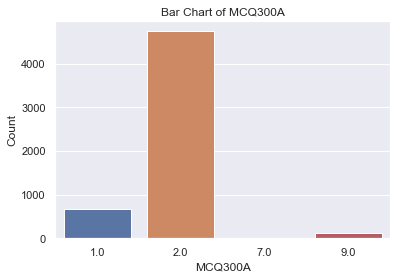

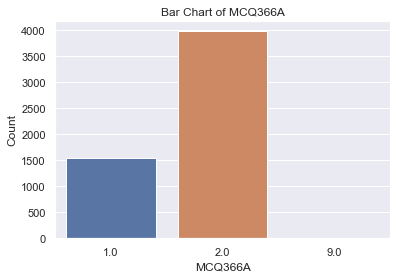

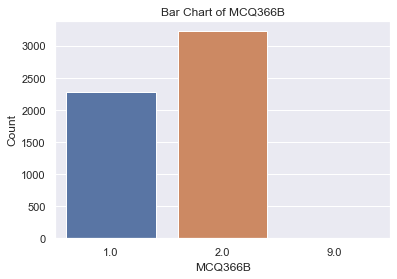

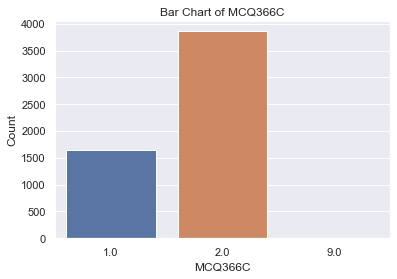

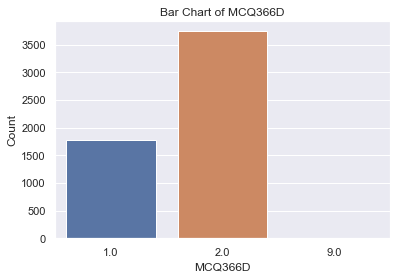

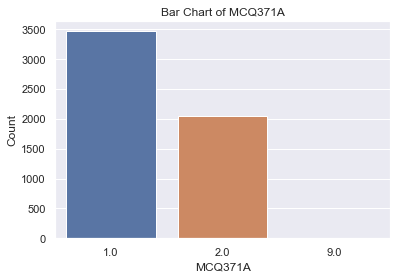

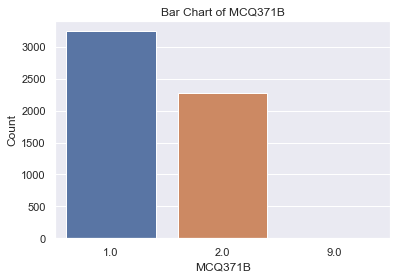

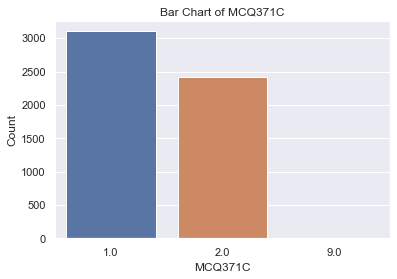

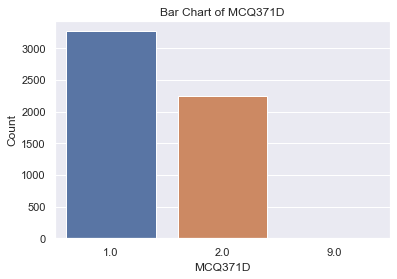

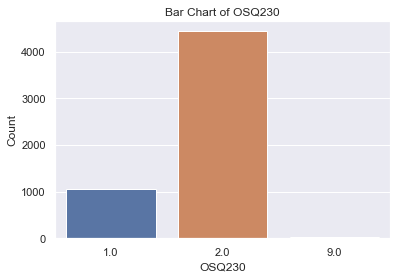

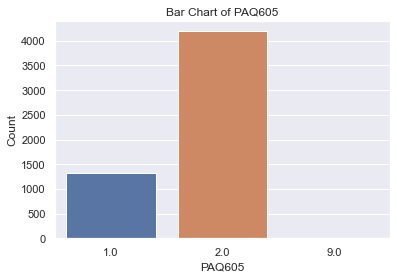

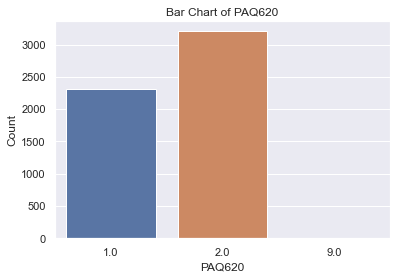

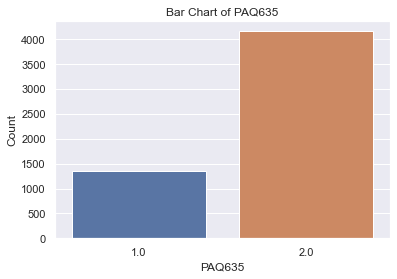

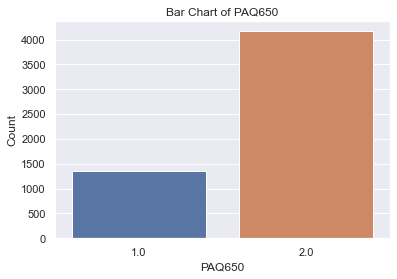

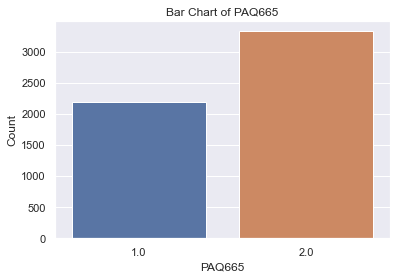

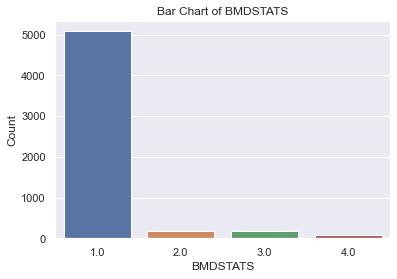

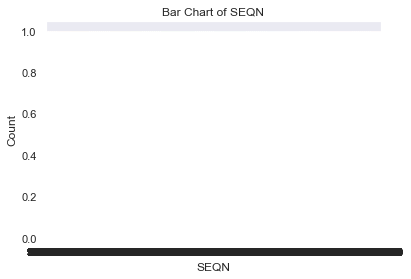

In [55]:
import seaborn as sns

# Loop through each categorical column and plot a bar chart
for column in categorical_data_imputed.columns:
    plt.figure()
    sns.countplot(data=categorical_data_imputed, x=column)
    plt.title(f"Bar Chart of {column}")
    plt.xlabel(column)
    plt.ylabel("Count")
    plt.show()


In [58]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
import pandas as pd

# Function to diagnose anemia
def diagnose_anemia(rbc, hgb, hct):
    if rbc < 4.5 or hgb < 12 or hct < 36:
        return 1
    else:
        return 0

# Assuming numerical_data_imputed and categorical_data_imputed already exist
# Re-create the Anemia column after imputation
numerical_data_imputed['Anemia'] = numerical_data_imputed.apply(
    lambda row: diagnose_anemia(row.get('LBXRBCSI', 0), row.get('LBXHGB', 0), row.get('LBXHCT', 0)), axis=1)

# Combine numerical and categorical data back into one DataFrame
combined_data_imputed = pd.concat([numerical_data_imputed, categorical_data_imputed], axis=1)

# Impute any remaining missing values
imputer = SimpleImputer(strategy='most_frequent')
combined_data_imputed = pd.DataFrame(imputer.fit_transform(combined_data_imputed), columns=combined_data_imputed.columns)

# Seperate data for later use
combined_data_imputed, combined_data_imputed_final_test = train_test_split(combined_data_imputed, test_size = 0.2, random_state=69)
combined_data_imputed = combined_data_imputed.reset_index().drop('index', axis=1)
combined_data_imputed_final_test = combined_data_imputed.reset_index().drop('index', axis=1)
combined_data_imputed_final_test.to_csv('combined_data_imputed_final_test.csv', sep=',', index=False, encoding='utf-8')
# Separate out the features and target variable
features = combined_data_imputed.columns.drop(['Anemia', 'LBXRBCSI', 'LBXHGB', 'LBXHCT'])  
X = combined_data_imputed[features]
y = combined_data_imputed['Anemia']

# Splitting data (again)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Fit a RandomForest classifier
clf = RandomForestClassifier()
clf.fit(X_train, y_train)

# Get feature importances
importances = clf.feature_importances_

# Map feature importances to their respective feature names
feature_importances = dict(zip(features, importances))

# Sort the feature importances
sorted_feature_importances = sorted(feature_importances.items(), key=lambda x: x[1], reverse=True)

# Decide on a threshold for feature importance
threshold = 0.01  # Change this value based on your specific needs

# Features to include and exclude
features_to_include = [feature for feature, importance in sorted_feature_importances if importance >= threshold]
features_to_exclude = [feature for feature, importance in sorted_feature_importances if importance < threshold]

# Print the features to include and exclude
print("Features to Include:")
print(features_to_include)

print("\nFeatures to Exclude:")
print(features_to_exclude)

Features to Include:
['LBXMCVSI', 'LBXMCHSI', 'BMXHT', 'LBXSATSI', 'LBDSIRSI', 'LBXSUA', 'LBXRDW', 'LBDSUASI', 'LBXSAL', 'LBXSIR', 'BMXLEG', 'LBXMC', 'BMXARML', 'LBDSALSI', 'LBDSCRSI', 'LBXSCR', 'LBXSGTSI', 'BMXWT', 'LBXPLTSI', 'BMXARMC', 'LBXWBCSI', 'LBXSBU', 'LBDSBUSI', 'LBXSAPSI', 'LBXNEPCT', 'LBDSTRSI', 'LBXSCH', 'LBXLYPCT', 'LBXSLDSI', 'BMXHIP', 'LBDNENO', 'LBXSTR', 'LBDSCHSI', 'LBXSCK', 'BMXBMI', 'BMXWAIST', 'LBXSOSSI', 'LBDSGLSI', 'LBXSTB', 'LBXSCA', 'LBDLYMNO', 'LBXMPSI', 'LBXSGL', 'LBXEOPCT', 'LBXSASSI', 'LBDSTBSI', 'LBDSCASI', 'LBXSCLSI']

Features to Exclude:
['LBXMOPCT', 'MCQ010', 'LBXSKSI', 'LBDSPHSI', 'LBDSTPSI', 'LBXSGB', 'LBXSTP', 'LBXSNASI', 'LBDSGBSI', 'LBXSPH', 'LBXBAPCT', 'LBXSC3SI', 'LBDMONO', 'LBDEONO', 'LBXNRBC', 'LBDBANO', 'MCQ366A', 'MCQ371D', 'MCQ300C', 'PAQ635', 'MCQ300A', 'PAQ620', 'MCQ160N', 'PAQ665', 'MCQ550', 'MCQ366D', 'MCQ371C', 'BMDSTATS', 'MCQ160G', 'MCQ160A', 'MCQ053', 'SEQN', 'MCQ092', 'MCQ371A', 'MCQ371B', 'MCQ366B', 'MCQ366C', 'OSQ230', 'PAQ650', 

Correlation Matrix:
             BMXHT    BMXLEG     BMXWT   BMXARMC    BMXHIP   BMXARML  \
BMXHT     1.000000  0.786466  0.436583  0.256636  0.073755  0.801148   
BMXLEG    0.786466  1.000000  0.323771  0.202233  0.027049  0.651586   
BMXWT     0.436583  0.323771  1.000000  0.894569  0.860653  0.563448   
BMXARMC   0.256636  0.202233  0.894569  1.000000  0.806828  0.432143   
BMXHIP    0.073755  0.027049  0.860653  0.806828  1.000000  0.276425   
BMXARML   0.801148  0.651586  0.563448  0.432143  0.276425  1.000000   
BMXWAIST  0.188292  0.050348  0.896014  0.815054  0.865812  0.390786   
BMXBMI    0.000663 -0.030963  0.893808  0.877615  0.935190  0.236110   
MCQ010   -0.006232 -0.015636 -0.081362 -0.064139 -0.080090 -0.017732   
MCQ300A   0.011889  0.027781 -0.021563 -0.016859 -0.023244 -0.000968   
PAQ635   -0.025060 -0.036525  0.081249  0.075549  0.114973  0.029772   
MCQ300C   0.015006  0.020628 -0.062877 -0.053146 -0.075224  0.002259   

          BMXWAIST    BMXBMI    MCQ010   MC

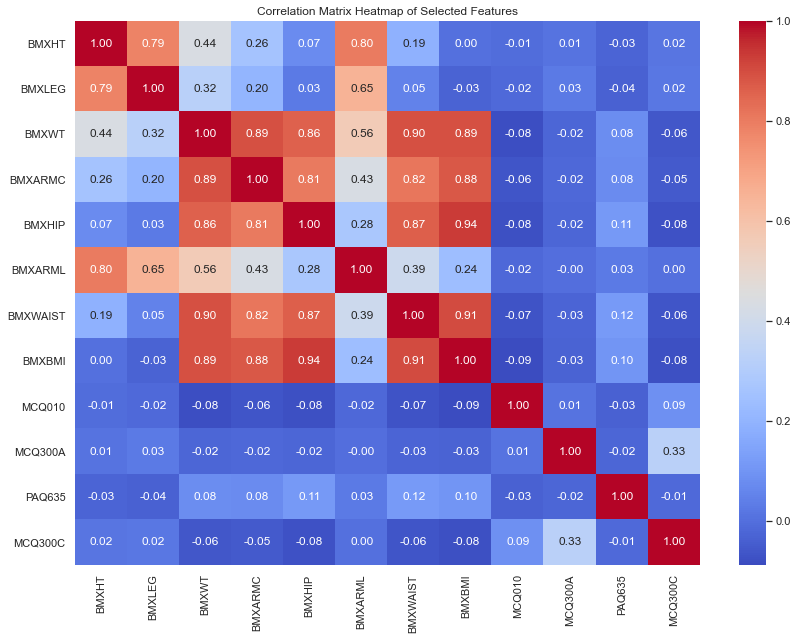

In [59]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Assuming that combined_data is your DataFrame that contains all these columns
# Replace 'combined_data' with your actual DataFrame containing the selected features
selected_features = ['BMXHT', 'BMXLEG', 'BMXWT', 'BMXARMC', 'BMXHIP', 'BMXARML', 'BMXWAIST', 'BMXBMI', 'MCQ010', 'MCQ300A', 'PAQ635', 'MCQ300C']

# Correlation matrix of selected features
correlation_matrix = combined_data[selected_features].corr()

# Print the correlation matrix
print("Correlation Matrix:")
print(correlation_matrix)

# Correlation with target variable 'Anaemia' if it's in your dataset
# Uncomment the following lines if you have the 'Anaemia' column in your combined_data DataFrame
#correlation_with_target = combined_data.corr()['Anemia'].sort_values(ascending=False)
#print("\nCorrelation with Target (Anaemia):")
#print(correlation_with_target)

# Heatmap of the correlation matrix
plt.figure(figsize=(14, 10))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Correlation Matrix Heatmap of Selected Features')
plt.show()